# VUELOS KAYAK

# 1.Extracción de datos

In [2]:
import requests 
import numpy as np

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By

from time import sleep

import pandas as pd

import ast

In [ ]:
# Parámetros del viaje

origen = 'Madrid'

destinos = ['Nueva York', 'San Francisco', 'Londres', 'Paris']

anho = '2024'

mes = 'abril'

dia_inicio = '1'

dia_fin = '15'

numero_adultos = '2'

numero_ninhos = '0'

numero_habitaciones = '1'

vuelos_a_escanear = 500

comparadores = ['kayak', 'tripadvaisor']

In [ ]:
#Elegir origen y destino
def buscador_origen_destino_kayak(origen, destino):
    browser.find_element(By.CLASS_NAME, "vvTc-item-button").click()

    buscador_origen, buscador_destino = browser.find_elements(By.CLASS_NAME, "k_my-input")[:2]

    buscador_origen.send_keys(origen)

    sleep(2)

    browser.find_element(By.CLASS_NAME, "JyN0-item").click()

    buscador_destino.send_keys(destino)

    sleep(2)

    browser.find_element(By.CLASS_NAME, "JyN0-name").click()

    sleep(2)

In [ ]:
#Seleccionar fechas viaje
def selector_fechas_viaje_kayak(dia_inicio, dia_fin, mes, anho):
    browser.find_element(By.CLASS_NAME, "sR_k-value").click()

    dias_semana = ['lunes', 'martes', 'miércoles', 'jueves', 'viernes', 'sábado', 'domingo']

    for inicio_fin in [dia_inicio, dia_fin]:

        els = browser.find_elements(By.CLASS_NAME, value = 'wHSr-monthName')

        for element in els:
            if element.text == f'{mes} {anho}':
                browser.execute_script("arguments[0].scrollIntoView();", element)
                break

        for dia in dias_semana:
            try:
                elemento = browser.find_element(By.CSS_SELECTOR, f"div[aria-label ='{dia} {inicio_fin} de {mes} de {anho}']")
            except:
                next
        elemento.click()

In [ ]:
#Seleccionar numero pasajeros
def seleccionar_pasajeros_kayak(numero_adultos):
    browser.find_element(By.CLASS_NAME, value = 'S9tW-chevron').click()

    adultos_requeridos = int(numero_adultos)

    while True:
        selector_adultos = browser.find_element(By.CLASS_NAME, value = 'u9Xa')

        aumentar_boton = selector_adultos.find_element(By.CSS_SELECTOR, "button[aria-label = 'Más']")
        disminuir_boton = selector_adultos.find_element(By.CSS_SELECTOR, "button[aria-label = 'Menos']")

        valor_adultos = selector_adultos.find_element(By.CSS_SELECTOR, "input[role = 'spinbutton']").get_attribute('value')

        valor_adultos = int(valor_adultos)

        if valor_adultos > adultos_requeridos:
            disminuir_boton.click()
        elif valor_adultos <adultos_requeridos:
            aumentar_boton.click()
        else:
            break

    browser.find_element(By.CSS_SELECTOR, "button[aria-label = 'Abrir menú de viajes']").click()
    sleep(3)
    browser.find_element(By.CSS_SELECTOR, "button[aria-label = 'Cerrar menú']").click()

In [ ]:
#Conseguir numero de vuelos a escanear
def buscador_vuelos_kayak(vuelos_a_escanear):
    try:
        browser.switch_to.window(browser.window_handles[1])
    except:
        next

    while True:
        els = browser.find_elements(By.CLASS_NAME, value = 'nrc6-content-section')
        browser.execute_script("arguments[0].scrollIntoView();", els[-1])
        try:
            browser.find_element(By.CLASS_NAME, value = 'resultsPaginator').click()
        except:
            break
        sleep(2)
        if len(els) > vuelos_a_escanear:
            break
    vuelos = browser.find_elements(By.CLASS_NAME, value = 'nrc6-content-section')
    
    return vuelos

In [ ]:
def guardar_datos_vuelos(comparador, data, destino):
        try:
            df = pd.read_csv(f'Vuelos {destino} {comparador}')
            identificador = df['identificador viaje'].max() + 1

        except:
            df = pd.DataFrame(columns =['identificador viaje', 'trayecto', 'vuelo', 'aeropuerto salida','codigo aeropuerto salida', 'aeropuerto llegada', 'codigo aeropuerto llegada','hora local salida', 'hora local llegada', 'duracion vuelo', 'duracion total viaje', 'ofertas'])
            identificador = 1

        for viaje in data:

            df_fila = pd.DataFrame(columns =['identificador viaje', 'trayecto', 'vuelo', 'aeropuerto salida','codigo aeropuerto salida', 'aeropuerto llegada', 'codigo aeropuerto llegada', 'hora local salida', 'hora local llegada', 'duracion vuelo', 'duracion total viaje', 'ofertas'])

            df_fila['ofertas'] = [viaje['ofertas']]

            for trayecto in ['ida', 'vuelta']:
                df_fila['duracion total viaje'] = viaje[trayecto]['duracion del viaje']

                for vuelo, datos_vuelo in viaje[trayecto]['escalas'].items():
                    df_fila['identificador viaje'] = identificador
                    df_fila['trayecto'] = trayecto
                    df_fila['vuelo'] = int(vuelo.split()[1])
                    df_fila['aeropuerto salida'] = datos_vuelo['aeropuerto salida'][0]
                    df_fila['codigo aeropuerto salida'] = datos_vuelo['aeropuerto salida'][1]
                    df_fila['aeropuerto llegada'] = datos_vuelo['aeropuerto llegada'][0]
                    df_fila['codigo aeropuerto llegada'] = datos_vuelo['aeropuerto llegada'][1]
                    df_fila['hora local salida'] = datos_vuelo['hora local salida']
                    df_fila['hora local llegada'] =  datos_vuelo['hora local llegada']
                    df_fila['duracion vuelo'] = datos_vuelo['duracion vuelo']

                    df = pd.concat([df, df_fila]) 
            identificador += 1

        df.reset_index(drop = True)   
        df.to_csv(f'Vuelos {destino} {comparador}') 

In [ ]:
#Conseguir datos de cada vuelo
def conseguir_datos_kayak(vuelos_a_escanear, destino, comparador = 'kayak'):
    vuelos = buscador_vuelos_kayak(vuelos_a_escanear)
    
    try:
        df = pd.read_csv(f'Vuelos {destino} {comparador}')
        elementos_escaneados = df['identificador viaje'].max()

    except:
        elementos_escaneados = 0

    data = []

    contador_control = 0

    for vuelo in vuelos:

        if contador_control != elementos_escaneados:
            contador_control += 1
            continue

        datos_vuelo = {}

        browser.execute_script("arguments[0].scrollIntoView();", vuelo)

        vuelo.click()

        try:
            browser.find_element(By.CLASS_NAME, value = 'RBZl-expand-button').click()
        except:
            next

        soup = BeautifulSoup(browser.page_source, 'html.parser')

        ofertas = soup.find_all('li', class_ = 'RBZl-row-wrapper')

        agencias = [oferta.find('div', class_ = 'veIp-provider-name').text[:-3] for oferta in ofertas]
        while True:
            if agencias[-1] in agencias[:-1]:
                agencias.pop(-1)
            else:
                break

        precios = [oferta.find('div', class_ = 'ehQI-provider-price').text.replace('\xa0€','') for oferta in ofertas]

        if int(numero_adultos) > 1:
            precios = [precio.split()[0] for precio in precios]

        if len(precios) != len(agencias):
            while len(precios) > len(agencias):
                    precios.pop(-1)
            while len(agencias) > len(precios):
                    agencias.pop(-1)


        ida, vuelta = soup.find_all('div', class_ = 'E69K-leg-wrapper')

        for trayecto, nombre_trayecto in zip([ida, vuelta],['ida', 'vuelta']):
            duracion_viaje = trayecto.find('div', class_ = 'c2x94-sub-title').text.split('•')[1]

            escalas = trayecto.find_all('div', class_ = 'NxR6-segment')

            informacion_vuelos = {}

            for idx, escala in enumerate(escalas):
                aeropuerto_salida, aeropuerto_llegada = escala.find('div', class_ = 'NxR6-airport').text.split(')')[:2]        

                codigo_aeropuerto_salida = aeropuerto_salida[-4:]+')'
                nombre_aeropuerto_salida = aeropuerto_salida[:-5]

                codigo_aeropuerto_llegada = aeropuerto_llegada[-4:]+')'
                nombre_aeropuerto_llegada = aeropuerto_llegada[3:-5]

                hora_salida, hora_llegada = escala.find('div', class_ = 'NxR6-time').text.split('-')
                hora_llegada, duracion_vuelo = hora_llegada.strip().replace(')','').split('(')

                palabras_aerolinea = escala.find('div', class_ = 'NxR6-plane-details').find_next().text.split()[:-1]
                aerolinea = ''
                for palabra in palabras_aerolinea:
                    aerolinea = aerolinea + '' + palabra
                aerolinea = aerolinea.strip()

                informacion_vuelos[f'vuelo {idx+1}'] = {'aerolinea' :aerolinea, 'aeropuerto salida' : [nombre_aeropuerto_salida, codigo_aeropuerto_salida], 'hora local salida' : hora_salida, 'aeropuerto llegada' : [nombre_aeropuerto_llegada, codigo_aeropuerto_llegada], 'hora local llegada' : hora_llegada, 'duracion vuelo' : duracion_vuelo}

            informacion_escalas = {}

            informacion_escalas['duracion del viaje'] = duracion_viaje
            informacion_escalas['escalas'] = informacion_vuelos


            datos_vuelo[f'{nombre_trayecto}'] = informacion_escalas

        datos_vuelo['ofertas'] = {agencia : precio for agencia, precio in zip(agencias, precios)}

        data.extend([datos_vuelo])
        
    

        #Estructura para salvaguardar datos
        if contador_control % 15 == 0:
            guardar_datos_vuelos(comparador, data, destino)

        if contador_control == vuelos_a_escanear:
            guardar_datos_vuelos(comparador, data, destino)
            break

        browser.back()
        
        contador_control += 1
        elementos_escaneados += 1

In [ ]:
for destino in destinos:
    while True:
        try:
            browser = webdriver.Chrome()

            browser.get("https://www.kayak.es/")

            sleep(5)

            browser.find_element(By.CLASS_NAME, "RxNS-button-content").click()

            buscador_origen_destino_kayak(origen, destino)

            selector_fechas_viaje_kayak(dia_inicio, dia_fin, mes, anho)

            seleccionar_pasajeros_kayak(numero_adultos)

            browser.find_element(By.CSS_SELECTOR, "button[aria-label = 'Buscar']").click()

            sleep(20)

            browser.switch_to.window(browser.window_handles[1])

            conseguir_datos_kayak(vuelos_a_escanear, destino)

            browser.close()

            break
        except:
            next

# VUELOS TRIPADVISOR

In [ ]:
def buscador_origen_destino_tripadvaisor(origen, destino):
    buscador_origen = browser.find_element(By.CSS_SELECTOR, "input[placeholder = 'Elige el origen']")
    buscador_origen.clear()
    sleep(1)
    buscador_origen.send_keys(origen)
    sleep(2)
    try:
        browser.find_element(By.CSS_SELECTOR, "li[class = 'ui_icon flights selected']").click() #Para ciudades con un solo aeropuerto
    except:
        browser.find_element(By.CSS_SELECTOR, "li[class = 'map-pin-fill ui_icon flights selected']").click() #Para ciudades con mas de un aeropuerto
    
    buscador_destino = browser.find_element(By.CSS_SELECTOR, "input[placeholder = 'Elige el destino']")
    buscador_destino.clear()
    sleep(1)
    buscador_destino.send_keys(destino)
    sleep(2)
    try:
        browser.find_element(By.CSS_SELECTOR, "li[class = 'ui_icon flights selected']").click() #Para ciudades con un solo aeropuerto
    except:
        browser.find_element(By.CSS_SELECTOR, "li[class = 'map-pin-fill ui_icon flights selected']").click() #Para ciudades con mas de un aeropuerto

In [ ]:
def selector_fechas_viaje_tripadvaisor(dia_inicio, dia_fin, mes, anho):
    diccionario_meses = {
        'enero': 'ene',
        'febrero': 'feb',
        'marzo': 'mar',
        'abril': 'abr',
        'mayo': 'may',
        'junio': 'jun',
        'julio': 'jul',
        'agosto': 'ago',
        'septiembre': 'sept',
        'octubre': 'oct',
        'noviembre': 'nov',
        'diciembre': 'dic'}

    mes_abreviado = diccionario_meses[mes]

    browser.find_element(By.CSS_SELECTOR, "span[data-emptytext = 'Salida']").click()
    sleep(1)

    while True:
        mes_anho = browser.find_element(By.CSS_SELECTOR, "span[class = 'rsdc-month']").text.split('\n')[0]

        if mes_anho == f'{mes_abreviado} {anho}':
            break
        avanzar_mes = browser.find_element(By.CSS_SELECTOR, "div[class = 'rsdc-next rsdc-nav ui_icon single-chevron-right-circle']")

        avanzar_mes.click()

        sleep(1)

    contador = 0

    while True:
        dia = browser.find_elements(By.CLASS_NAME, value = 'rsdc-day')[contador]
        if dia.text == dia_inicio:
            dia.click()
        elif dia.text == dia_fin:
            dia.click()
            break
        contador += 1

In [ ]:
def seleccionar_pasajeros_tripadvaisor(numero_adultos):
    browser.find_element(By.CLASS_NAME, value = 'flightsTotalTravelers').click()

    while True:
        valor_adultos = browser.find_elements(By.CLASS_NAME, value = 'travelerRow')[6].text.split()[0]

        if valor_adultos != numero_adultos:

            browser.find_elements(By.CSS_SELECTOR, "div[class = 'adultCounter counter']")[2].find_element(By.CSS_SELECTOR, "span[class = 'ui_icon plus-circle enabled']").click()
        else:
            break

    browser.find_elements(By.CSS_SELECTOR, "span[class = 'ui_link closeText']")[-1].click()

In [ ]:
def guardar_datos_vuelos(comparador, data, destino):
        try:
            df = pd.read_csv(f'Vuelos {destino} {comparador}')
            identificador = df['identificador viaje'].max() + 1

        except:
            df = pd.DataFrame(columns =['identificador viaje', 'trayecto', 'vuelo', 'aeropuerto salida','codigo aeropuerto salida', 'aeropuerto llegada', 'codigo aeropuerto llegada','hora local salida', 'hora local llegada', 'duracion vuelo', 'duracion total viaje', 'ofertas'])
            identificador = 1

        for viaje in data:

            df_fila = pd.DataFrame(columns =['identificador viaje', 'trayecto', 'vuelo', 'aeropuerto salida','codigo aeropuerto salida', 'aeropuerto llegada', 'codigo aeropuerto llegada', 'hora local salida', 'hora local llegada', 'duracion vuelo', 'duracion total viaje', 'ofertas'])

            df_fila['ofertas'] = [viaje['ofertas']]

            for trayecto in ['ida', 'vuelta']:
                df_fila['duracion total viaje'] = viaje[trayecto]['duracion del viaje']

                for vuelo, datos_vuelo in viaje[trayecto]['escalas'].items():
                    df_fila['identificador viaje'] = identificador
                    df_fila['trayecto'] = trayecto
                    df_fila['vuelo'] = int(vuelo.split()[1])
                    df_fila['aeropuerto salida'] = datos_vuelo['aeropuerto salida'][0]
                    df_fila['codigo aeropuerto salida'] = datos_vuelo['aeropuerto salida'][1]
                    df_fila['aeropuerto llegada'] = datos_vuelo['aeropuerto llegada'][0]
                    df_fila['codigo aeropuerto llegada'] = datos_vuelo['aeropuerto llegada'][1]
                    df_fila['hora local salida'] = datos_vuelo['hora local salida']
                    df_fila['hora local llegada'] =  datos_vuelo['hora local llegada']
                    df_fila['duracion vuelo'] = datos_vuelo['duracion vuelo']

                    df = pd.concat([df, df_fila]) 
            identificador += 1

        df.reset_index(drop = True)   
        df.to_csv(f'Vuelos {destino} {comparador}') 

In [ ]:
def conseguir_datos_tripadvaisor(vuelos_a_escanear, destino, comparador = 'tripadvaisor'):
    try:
        df = pd.read_csv(f'Vuelos {destino} {comparador}')
        elementos_escaneados = df['identificador viaje'].max()

    except:
        elementos_escaneados = 0
    data = []

    contador_control = 0

    while True:
        vuelos = browser.find_elements(By.CSS_SELECTOR, "button[class = 'ui_button original chevron']")

        for vuelo in vuelos:
            print(contador_control, elementos_escaneados)
            if contador_control != elementos_escaneados:
                contador_control += 1
                continue
            else:

                browser.execute_script("arguments[0].scrollIntoView();", vuelo)

                vuelo.click()

                datos_vuelo = {}

                while True:
                    try:
                        mostrar_escalas = browser.find_element(By.CSS_SELECTOR, "span[class = 'ui_icon single-chevron-down ']")

                        mostrar_escalas.click()
                    except:
                        break

                while True:
                    try:
                        mostrar_mas_ofertas = browser.find_element(By.CSS_SELECTOR, "span[class = 'ui_icon caret-down iPBtA']")

                        mostrar_mas_ofertas.click()
                    except:
                        break

                soup = BeautifulSoup(browser.page_source, 'html.parser')

                ofertas = soup.find_all('div', class_ = 'ui_columns is-gapless is-vcentered f')

                precios = []
                agencias = []
                for oferta in ofertas:
                    precio = oferta.find('span', class_ = 'zxNPp Wi').text.split('\xa0€')[0]
                    precios.append(precio)

                    agencia = str(oferta.find('div')).split('.png')[0].split('websites/')[1]
                    agencias.append(agencia)

                ida, vuelta = soup.find_all('div', class_ = ['YSZUo ME'])

                for trayecto, nombre_trayecto in zip([ida, vuelta],['ida', 'vuelta']):

                    escalas = trayecto.find_all('div', class_ = 'ejOpT')

                    try:
                        espera_escalas = trayecto.find_all('div', class_ = 'RnfSy Ma Nh MA NJ S4')
                        espera_escalas = [espera.text.split(' de escala')[0] for espera in espera_escalas]

                        horas_trayecto = [espera.split('h ')[0] for espera in espera_escalas]
                        minutos_trayecto = [espera.split('h ')[1].replace('m','') for espera in espera_escalas]

                    except:
                        horas_trayecto = []
                        minutos_trayecto = []

                    informacion_vuelos = {}

                    for idx, escala in enumerate(escalas):

                        aeropuertos = escala.find_all('div', class_ = 'uMeIk')

                        aeropuerto_salida, aeropuerto_llegada = [aeropuerto.text for aeropuerto in aeropuertos]

                        codigo_aeropuerto_salida = aeropuerto_salida[-5:]
                        nombre_aeropuerto_salida = aeropuerto_salida[:-6]

                        codigo_aeropuerto_llegada = aeropuerto_llegada[-5:]
                        nombre_aeropuerto_llegada = aeropuerto_llegada[:-6]

                        horas = escala.find_all('div', class_ = 'ubIbl b')
                        hora_salida, hora_llegada = [hora.text for hora in horas]

                        aerolinea = escala.find('div', class_ = 'JOElb f u').text

                        duracion_vuelo = escala.find('div', class_ = 'FbWvp').text.replace('Duración: ','')

                        horas_trayecto.append(duracion_vuelo.split('h ')[0])
                        minutos_trayecto.append(duracion_vuelo.split('h ')[1].replace('m',''))

                        informacion_vuelos[f'vuelo {idx+1}'] = {'aerolinea' :aerolinea, 'aeropuerto salida' : [nombre_aeropuerto_salida, codigo_aeropuerto_salida], 'hora local salida' : hora_salida, 'aeropuerto llegada' : [nombre_aeropuerto_llegada, codigo_aeropuerto_llegada], 'hora local llegada' : hora_llegada, 'duracion vuelo' : duracion_vuelo}


                    horas_trayecto = sum([int(horas) for horas in horas_trayecto])
                    minutos_trayecto = sum([int(minutos) for minutos in minutos_trayecto])

                    duracion_viaje = f'{horas_trayecto + minutos_trayecto // 60}h {minutos_trayecto % 60}m'


                    informacion_escalas = {}

                    informacion_escalas['duracion del viaje'] = duracion_viaje
                    informacion_escalas['escalas'] = informacion_vuelos


                    datos_vuelo[f'{nombre_trayecto}'] = informacion_escalas

                datos_vuelo['ofertas'] = {agencia : precio for agencia, precio in zip(agencias, precios)}

                data.extend([datos_vuelo])

                browser.find_element(By.CSS_SELECTOR, "div[aria-label = 'Cerrar']").click()

                #Estructura para salvaguardar datos
                if contador_control % 15 == 0:
                    guardar_datos_vuelos(comparador, data, destino)

        if contador_control >= vuelos_a_escanear:
            break

        try:
            browser.find_element(By.CSS_SELECTOR, "span[class = 'ui_button nav next primary ']").click()
            contador_control += 1
            elementos_escaneados += 1
            sleep(1)
        except:
            guardar_datos_vuelos(comparador, data, destino)
            break

In [ ]:
for destino in destinos:
    while True:
        try:
            browser = webdriver.Chrome()

            browser.get("https://www.tripadvisor.es/CheapFlightsHome")

            sleep(4)

            browser.find_element(By.ID, value = 'onetrust-accept-btn-handler').click()

            buscador_origen_destino_tripadvaisor(origen, destino)

            selector_fechas_viaje_tripadvaisor(dia_inicio, dia_fin, mes, anho)

            seleccionar_pasajeros_tripadvaisor(numero_adultos)

            browser.find_element(By.CSS_SELECTOR, "button[class = 'form_submit searchBtn es es']").click()

            sleep(20)

            conseguir_datos_tripadvaisor(vuelos_a_escanear, destino)

            browser.close()
            
            break
        except:
            next

# 2. LIMPIEZA DE DATOS

In [193]:
from datetime import datetime

In [216]:
def duracion_a_horas(tiempo):
    horas, minutos = tiempo.split()
    horas = int(horas.split('h')[0])
    minutos = int(minutos.strip().split('m')[0])
    duracion = horas + minutos / 60
    return duracion

In [217]:
def cambiar_datetime(hora):
    hora = hora.split('+')[0]
    hora_datetime = datetime.strptime(hora, "%H:%M").time()
    return hora_datetime

In [ ]:
df_vuelos = pd.DataFrame()
for comparador in comparadores:
    for destino in destinos:
        print(f'Limpiando viaje a {destino} con {comparador}')
        df = pd.read_csv(f'Data/Vuelos {destino} {comparador}')
        
        df = df[df['identificador viaje'].between(1,1500)]

        df = df[['identificador viaje',
               'trayecto', 'vuelo', 'aeropuerto salida', 'codigo aeropuerto salida',
               'aeropuerto llegada', 'codigo aeropuerto llegada', 'hora local salida',
               'hora local llegada', 'duracion vuelo', 'duracion total viaje',
               'ofertas']]

        df['ofertas'] = df['ofertas'].apply(ast.literal_eval)

        df['mejor oferta'] = df['ofertas'].apply(lambda x : [(agencia, precio) for agencia, precio in x.items()][0])

        df['agencia'] = df['mejor oferta'].apply(lambda x : x[0])
        
        df['mejor oferta'] = df['mejor oferta'].apply(lambda x : int(x[1]))

        #Para los df de tripadvaisor
        if comparador == 'tripadvaisor':
            agencias = {'tfes': 'Travelfrom.es',
                         'xpes': 'Expedia',
                         'a582': 'Rumbo',
                         'ctes': 'Trip.com',
                         'ates': 'BudgetAir',
                         'skyp': 'Kiwi.com',
                         'mtes': 'mytrip.com1',
                         'bces': 'Booking.com',
                         'edes': 'eDreams',
                         'easy': 'easyJetAerolí',
                         'ibex': 'Iberia ExpressAerolí',
                         'iber': 'IberiaAerolí',
                         'lolt': 'lol.travel',
                         'lmes': 'lastminute.es',
                         'gtes': 'Gotogate1',
                         'veci': 'Viajes el Corte Inglés',
                         'finn': 'Finnair',
                         'uair': 'United Airlines',
                         'ba__': 'British Airways',
                         'txes': 'Tix.es',
                         'snbr': 'Brussels Airlines',
                         'tap_': 'Air Portugal',
                         'klm1': 'KLM',
                         'luft': 'Lufthansa',
                         'opes': 'Opodo',
                         'airf': 'Air France',
                         'basi': 'Transavia',
                         'aaes': 'American Airlines'}

            df['agencia'] = df['agencia'].replace(agencias)

        df['agencia'] = df['agencia'].apply(lambda x : x.replace('Aerolí',''))

        #Eliminamos los posibles datos repetidos
        
        columnas_datos = ['trayecto', 'vuelo', 'aeropuerto salida',
       'codigo aeropuerto salida', 'aeropuerto llegada',
       'codigo aeropuerto llegada', 'hora local salida', 'hora local llegada',
       'duracion vuelo', 'duracion total viaje', 'ofertas', 'mejor oferta',
       'agencia']
        
        for i in df['identificador viaje'].unique():

            vuelo = df[df['identificador viaje'] == i][columnas_datos]
            df_sin_vuelo = df[~df['identificador viaje'] == i][columnas_datos]

            if True in vuelo.isin(df_sin_vuelo).values:
                indices_vuelo_repetido = vuelo.index
                df = df.drop(indices_vuelo_repetido, axis=0)
                
        df['vuelo'] = df['vuelo'].apply(lambda x : int(x) -1)
        
        grouped = df.groupby(['identificador viaje', 'trayecto'])
        df['escalas'] = grouped['vuelo'].transform('max')
        
        df['destino'] = destino
        df['comparador'] = comparador
        
        df['duracion total viaje horas'] = df['duracion total viaje'].apply(lambda x : duracion_a_horas(x))
        df['duracion vuelo horas'] = df['duracion vuelo'].apply(lambda x : duracion_a_horas(x))
        
        df_vuelos = pd.concat([df_vuelos,df])
        

df_vuelos['aeropuerto llegada'] = df_vuelos['aeropuerto llegada'].apply(lambda x : x.replace('Aeropuerto de ',''))
df_vuelos['aeropuerto llegada'] = df_vuelos['aeropuerto llegada'].apply(lambda x : x.replace('Aeropuerto Internacional de ',''))

df_vuelos['aeropuerto salida'] = df_vuelos['aeropuerto salida'].apply(lambda x : x.replace('Aeropuerto de ',''))
df_vuelos['aeropuerto salida'] = df_vuelos['aeropuerto salida'].apply(lambda x : x.replace('Aeropuerto Internacional de ',''))

# AIRTABLE

In [226]:
import numpy as np
import pandas as pd

import requests

from pprint import pprint

In [227]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [ ]:
API_KEY = os.getenv("AIRTABLE_API_KEY")

BASE_ID = "appwy5RMmczr2LlgM" # Base: Tabla API 

TABLE_ID = "tblmgejKCl5hSMKBB" # Tabla: datos_1

airtable_base_url = "https://api.airtable.com/v0"

# Headers
headers = {"Authorization" : f"Bearer {API_KEY}",  
           "Content-Type"  : "application/json"}

response = requests.post(url = url, json = datos_subir, headers = headers)

In [228]:
df = pd.read_csv("Data/Datos vueloss.csv")
df

Unnamed: 0  identificador viaje trayecto  vuelo aeropuerto salida  \
0               0                    1      ida      1    Madrid-Barajas   
1               1                    1   vuelta      1        París-Orly   
2               2                    2      ida      1    Madrid-Barajas   
3               3                    2   vuelta      1        París-Orly   
4               4                    3      ida      1    Madrid-Barajas   
...           ...                  ...      ...    ...               ...   
28336        2995                 1498   vuelta      1        París-Orly   
28337        2996                 1499      ida      1    Madrid-Barajas   
28338        2997                 1499   vuelta      1        París-Orly   
28339        2998                 1500      ida      1    Madrid-Barajas   
28340        2999                 1500   vuelta      1        París-Orly   

      codigo aeropuerto salida aeropuerto llegada codigo aeropuerto llegada  \
0                        (MAD)         París-Orly                     (ORY)   
1                        (ORY)     Madrid-Barajas                     (MAD)   
2                        (MAD)         París-Orly                     (ORY)   
3                        (ORY)     Madrid-Barajas                     (MAD)   
4                        (MAD)     Beauvais-Tillé                     (BVA)   
...                        ...                ...                       ...   
28336                    (ORY)     Madrid-Barajas                     (MAD)   
28337                    (MAD)         París-Orly                     (ORY)   
28338                    (ORY)     Madrid-Barajas                     (MAD)   
28339                    (MAD)         París-Orly                     (ORY)   
28340                    (ORY)     Madrid-Barajas                     (MAD)   

      hora local salida hora local llegada duracion vuelo  \
0                 6:00                8:05         2h 05m   
1                10:15               12:15         2h 00m   
2                 6:00                8:05         2h 05m   
3                10:15               12:15         2h 00m   
4                 6:20                8:30         2h 10m   
...                 ...                ...            ...   
28336             10:15              12:15          2h 0m   
28337             13:00              15:05          2h 5m   
28338             20:55              22:55          2h 0m   
28339             17:35              19:40          2h 5m   
28340             10:15              12:15          2h 0m   

      duracion total viaje                                            ofertas  \
0                   2h 05m                             {'Booking.com': '115'}   
1                   2h 00m                             {'Booking.com': '115'}   
2                   2h 05m                             {'Booking.com': '115'}   
3                   2h 00m                             {'Booking.com': '115'}   
4                   2h 10m  {'eDreams': '95', 'mytrip.com1': '92', 'Gotoga...   
...                    ...                                                ...   
28336                2h 0m  {'edes': '152', 'bces': '154', 'opes': '155', ...   
28337                2h 5m  {'edes': '152', 'bces': '154', 'opes': '155', ...   
28338                2h 0m  {'edes': '152', 'bces': '154', 'opes': '155', ...   
28339                2h 5m  {'edes': '152', 'bces': '154', 'opes': '155', ...   
28340                2h 0m  {'edes': '152', 'bces': '154', 'opes': '155', ...   

       mejor oferta      agencia     Destino    comparador  
0               115  Booking.com  Nueva York         kayak  
1               115  Booking.com  Nueva York         kayak  
2               115  Booking.com  Nueva York         kayak  
3               115  Booking.com  Nueva York         kayak  
4                95      eDreams  Nueva York         kayak  
...             ...          ...         ...           ...  
28336       

In [229]:
df.columns

Index(['Unnamed: 0', 'identificador viaje', 'trayecto', 'vuelo',
       'aeropuerto salida', 'codigo aeropuerto salida', 'aeropuerto llegada',
       'codigo aeropuerto llegada', 'hora local salida', 'hora local llegada',
       'duracion vuelo', 'duracion total viaje', 'ofertas', 'mejor oferta',
       'agencia', 'Destino', 'comparador'],
      dtype='object')

In [230]:
endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID}"

print(endpoint)


https://api.airtable.com/v0/appwy5RMmczr2LlgM/tblqQQPODViLGpsZM


In [231]:
datos = []
for idx, row in df.iterrows():
    data={"fields": row.fillna("").to_dict()}
    datos.append(data)

In [ ]:
counter = 0

while counter<len(datos):
    print(f"Subiendo datos {counter} de {len(datos)}")
    datos_subir = datos[counter:counter+10]
    datos_subir = {"records": datos_subir}
    
    response = requests.post(url = endpoint, json = datos_subir, headers = headers)
    
    counter += 10
    
    print(response.text)

# Gráficas

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium

In [197]:
df_vuelos = pd.read_csv("Data/Datos vuelosss.csv")

In [205]:
df_vuelos.head(1)

Unnamed: 0  identificador viaje trayecto  vuelo aeropuerto salida  \
0           0                    1      ida      0    Madrid-Barajas   

  codigo aeropuerto salida aeropuerto llegada codigo aeropuerto llegada  \
0                    (MAD)         París-Orly                     (ORY)   

  hora local salida hora local llegada duracion vuelo duracion total viaje  \
0             6:00                8:05         2h 05m               2h 05m   

                  ofertas  mejor oferta      agencia  escalas     destino  \
0  {'Booking.com': '115'}           115  Booking.com        0  Nueva York   

  comparador  duracion total viaje horas  duracion vuelo horas  
0      kayak                    2.083333              2.083333

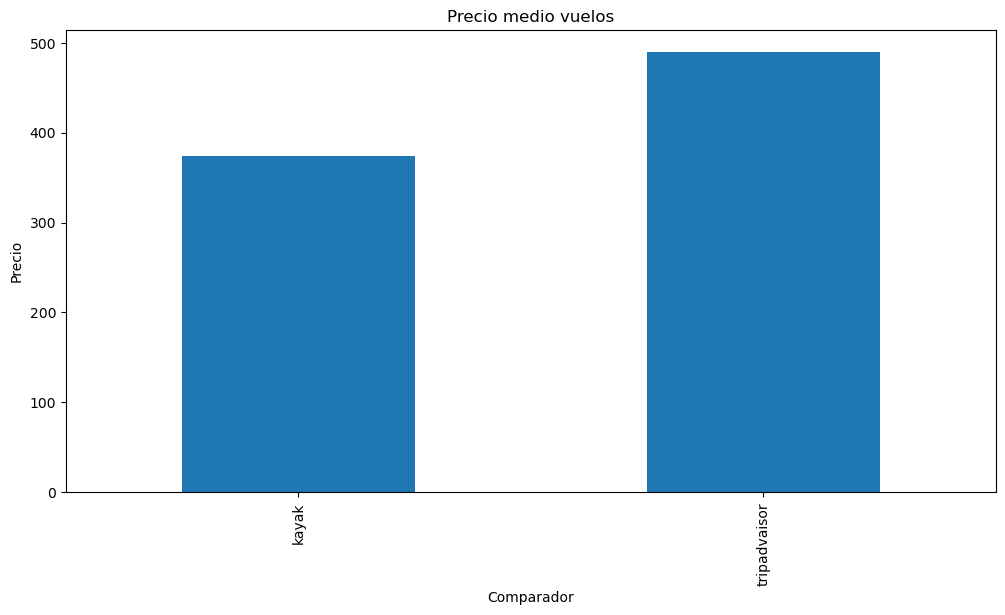

In [198]:
df = df_vuelos.groupby('comparador')['mejor oferta'].mean()#.unstack()

df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title(f'Precio medio vuelos')
plt.xlabel('Comparador')
plt.ylabel('Precio')
plt.show()

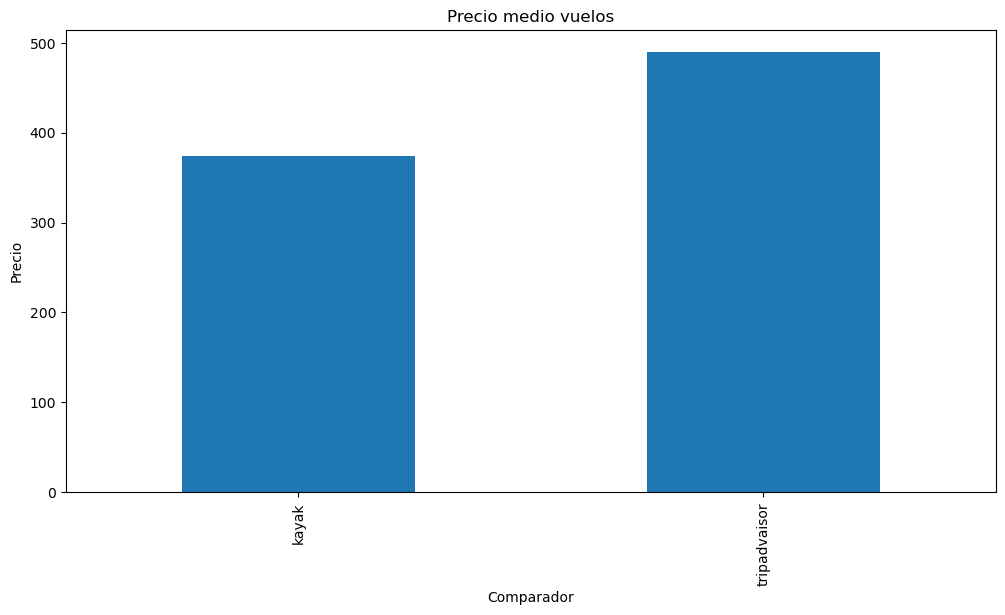

In [199]:
df = df_vuelos.groupby('comparador')['mejor oferta'].mean()#.unstack()

df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title(f'Precio medio vuelos')
plt.xlabel('Comparador')
plt.ylabel('Precio')
plt.show()

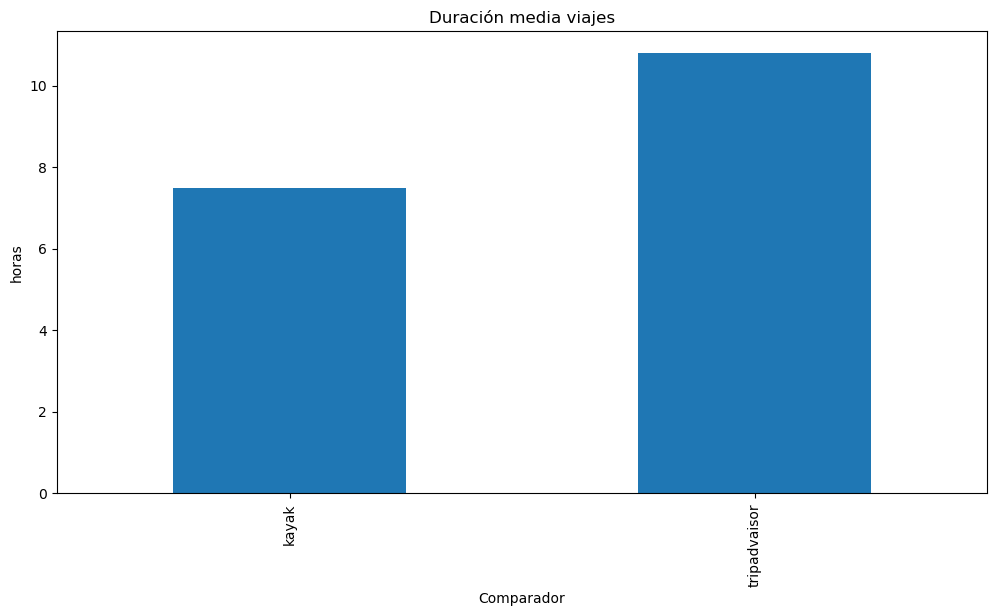

In [200]:
df = df_vuelos.groupby('comparador')['duracion total viaje horas'].mean()#.unstack()

df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title(f'Duración media viajes')
plt.xlabel('Comparador')
plt.ylabel('horas')
plt.show()

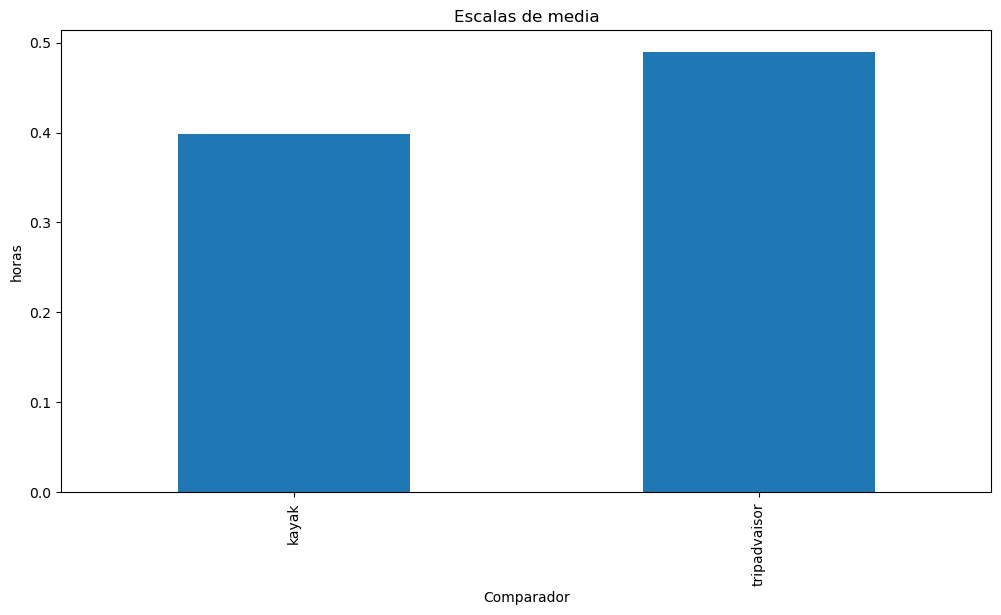

In [201]:
df = df_vuelos.groupby('comparador')['escalas'].mean()#.unstack()

df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title(f'Escalas de media')
plt.xlabel('Comparador')
plt.ylabel('horas')
plt.show()

In [ ]:
for destino in destinos:
        df_graficar = df_vuelos[df_vuelos['destino'] == destino]
        precio_medio = df_graficar.groupby('comparador')['mejor oferta'].mean()#.unstack()

        precio_medio.plot(kind='bar', stacked=True, figsize=(12, 6))
        plt.title(f'Precio medio vuelo a {destino}')
        plt.xlabel('Comparador')
        plt.ylabel('Precio')
        plt.show()

In [ ]:
# Boxplot precio por destino y comparador
for destino in destinos:
    df = df_vuelos[df_vuelos['destino'] == destino]
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x="comparador", y="mejor oferta")
    plt.xticks(rotation=45)
    plt.xlabel(f"{destino}")
    plt.ylabel("Precio")
    plt.title("Análisis de Precios por destino")
    plt.show()

In [ ]:
for destino in destinos:
    plt.figure(figsize = (10, 6))
    df = df_vuelos[df_vuelos['destino'] == destino]
    sns.barplot(x = "comparador", y = "mejor oferta", hue = "escalas", data = df, palette = "rainbow")
    plt.xlabel(f"{destino}")
    plt.ylabel("Precio")
    plt.title("Análisis de precios por escala")
    plt.show()

    plt.show()

In [ ]:
for destino in destinos:
    plt.figure(figsize = (10, 6))
    df = df_vuelos[df_vuelos['destino'] == destino]
    sns.barplot(x = "comparador", y = "duracion total viaje horas", hue = "escalas", data = df, palette = "rainbow")
    plt.title(f'{destino} - {comparador}')
    plt.xlabel('Escalas')
    plt.ylabel('duración del viaje en horas')
    plt.legend(title=f'escalas', title_fontsize='12')
    plt.show()

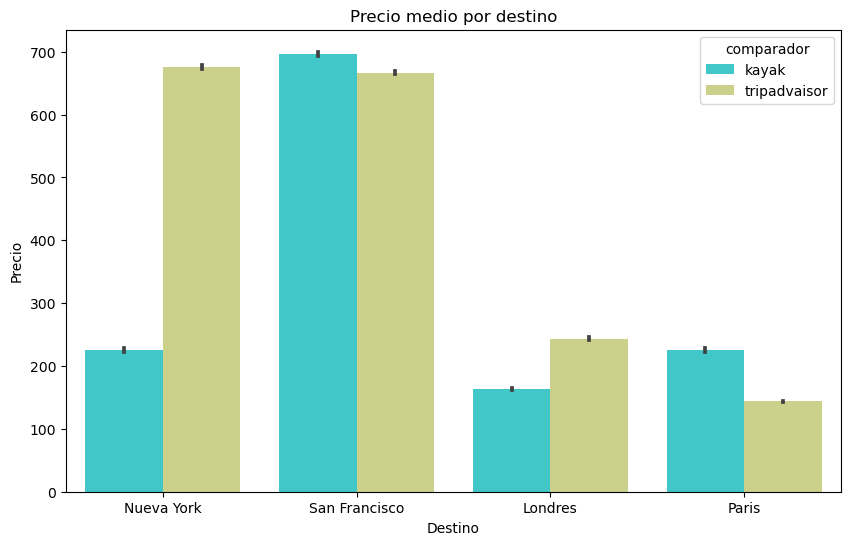

In [208]:
plt.figure(figsize = (10, 6))
sns.barplot(x = "destino", y = "mejor oferta", hue = "comparador", data = df_vuelos, palette = "rainbow")
plt.xlabel('Destino')
plt.ylabel("Precio")
plt.title("Precio medio por destino")
plt.show()

plt.show()

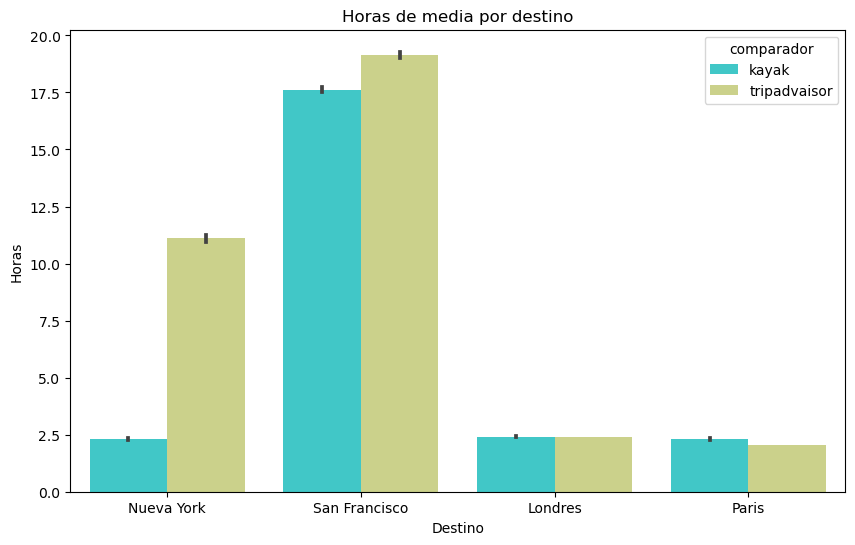

In [209]:
plt.figure(figsize = (10, 6))
sns.barplot(x = "destino", y = "duracion total viaje horas", hue = "comparador", data = df_vuelos, palette = "rainbow")
plt.xlabel('Destino')
plt.ylabel("Horas")
plt.title("Horas de media por destino")
plt.show()

plt.show()

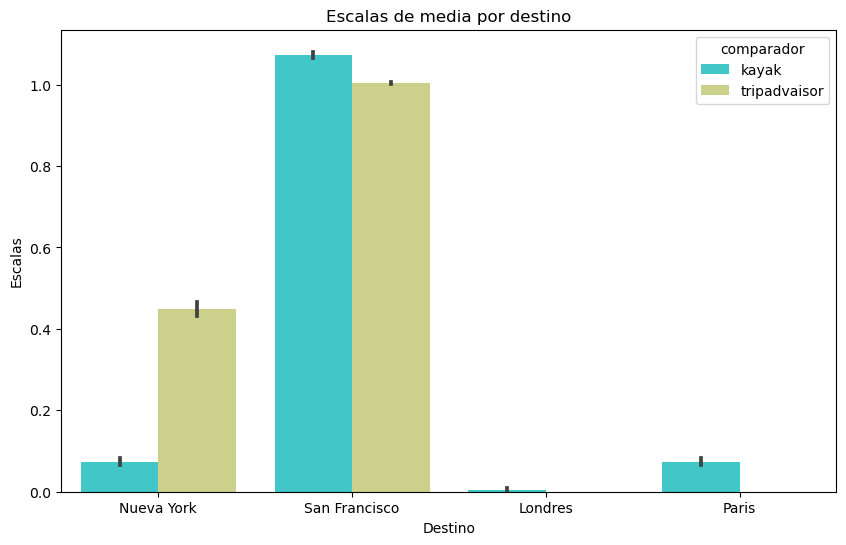

In [210]:
plt.figure(figsize = (10, 6))
sns.barplot(x = "destino", y = "escalas", hue = "comparador", data = df_vuelos, palette = "rainbow")
plt.xlabel('Destino')
plt.ylabel("Escalas")
plt.title("Escalas de media por destino")
plt.show()

plt.show()

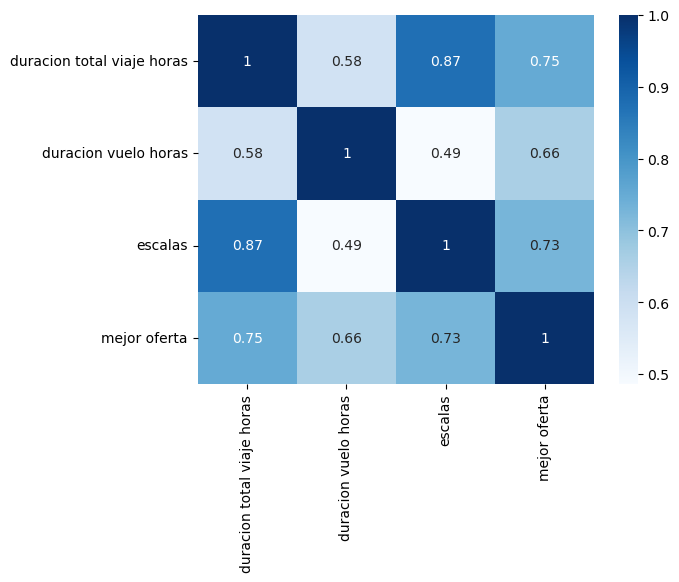

In [211]:

sns.heatmap(data = df_vuelos[["duracion total viaje horas",'duracion vuelo horas', "escalas", "mejor oferta"]].corr(),
            annot = True,
            cmap = "Blues")

plt.show()

In [ ]:
for destino in destinos:
    df = df_vuelos[df_vuelos['destino'] == destino]
    df.groupby('agencia').size().sort_values().plot.bar()
    plt.title(f'Ofertas por agencia para volar a {destino}')

    plt.show()

In [ ]:
for destino in destinos:
    df = df_vuelos[df_vuelos['destino'] == destino]
    sns.pairplot(df, vars = ["mejor oferta", "duracion total viaje horas"], height = 5, hue = "comparador")
    plt.title(f'{destino}')
    plt.show()

# ALOJAMIENTOS KAYAK

# 1.Extracción de datos

In [1]:
import requests 

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By

from time import sleep

import numpy as np
import pandas as pd

In [2]:
destino = "San Francisco"

anho = "2024"

mes = "abril"

dia_inicio = "1"

dia_fin = "15"

numero_adultos = '2'

numero_ninhos = '0'

numero_habitaciones = '1'

In [1]:
browser = webdriver.Chrome()

browser.get("https://www.kayak.es/stays")

sleep(5)

browser.maximize_window()



NameError: name 'webdriver' is not defined

In [4]:
#ACeptar cookies:

browser.find_element(By.CLASS_NAME, 'RxNS-button-content').click()

In [5]:
url = "https://www.kayak.es/stays"

response = requests.get(url)

In [6]:
browser.find_element(By.CLASS_NAME, "k_my-input").click()

In [7]:
#Introducir ciudad en barra alojamiento:

buscador = browser.find_element(By.CLASS_NAME, "k_my-input")

In [8]:
buscador.send_keys(destino)
sleep(2)

In [9]:
browser.find_element(By.CLASS_NAME, "k_my-prefix-icon").click()
sleep(2)

In [12]:
#Seleccionar fechas viaje
def selector_fechas_viaje_kayak(dia_inicio, dia_fin, mes, anho):
    browser.find_element(By.CLASS_NAME, "sR_k-value").click()

    dias_semana = ['lunes', 'martes', 'miércoles', 'jueves', 'viernes', 'sábado', 'domingo']

    for inicio_fin in [dia_inicio, dia_fin]:

        els = browser.find_elements(By.CLASS_NAME, value = 'wHSr-monthName')

        for element in els:
            if element.text == f'{mes} {anho}':
                browser.execute_script("arguments[0].scrollIntoView();", element)
                break

        for dia in dias_semana:
            try:
                elemento = browser.find_element(By.CSS_SELECTOR, f"div[aria-label ='{dia} {inicio_fin} de {mes} de {anho}']")
            except:
                next
        elemento.click()

In [13]:
#Entrar:
browser.find_element(By.CLASS_NAME, "HPw7-submit").click()
sleep(6)

In [7]:
#trabajar sobre la segunda pestaña:

try:
    browser.switch_to.window(browser.window_handles[1])
except:
    next

In [16]:
#dejo solo hotel
#quito "alquiler vacacional y estancias unicas"
browser.find_element(By.XPATH, '//*[@id="leftRail"]/div/div/div[1]/div/div[16]/div[3]/div[1]/div[1]').click()
sleep(5)
browser.find_element(By.XPATH, '//*[@id="leftRail"]/div/div/div[1]/div/div[16]/div[4]/div[1]/div[1]').click()
sleep(5)

In [8]:
#Conseguimos las urls de los hoteles
url_hoteles = []

while True:
    soup = BeautifulSoup(browser.page_source, 'html.parser')
    
    hoteles_pagina = soup.find_all('div', class_ = "kzGk-resultInner")
    
    url_hoteles_pagina = ['https://www.kayak.es' + hotel.find('a')['href'] for hotel in hoteles_pagina]
    
    url_hoteles.extend(url_hoteles_pagina)
    
    comprobador_utlima_pagina = browser.find_element(By.CSS_SELECTOR, "button[aria-label = 'Página siguiente']").get_attribute('aria-disabled')
    
    if comprobador_utlima_pagina == 'false':
        browser.find_element(By.CSS_SELECTOR, "button[aria-label = 'Página siguiente']").click()

    else:
        break

In [18]:
for url in url_hoteles:
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

In [19]:
def info_hotel(soup):
    info ={}
    try:
        info['Nombre'] = soup.find("h1", class_ = "c3xth-hotel-name").text
        info ['Ubicación'] = soup.find("div", class_ = "c3xth-address").text
        info['Estrellas'] = soup.find("div", class_ = "O3Yc-sp-default")['aria-label'][:11]
        info['Puntuación'] = soup.find("span", class_ = "YlEV-rating-score").text
        info['Valoración'] = soup.find("div", class_ = "YlEV-reviews-category").text
        info['Num_Opiniones'] = soup.find("div", class_ = "YlEV-review-count").text.strip("()")
        info['Precio'] = soup.find("span", class_ = "c3xth-price").text.replace("\xa0€", "")
        info['Agencia'] = soup.find("span", class_ = "c3xth-provider").text
    except :
        pass
    return info

In [20]:
info_hoteles=[]
for url in url_hoteles[:500]:
    try:
        browser.get(url)
        sleep(2)
        soup = BeautifulSoup(browser.page_source, "html.parser")
   
        info = info_hotel(soup)
        info_hoteles.append(info)
    except:
        pass

In [21]:
df = pd.DataFrame(info_hoteles)

In [22]:
df

Nombre  \
0                      The Ritz-Carlton, San Francisco   
1                          The St. Regis San Francisco   
2                         Stanford Court San Francisco   
3                         Hotel Caza Fisherman's Wharf   
4                   Beacon Grand, A Union Square Hotel   
..                                                 ...   
375                                  Alexis Park Hotel   
376  Private Room w/Shared Bath in Boutique Propert...   
377                            Worldmark San Francisco   
378  Modern Suite Surrounded by World-Class Art w/ ...   
379                              Alpine Inn And Suites   

                                          Ubicación    Estrellas Puntuación  \
0      600 Stockton Street, San Francisco, CA 94104  5 estrellas        9,0   
1           125 3rd Street, San Francisco, CA 94103  5 estrellas        8,7   
2    905 California Street, San Francisco, CA 94108  4 estrellas        8,6   
3     1300 Columbus Avenue, San Francisco, CA 94133  4 estrellas        8,4   
4        450 Powell Street, San Francisco, CA 94102  4 estrellas        8,7   
..                                              ...          ...        ...   
375        825 Polk Street, San Francisco, CA 94109  2 estrellas        4,8   
376              80 9th St, San Francisco, CA 94103  0 estrellas       10,0   
377        590 Bush Street, San Francisco, CA 94108  2 estrellas        8,0   
378      333 Fulton Street, San Francisco, CA 94102  0 estrellas        8,0   
379          560 Carter Street, Daly City, CA 94014  2 estrellas        5,9   

    Valoración Num_Opiniones     Precio       Agencia  
0    Excelente           376  6766Total  Ritz-Carlton  
1    Muy bueno            84  7418Total      St Regis  
2    Muy bueno         2.862  2842Total   Booking.com  
3    Muy bueno         2.765  3478Total   Booking.com  
4    Muy bueno         1.567  3742Total   Booking.com  
..         ...           ...        ...           ...  
375    Regular             1        NaN           NaN  
376  Excelente             1        NaN           NaN  
377  Muy bueno             1        NaN           NaN  
378  Muy bueno             1        NaN           NaN  
379  Aceptable            14        NaN           NaN  

[380 rows x 8 columns]

In [23]:
df.to_csv('San Francisco_KAYAK.csv')

# 2. LIMPIEZA DE DATOS

# 2.1 Ciudad: San Francisco

In [244]:
import pandas as pd
import matplotlib.pyplot as plt

In [193]:
df = pd.read_csv("Data/San Francisco_KAYAK.csv")

In [194]:
df

Unnamed: 0                                             Nombre  \
0             0                    The Ritz-Carlton, San Francisco   
1             1                        The St. Regis San Francisco   
2             2                       Stanford Court San Francisco   
3             3                       Hotel Caza Fisherman's Wharf   
4             4                 Beacon Grand, A Union Square Hotel   
..          ...                                                ...   
375         375                                  Alexis Park Hotel   
376         376  Private Room w/Shared Bath in Boutique Propert...   
377         377                            Worldmark San Francisco   
378         378  Modern Suite Surrounded by World-Class Art w/ ...   
379         379                              Alpine Inn And Suites   

                                          Ubicación    Estrellas Puntuación  \
0      600 Stockton Street, San Francisco, CA 94104  5 estrellas        9,0   
1           125 3rd Street, San Francisco, CA 94103  5 estrellas        8,7   
2    905 California Street, San Francisco, CA 94108  4 estrellas        8,6   
3     1300 Columbus Avenue, San Francisco, CA 94133  4 estrellas        8,4   
4        450 Powell Street, San Francisco, CA 94102  4 estrellas        8,7   
..                                              ...          ...        ...   
375        825 Polk Street, San Francisco, CA 94109  2 estrellas        4,8   
376              80 9th St, San Francisco, CA 94103  0 estrellas       10,0   
377        590 Bush Street, San Francisco, CA 94108  2 estrellas        8,0   
378      333 Fulton Street, San Francisco, CA 94102  0 estrellas        8,0   
379          560 Carter Street, Daly City, CA 94014  2 estrellas        5,9   

    Valoración  Num_Opiniones     Precio       Agencia  
0    Excelente        376.000  6766Total  Ritz-Carlton  
1    Muy bueno         84.000  7418Total      St Regis  
2    Muy bueno          2.862  2842Total   Booking.com  
3    Muy bueno          2.765  3478Total   Booking.com  
4    Muy bueno          1.567  3742Total   Booking.com  
..         ...            ...        ...           ...  
375    Regular          1.000        NaN           NaN  
376  Excelente          1.000        NaN           NaN  
377  Muy bueno          1.000        NaN           NaN  
378  Muy bueno          1.000        NaN           NaN  
379  Aceptable         14.000        NaN           NaN  

[380 rows x 9 columns]

In [195]:
df.columns

Index(['Unnamed: 0', 'Nombre', 'Ubicación', 'Estrellas', 'Puntuación',
       'Valoración', 'Num_Opiniones', 'Precio', 'Agencia'],
      dtype='object')

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     380 non-null    int64  
 1   Nombre         380 non-null    object 
 2   Ubicación      380 non-null    object 
 3   Estrellas      380 non-null    object 
 4   Puntuación     380 non-null    object 
 5   Valoración     380 non-null    object 
 6   Num_Opiniones  380 non-null    float64
 7   Precio         266 non-null    object 
 8   Agencia        266 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 26.8+ KB


In [197]:
#Datos antes de limpieza:
df.shape

(380, 9)

In [198]:
#elimino nan:

df = df.dropna()

In [199]:
#Datos despues de limpieza:
df.shape

(266, 9)

In [200]:
#elimino uno de los indices:
df = df.drop(["Unnamed: 0"], axis=1)

In [201]:
df.head(3)

Nombre  \
0  The Ritz-Carlton, San Francisco   
1      The St. Regis San Francisco   
2     Stanford Court San Francisco   

                                        Ubicación    Estrellas Puntuación  \
0    600 Stockton Street, San Francisco, CA 94104  5 estrellas        9,0   
1         125 3rd Street, San Francisco, CA 94103  5 estrellas        8,7   
2  905 California Street, San Francisco, CA 94108  4 estrellas        8,6   

  Valoración  Num_Opiniones     Precio       Agencia  
0  Excelente        376.000  6766Total  Ritz-Carlton  
1  Muy bueno         84.000  7418Total      St Regis  
2  Muy bueno          2.862  2842Total   Booking.com

In [202]:
##quito la palabra estrellas del valor y paso a int:
df["Estrellas"]=df["Estrellas"].str.replace("estrellas", "").astype(int)

In [203]:
df.head()

Nombre  \
0     The Ritz-Carlton, San Francisco   
1         The St. Regis San Francisco   
2        Stanford Court San Francisco   
3        Hotel Caza Fisherman's Wharf   
4  Beacon Grand, A Union Square Hotel   

                                        Ubicación  Estrellas Puntuación  \
0    600 Stockton Street, San Francisco, CA 94104          5        9,0   
1         125 3rd Street, San Francisco, CA 94103          5        8,7   
2  905 California Street, San Francisco, CA 94108          4        8,6   
3   1300 Columbus Avenue, San Francisco, CA 94133          4        8,4   
4      450 Powell Street, San Francisco, CA 94102          4        8,7   

  Valoración  Num_Opiniones     Precio       Agencia  
0  Excelente        376.000  6766Total  Ritz-Carlton  
1  Muy bueno         84.000  7418Total      St Regis  
2  Muy bueno          2.862  2842Total   Booking.com  
3  Muy bueno          2.765  3478Total   Booking.com  
4  Muy bueno          1.567  3742Total   Booking.com

In [204]:
##quito la palabra Total del valor y paso a int:
df["Precio"]=df["Precio"].str.replace("Total", "").astype(int)

In [205]:
df.head(3)

Nombre  \
0  The Ritz-Carlton, San Francisco   
1      The St. Regis San Francisco   
2     Stanford Court San Francisco   

                                        Ubicación  Estrellas Puntuación  \
0    600 Stockton Street, San Francisco, CA 94104          5        9,0   
1         125 3rd Street, San Francisco, CA 94103          5        8,7   
2  905 California Street, San Francisco, CA 94108          4        8,6   

  Valoración  Num_Opiniones  Precio       Agencia  
0  Excelente        376.000    6766  Ritz-Carlton  
1  Muy bueno         84.000    7418      St Regis  
2  Muy bueno          2.862    2842   Booking.com

In [206]:
##pasar num_opiniones a entero:
df["Num_Opiniones"]=df["Num_Opiniones"].astype("int")

In [207]:
#compruebo que se han cambiado el tipo de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 0 to 279
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Nombre         266 non-null    object
 1   Ubicación      266 non-null    object
 2   Estrellas      266 non-null    int64 
 3   Puntuación     266 non-null    object
 4   Valoración     266 non-null    object
 5   Num_Opiniones  266 non-null    int64 
 6   Precio         266 non-null    int64 
 7   Agencia        266 non-null    object
dtypes: int64(3), object(5)
memory usage: 18.7+ KB


In [208]:
##reemplazar "," por "." en 
def reemplazar_puntuacion(valor):
    try:
        return valor.replace(",", ".")
    except:
        return Nan

In [209]:
df["Puntuación"] = df["Puntuación"].apply(reemplazar_puntuacion)

In [210]:
#paso el valor de object a float:
df["Puntuación"] = pd.to_numeric(df["Puntuación"])

In [211]:
df.head()

Nombre  \
0     The Ritz-Carlton, San Francisco   
1         The St. Regis San Francisco   
2        Stanford Court San Francisco   
3        Hotel Caza Fisherman's Wharf   
4  Beacon Grand, A Union Square Hotel   

                                        Ubicación  Estrellas  Puntuación  \
0    600 Stockton Street, San Francisco, CA 94104          5         9.0   
1         125 3rd Street, San Francisco, CA 94103          5         8.7   
2  905 California Street, San Francisco, CA 94108          4         8.6   
3   1300 Columbus Avenue, San Francisco, CA 94133          4         8.4   
4      450 Powell Street, San Francisco, CA 94102          4         8.7   

  Valoración  Num_Opiniones  Precio       Agencia  
0  Excelente            376    6766  Ritz-Carlton  
1  Muy bueno             84    7418      St Regis  
2  Muy bueno              2    2842   Booking.com  
3  Muy bueno              2    3478   Booking.com  
4  Muy bueno              1    3742   Booking.com

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Nombre         266 non-null    object 
 1   Ubicación      266 non-null    object 
 2   Estrellas      266 non-null    int64  
 3   Puntuación     266 non-null    float64
 4   Valoración     266 non-null    object 
 5   Num_Opiniones  266 non-null    int64  
 6   Precio         266 non-null    int64  
 7   Agencia        266 non-null    object 
dtypes: float64(1), int64(3), object(4)
memory usage: 16.8+ KB


In [215]:
df.head()

Nombre  \
0     The Ritz-Carlton, San Francisco   
1         The St. Regis San Francisco   
2        Stanford Court San Francisco   
3        Hotel Caza Fisherman's Wharf   
4  Beacon Grand, A Union Square Hotel   

                                        Ubicación  Estrellas  Puntuación  \
0    600 Stockton Street, San Francisco, CA 94104          5         9.0   
1         125 3rd Street, San Francisco, CA 94103          5         8.7   
2  905 California Street, San Francisco, CA 94108          4         8.6   
3   1300 Columbus Avenue, San Francisco, CA 94133          4         8.4   
4      450 Powell Street, San Francisco, CA 94102          4         8.7   

  Valoración  Num_Opiniones  Precio       Agencia  
0  Excelente            376    6766  Ritz-Carlton  
1  Muy bueno             84    7418      St Regis  
2  Muy bueno              2    2842   Booking.com  
3  Muy bueno              2    3478   Booking.com  
4  Muy bueno              1    3742   Booking.com

In [216]:
df.to_csv('FILTRADO_SAN FRANCISCO_KAYAK.csv')

# 2.2 Ciudad: Nuev York

In [245]:
df = pd.read_csv("Data/NUEVA_YORK_KAYAK.csv")

In [246]:
df.head()

Unnamed: 0                                             Nombre  \
0           0                  InterContinental New York Barclay   
1           1  Hilton Garden Inn Nyc Financial Center/Manhatt...   
2           2                         The Hilton Club - New York   
3           3                                  Moxy NYC Downtown   
4           4                 Even Hotel New York - Midtown East   

                                         Ubicación    Estrellas Puntuación  \
0    111 East 48th Street, New York, NY 10017-1297  5 estrellas        8,0   
1               6 Water Street, New York, NY 10004  4 estrellas        8,4   
2  1335 Avenue of The Americas, New York, NY 10019  4 estrellas        8,6   
3                26 Ann Street, New York, NY 10038  4 estrellas        8,1   
4         221 East 44th Street, New York, NY 10017  4 estrellas        8,3   

  Valoración  Num_Opiniones     Precio                 Agencia  
0  Muy bueno          1.389        NaN                     NaN  
1  Muy bueno          4.252  3897Total       Hilton Garden Inn  
2  Muy bueno        169.000  4556Total  Hilton Grand Vacations  
3  Muy bueno        773.000  4159Total                    Moxy  
4  Muy bueno          1.246        NaN                     NaN

In [247]:
df.columns

Index(['Unnamed: 0', 'Nombre', 'Ubicación', 'Estrellas', 'Puntuación',
       'Valoración', 'Num_Opiniones', 'Precio', 'Agencia'],
      dtype='object')

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     500 non-null    int64  
 1   Nombre         499 non-null    object 
 2   Ubicación      499 non-null    object 
 3   Estrellas      499 non-null    object 
 4   Puntuación     499 non-null    object 
 5   Valoración     499 non-null    object 
 6   Num_Opiniones  499 non-null    float64
 7   Precio         490 non-null    object 
 8   Agencia        490 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 35.3+ KB


In [249]:
#tamaño de mi df antes de la limpieza:
df.shape

(500, 9)

In [250]:
df = df.dropna()

In [251]:
#tamaño de mi df despues de eliminar nan:
df.shape

(490, 9)

In [252]:
#elimino uno de los indices:
df = df.drop(["Unnamed: 0"], axis=1)

In [253]:
##quito la palabra estrellas del valor y paso a int:
df["Estrellas"]=df["Estrellas"].str.replace("estrellas", "").astype(int)

In [254]:
##quito la palabra Total del valor y paso a int:
df["Precio"]=df["Precio"].str.replace("Total", "").astype(int)

In [255]:
#compruebo que se hana cambiado el tipo de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 1 to 499
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Nombre         490 non-null    object 
 1   Ubicación      490 non-null    object 
 2   Estrellas      490 non-null    int64  
 3   Puntuación     490 non-null    object 
 4   Valoración     490 non-null    object 
 5   Num_Opiniones  490 non-null    float64
 6   Precio         490 non-null    int64  
 7   Agencia        490 non-null    object 
dtypes: float64(1), int64(2), object(5)
memory usage: 34.5+ KB


In [256]:
##reemplazar "," por "." en 
def reemplazar_puntuacion(valor):
    try:
        return valor.replace(",", ".")
    except:
        return Nan

In [257]:
df["Puntuación"] = df["Puntuación"].apply(reemplazar_puntuacion)

In [258]:
#paso el valor de object a float:
df["Puntuación"] = pd.to_numeric(df["Puntuación"])

In [259]:
#indice con valores consecutivos:
df = df.reset_index(drop=True)

In [260]:
df.to_csv('Filtrado NUEVA YORK_KAYAK.csv')

# 2.3 Ciudad: Londres

In [267]:
df = pd.read_csv("Data/Londres_KAYAK.csv")

In [268]:
df.columns

Index(['Unnamed: 0', 'Nombre', 'Ubicación', 'Estrellas', 'Puntuación',
       'Valoración', 'Num_Opiniones', 'Precio', 'Agencia'],
      dtype='object')

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     980 non-null    int64  
 1   Nombre         67 non-null     object 
 2   Ubicación      65 non-null     object 
 3   Estrellas      65 non-null     object 
 4   Puntuación     65 non-null     object 
 5   Valoración     65 non-null     object 
 6   Num_Opiniones  65 non-null     float64
 7   Precio         43 non-null     object 
 8   Agencia        43 non-null     object 
dtypes: float64(1), int64(1), object(7)
memory usage: 69.0+ KB


In [270]:
#tamaño de mi df antes de la limpieza:
df.shape

(980, 9)

In [271]:
df = df.dropna()

In [273]:
#tamaño de mi df despues de eliminar nan:
df.shape

(43, 9)

In [274]:
#elimino uno de los indices:
df = df.drop(["Unnamed: 0"], axis=1)

In [275]:
##quito la palabra estrellas del valor y paso a int:
df["Estrellas"]=df["Estrellas"].str.replace("estrellas", "").astype(int)

In [276]:
df.head(3)

Nombre                           Ubicación  \
6   Hotel Xenia Autograph Collection  160 Cromwell Road, London, SW5 0TL   
8    Sheraton Grand London Park Lane         Piccadilly, London, W1J 7BX   
10            Grosvenor House Suites       86 Park Lane, London, W1K 7TN   

    Estrellas Puntuación Valoración  Num_Opiniones     Precio  \
6           4        8,5  Muy bueno          115.0  3090Total   
8           5        8,2  Muy bueno          860.0  5938Total   
10          5        9,1  Excelente           51.0  9318Total   

                 Agencia  
6   Autograph Collection  
8            Booking.com  
10           Booking.com

In [277]:
##quito la palabra Total del valor y paso a int:
df["Precio"]=df["Precio"].str.replace("Total", "").astype(int)

In [278]:
df.head(3)

Nombre                           Ubicación  \
6   Hotel Xenia Autograph Collection  160 Cromwell Road, London, SW5 0TL   
8    Sheraton Grand London Park Lane         Piccadilly, London, W1J 7BX   
10            Grosvenor House Suites       86 Park Lane, London, W1K 7TN   

    Estrellas Puntuación Valoración  Num_Opiniones  Precio  \
6           4        8,5  Muy bueno          115.0    3090   
8           5        8,2  Muy bueno          860.0    5938   
10          5        9,1  Excelente           51.0    9318   

                 Agencia  
6   Autograph Collection  
8            Booking.com  
10           Booking.com

In [279]:
#compruebo que se hana cambiado el tipo de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 6 to 966
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Nombre         43 non-null     object 
 1   Ubicación      43 non-null     object 
 2   Estrellas      43 non-null     int64  
 3   Puntuación     43 non-null     object 
 4   Valoración     43 non-null     object 
 5   Num_Opiniones  43 non-null     float64
 6   Precio         43 non-null     int64  
 7   Agencia        43 non-null     object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.0+ KB


In [280]:
##reemplazar "," por "." en 
def reemplazar_puntuacion(valor):
    try:
        return valor.replace(",", ".")
    except:
        return Nan

In [281]:
df["Puntuación"] = df["Puntuación"].apply(reemplazar_puntuacion)

In [282]:
#paso el valor de object a float:
df["Puntuación"] = pd.to_numeric(df["Puntuación"])

In [283]:
df.head(3)

Nombre                           Ubicación  \
6   Hotel Xenia Autograph Collection  160 Cromwell Road, London, SW5 0TL   
8    Sheraton Grand London Park Lane         Piccadilly, London, W1J 7BX   
10            Grosvenor House Suites       86 Park Lane, London, W1K 7TN   

    Estrellas  Puntuación Valoración  Num_Opiniones  Precio  \
6           4         8.5  Muy bueno          115.0    3090   
8           5         8.2  Muy bueno          860.0    5938   
10          5         9.1  Excelente           51.0    9318   

                 Agencia  
6   Autograph Collection  
8            Booking.com  
10           Booking.com

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 6 to 966
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Nombre         43 non-null     object 
 1   Ubicación      43 non-null     object 
 2   Estrellas      43 non-null     int64  
 3   Puntuación     43 non-null     float64
 4   Valoración     43 non-null     object 
 5   Num_Opiniones  43 non-null     float64
 6   Precio         43 non-null     int64  
 7   Agencia        43 non-null     object 
dtypes: float64(2), int64(2), object(4)
memory usage: 3.0+ KB


In [285]:
#indice con valores consecutivos:
df = df.reset_index(drop=True)

In [286]:
df.head(3)

Nombre                           Ubicación  \
0  Hotel Xenia Autograph Collection  160 Cromwell Road, London, SW5 0TL   
1   Sheraton Grand London Park Lane         Piccadilly, London, W1J 7BX   
2            Grosvenor House Suites       86 Park Lane, London, W1K 7TN   

   Estrellas  Puntuación Valoración  Num_Opiniones  Precio  \
0          4         8.5  Muy bueno          115.0    3090   
1          5         8.2  Muy bueno          860.0    5938   
2          5         9.1  Excelente           51.0    9318   

                Agencia  
0  Autograph Collection  
1           Booking.com  
2           Booking.com

In [287]:
df.to_csv('FILTRADO Londres_KAYAK.csv')

# 2.4 Ciudad: Paris

In [288]:
df = pd.read_csv("Data/KAYAK_paris.csv")

In [289]:
df.columns

Index(['Unnamed: 0', 'Nombre', 'Ubicación', 'Estrellas', 'Puntuación',
       'Valoración', 'Num_Opiniones', 'Precio', 'Agencia'],
      dtype='object')

In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     500 non-null    int64  
 1   Nombre         497 non-null    object 
 2   Ubicación      497 non-null    object 
 3   Estrellas      497 non-null    object 
 4   Puntuación     497 non-null    object 
 5   Valoración     497 non-null    object 
 6   Num_Opiniones  497 non-null    float64
 7   Precio         492 non-null    object 
 8   Agencia        492 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 35.3+ KB


In [291]:
#ANtes de la limpieza
df.shape

(500, 9)

In [292]:
#elimino Nan:
df = df.dropna()

In [293]:
#datos tras quitar los "Nan:"
df.shape

(492, 9)

In [294]:
#elimino uno de los indices:
df = df.drop(["Unnamed: 0"], axis=1)

In [295]:
df.head(3)

Nombre  \
0                      Hotel Le Narcisse Blanc & Spa   
1  Hôtel de Berri Champs-Élysées, a Luxury Collec...   
2                              Hyatt Paris Madeleine   

                                       Ubicación    Estrellas Puntuación  \
0  19 Boulevard De La Tour Maubourg, 75007 Paris  5 estrellas        9,2   
1                18-22 Rue de Berri, 75008 Paris  5 estrellas        8,5   
2          24 Boulevard Malesherbes, 75008 Paris  5 estrellas        8,6   

  Valoración  Num_Opiniones      Precio                Agencia  
0  Excelente          489.0  10248Total            Booking.com  
1  Muy bueno           77.0   7922Total  The Luxury Collection  
2  Muy bueno          309.0   8664Total               Trip.com

In [296]:
##quito la palabra estrellas del valor y paso a int:
df["Estrellas"]=df["Estrellas"].str.replace("estrellas", "").astype(int)

In [297]:
##quito la palabra Total del valor y paso a int:
df["Precio"]=df["Precio"].str.replace("Total", "").astype(int)

In [298]:
df.head(3)

Nombre  \
0                      Hotel Le Narcisse Blanc & Spa   
1  Hôtel de Berri Champs-Élysées, a Luxury Collec...   
2                              Hyatt Paris Madeleine   

                                       Ubicación  Estrellas Puntuación  \
0  19 Boulevard De La Tour Maubourg, 75007 Paris          5        9,2   
1                18-22 Rue de Berri, 75008 Paris          5        8,5   
2          24 Boulevard Malesherbes, 75008 Paris          5        8,6   

  Valoración  Num_Opiniones  Precio                Agencia  
0  Excelente          489.0   10248            Booking.com  
1  Muy bueno           77.0    7922  The Luxury Collection  
2  Muy bueno          309.0    8664               Trip.com

In [299]:
##pasar num_opiniones a entero:
df["Num_Opiniones"]=df["Num_Opiniones"].astype("int")

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492 entries, 0 to 499
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Nombre         492 non-null    object
 1   Ubicación      492 non-null    object
 2   Estrellas      492 non-null    int64 
 3   Puntuación     492 non-null    object
 4   Valoración     492 non-null    object
 5   Num_Opiniones  492 non-null    int64 
 6   Precio         492 non-null    int64 
 7   Agencia        492 non-null    object
dtypes: int64(3), object(5)
memory usage: 34.6+ KB


In [301]:
df.head(3)

Nombre  \
0                      Hotel Le Narcisse Blanc & Spa   
1  Hôtel de Berri Champs-Élysées, a Luxury Collec...   
2                              Hyatt Paris Madeleine   

                                       Ubicación  Estrellas Puntuación  \
0  19 Boulevard De La Tour Maubourg, 75007 Paris          5        9,2   
1                18-22 Rue de Berri, 75008 Paris          5        8,5   
2          24 Boulevard Malesherbes, 75008 Paris          5        8,6   

  Valoración  Num_Opiniones  Precio                Agencia  
0  Excelente            489   10248            Booking.com  
1  Muy bueno             77    7922  The Luxury Collection  
2  Muy bueno            309    8664               Trip.com

In [302]:
##reemplazar "," por "." en 
def reemplazar_puntuacion(valor):
    try:
        return valor.replace(",", ".")
    except:
        return Nan

In [303]:
df["Puntuación"] = df["Puntuación"].apply(reemplazar_puntuacion)

In [304]:
#paso el valor de object a float:
df["Puntuación"] = pd.to_numeric(df["Puntuación"])

In [305]:
df.head(3)

Nombre  \
0                      Hotel Le Narcisse Blanc & Spa   
1  Hôtel de Berri Champs-Élysées, a Luxury Collec...   
2                              Hyatt Paris Madeleine   

                                       Ubicación  Estrellas  Puntuación  \
0  19 Boulevard De La Tour Maubourg, 75007 Paris          5         9.2   
1                18-22 Rue de Berri, 75008 Paris          5         8.5   
2          24 Boulevard Malesherbes, 75008 Paris          5         8.6   

  Valoración  Num_Opiniones  Precio                Agencia  
0  Excelente            489   10248            Booking.com  
1  Muy bueno             77    7922  The Luxury Collection  
2  Muy bueno            309    8664               Trip.com

In [306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492 entries, 0 to 499
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Nombre         492 non-null    object 
 1   Ubicación      492 non-null    object 
 2   Estrellas      492 non-null    int64  
 3   Puntuación     492 non-null    float64
 4   Valoración     492 non-null    object 
 5   Num_Opiniones  492 non-null    int64  
 6   Precio         492 non-null    int64  
 7   Agencia        492 non-null    object 
dtypes: float64(1), int64(3), object(4)
memory usage: 34.6+ KB


In [307]:
df = df.reset_index(drop=True)

In [308]:
df.head(3)

Nombre  \
0                      Hotel Le Narcisse Blanc & Spa   
1  Hôtel de Berri Champs-Élysées, a Luxury Collec...   
2                              Hyatt Paris Madeleine   

                                       Ubicación  Estrellas  Puntuación  \
0  19 Boulevard De La Tour Maubourg, 75007 Paris          5         9.2   
1                18-22 Rue de Berri, 75008 Paris          5         8.5   
2          24 Boulevard Malesherbes, 75008 Paris          5         8.6   

  Valoración  Num_Opiniones  Precio                Agencia  
0  Excelente            489   10248            Booking.com  
1  Muy bueno             77    7922  The Luxury Collection  
2  Muy bueno            309    8664               Trip.com

In [309]:
df.to_csv('FILTRADO_PARIS_KAYAK.csv')

# 3. AIRTABLE 

# 3.1 Ciudad: San Francisco

# 3.1.2. Carga de datos

In [232]:
import numpy as np
import pandas as pd

import requests

from pprint import pprint

In [233]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [234]:
API_KEY = os.getenv("AIRTABLE_API_KEY")

BASE_ID = "appwy5RMmczr2LlgM" # Base: Tabla API 

TABLE_ID = "tblXg1BOwF7MjKbCh" # Tabla: datos_1

airtable_base_url = "https://api.airtable.com/v0"

# Headers
headers = {"Authorization" : f"Bearer {API_KEY}",  
           "Content-Type"  : "application/json"}

response = requests.post(url = url, json = datos_subir, headers = headers)

In [235]:
df = pd.read_csv("Data/FILTRADO_SAN FRANCISCO_KAYAK.csv")

df

Unnamed: 0                                    Nombre  \
0             0           The Ritz-Carlton, San Francisco   
1             1               The St. Regis San Francisco   
2             2              Stanford Court San Francisco   
3             3              Hotel Caza Fisherman's Wharf   
4             4        Beacon Grand, A Union Square Hotel   
..          ...                                       ...   
261         261                               Ram's Hotel   
262         262        Signature Inn San Francisco Marina   
263         263                      The Lodge at Tiburon   
264         264  San Francisco Marriott Fisherman's Wharf   
265         265                        Inn At Golden Gate   

                                          Ubicación  Estrellas  Puntuación  \
0      600 Stockton Street, San Francisco, CA 94104          5         9.0   
1           125 3rd Street, San Francisco, CA 94103          5         8.7   
2    905 California Street, San Francisco, CA 94108          4         8.6   
3     1300 Columbus Avenue, San Francisco, CA 94133          4         8.4   
4        450 Powell Street, San Francisco, CA 94102          4         8.7   
..                                              ...        ...         ...   
261          80 9th Street, San Francisco, CA 94103          2         7.1   
262    2440 Lombard Street, San Francisco, CA 94123          2         6.3   
263       1651 Tiburon Boulevard, Tiburon, CA 94920          3         8.0   
264   1250 Columbus Avenue, San Francisco, CA 94133          4         8.1   
265    2707 Lombard Street, San Francisco, CA 94123          2         7.2   

    Valoración  Num_Opiniones  Precio                    Agencia  
0    Excelente            376    6766               Ritz-Carlton  
1    Muy bueno             84    7418                   St Regis  
2    Muy bueno              2    2842                Booking.com  
3    Muy bueno              2    3478                Booking.com  
4    Muy bueno              1    3742                Booking.com  
..         ...            ...     ...                        ...  
261      Bueno             85    2304                Booking.com  
262  Aceptable            668    6564                Booking.com  
263  Muy bueno            523    4851                Booking.com  
264  Muy bueno            652    3125  Marriott Hotels & Resorts  
265      Bueno            687    2335                Booking.com  

[266 rows x 9 columns]

In [236]:
endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID}"

print(endpoint)

https://api.airtable.com/v0/appwy5RMmczr2LlgM/tblXg1BOwF7MjKbCh


In [237]:
datos = []
for idx, row in df.iterrows():
    data={"fields": row.fillna("").to_dict()}
    datos.append(data)

In [238]:
counter = 0

while counter<len(datos):
    print(f"Subiendo datos {counter} de {len(datos)}")
    datos_subir = datos[counter:counter+10]
    datos_subir = {"records": datos_subir}
    
    response = requests.post(url = endpoint, json = datos_subir, headers = headers)
    
    counter += 10
    
    print(response.text)

Subiendo datos 0 de 266
{"records":[{"id":"recOEKvSGyXX8EM4n","createdTime":"2023-11-05T13:22:06.000Z","fields":{"Unnamed: 0":0,"Ubicación":"600 Stockton Street, San Francisco, CA 94104","Estrellas":5,"Puntuación":9,"Valoración":"Excelente","Num_Opiniones":376,"Precio":6766,"Agencia":"Ritz-Carlton","Nombre":"The Ritz-Carlton, San Francisco"}},{"id":"reciKM6sEn9ttfIjz","createdTime":"2023-11-05T13:22:06.000Z","fields":{"Unnamed: 0":1,"Ubicación":"125 3rd Street, San Francisco, CA 94103","Estrellas":5,"Puntuación":8.7,"Valoración":"Muy bueno","Num_Opiniones":84,"Precio":7418,"Agencia":"St Regis","Nombre":"The St. Regis San Francisco"}},{"id":"recrZQGPFyFx1t1FS","createdTime":"2023-11-05T13:22:06.000Z","fields":{"Unnamed: 0":2,"Ubicación":"905 California Street, San Francisco, CA 94108","Estrellas":4,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":2,"Precio":2842,"Agencia":"Booking.com","Nombre":"Stanford Court San Francisco"}},{"id":"recxST4TCZbiHQmoY","createdTime":"2023-11-05

{"records":[{"id":"rec2SfHmUIvsyiqkp","createdTime":"2023-11-05T13:22:09.000Z","fields":{"Unnamed: 0":30,"Ubicación":"2620 Jones Street, San Francisco, CA 94133","Estrellas":3,"Puntuación":8.9,"Valoración":"Muy bueno","Num_Opiniones":909,"Precio":2568,"Agencia":"Marriott Vacation Club","Nombre":"Marriott Vacation Club Pulse, San Francisco"}},{"id":"recHwWYWCU0aARu42","createdTime":"2023-11-05T13:22:09.000Z","fields":{"Unnamed: 0":31,"Ubicación":"600 Stockton Street, San Francisco, CA 94104","Estrellas":5,"Puntuación":9,"Valoración":"Excelente","Num_Opiniones":376,"Precio":6766,"Agencia":"Ritz-Carlton","Nombre":"The Ritz-Carlton, San Francisco"}},{"id":"recwDMIfn7K48EPHO","createdTime":"2023-11-05T13:22:09.000Z","fields":{"Unnamed: 0":32,"Ubicación":"125 3rd Street, San Francisco, CA 94103","Estrellas":5,"Puntuación":8.7,"Valoración":"Muy bueno","Num_Opiniones":84,"Precio":7418,"Agencia":"St Regis","Nombre":"The St. Regis San Francisco"}},{"id":"recjBendXexRkOTBo","createdTime":"2023-11

{"records":[{"id":"rec8ypdCi8TaqO99z","createdTime":"2023-11-05T13:22:12.000Z","fields":{"Unnamed: 0":60,"Ubicación":"250 4th Street, San Francisco, CA 94103","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":63,"Precio":3847,"Agencia":"Booking.com","Nombre":"Canopy by Hilton San Francisco SoMa"}},{"id":"recN3PQC05ABKap6D","createdTime":"2023-11-05T13:22:12.000Z","fields":{"Unnamed: 0":61,"Ubicación":"480 Sutter Street, San Francisco, CA 94108","Estrellas":4,"Puntuación":8.3,"Valoración":"Muy bueno","Num_Opiniones":706,"Precio":3164,"Agencia":"Marriott Hotels & Resorts","Nombre":"San Francisco Marriott Union Square"}},{"id":"reclqAfCbyDvcz2Ye","createdTime":"2023-11-05T13:22:12.000Z","fields":{"Unnamed: 0":62,"Ubicación":"55 South Mcdonnell Road, San Francisco, CA","Estrellas":4,"Puntuación":9.2,"Valoración":"Excelente","Num_Opiniones":1,"Precio":4358,"Agencia":"Booking.com","Nombre":"Grand Hyatt At Sfo"}},{"id":"recGB23mfrRIOoBv6","createdTime":"2023-11-05T13:22:

{"records":[{"id":"recynGKFiWTZ6ti0p","createdTime":"2023-11-05T13:22:14.000Z","fields":{"Unnamed: 0":90,"Ubicación":"2620 Jones Street, San Francisco, CA 94133","Estrellas":3,"Puntuación":8.9,"Valoración":"Muy bueno","Num_Opiniones":909,"Precio":2568,"Agencia":"Marriott Vacation Club","Nombre":"Marriott Vacation Club Pulse, San Francisco"}},{"id":"recZriDqHkU0vh0O0","createdTime":"2023-11-05T13:22:14.000Z","fields":{"Unnamed: 0":91,"Ubicación":"600 Stockton Street, San Francisco, CA 94104","Estrellas":5,"Puntuación":9,"Valoración":"Excelente","Num_Opiniones":376,"Precio":6766,"Agencia":"Ritz-Carlton","Nombre":"The Ritz-Carlton, San Francisco"}},{"id":"recSW8iBopV3Wzh3G","createdTime":"2023-11-05T13:22:14.000Z","fields":{"Unnamed: 0":92,"Ubicación":"125 3rd Street, San Francisco, CA 94103","Estrellas":5,"Puntuación":8.7,"Valoración":"Muy bueno","Num_Opiniones":84,"Precio":7418,"Agencia":"St Regis","Nombre":"The St. Regis San Francisco"}},{"id":"reczZw17c2pxm6Hz7","createdTime":"2023-11

{"records":[{"id":"rec2x0htXuaIXCwcQ","createdTime":"2023-11-05T13:22:17.000Z","fields":{"Unnamed: 0":120,"Ubicación":"250 4th Street, San Francisco, CA 94103","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":63,"Precio":3847,"Agencia":"Booking.com","Nombre":"Canopy by Hilton San Francisco SoMa"}},{"id":"recI53iLHzpaRos2d","createdTime":"2023-11-05T13:22:17.000Z","fields":{"Unnamed: 0":121,"Ubicación":"480 Sutter Street, San Francisco, CA 94108","Estrellas":4,"Puntuación":8.3,"Valoración":"Muy bueno","Num_Opiniones":706,"Precio":3164,"Agencia":"Marriott Hotels & Resorts","Nombre":"San Francisco Marriott Union Square"}},{"id":"recpDJLnoZcrC5sFd","createdTime":"2023-11-05T13:22:17.000Z","fields":{"Unnamed: 0":122,"Ubicación":"55 South Mcdonnell Road, San Francisco, CA","Estrellas":4,"Puntuación":9.2,"Valoración":"Excelente","Num_Opiniones":1,"Precio":4358,"Agencia":"Booking.com","Nombre":"Grand Hyatt At Sfo"}},{"id":"recg8Z8Fn9j6vZTHI","createdTime":"2023-11-05T13:

{"records":[{"id":"rec038xBFWkJMq3Zp","createdTime":"2023-11-05T13:22:19.000Z","fields":{"Unnamed: 0":150,"Ubicación":"2620 Jones Street, San Francisco, CA 94133","Estrellas":3,"Puntuación":8.9,"Valoración":"Muy bueno","Num_Opiniones":909,"Precio":2568,"Agencia":"Marriott Vacation Club","Nombre":"Marriott Vacation Club Pulse, San Francisco"}},{"id":"recNUrPdJsM7I2Xrx","createdTime":"2023-11-05T13:22:19.000Z","fields":{"Unnamed: 0":151,"Ubicación":"600 Stockton Street, San Francisco, CA 94104","Estrellas":5,"Puntuación":9,"Valoración":"Excelente","Num_Opiniones":376,"Precio":6766,"Agencia":"Ritz-Carlton","Nombre":"The Ritz-Carlton, San Francisco"}},{"id":"rec9eef8FwiJIEKYN","createdTime":"2023-11-05T13:22:19.000Z","fields":{"Unnamed: 0":152,"Ubicación":"125 3rd Street, San Francisco, CA 94103","Estrellas":5,"Puntuación":8.7,"Valoración":"Muy bueno","Num_Opiniones":84,"Precio":7418,"Agencia":"St Regis","Nombre":"The St. Regis San Francisco"}},{"id":"rec7zENCeaINzQGLJ","createdTime":"2023

{"records":[{"id":"rec5D7fPpmCQiSgYI","createdTime":"2023-11-05T13:22:22.000Z","fields":{"Unnamed: 0":180,"Ubicación":"250 4th Street, San Francisco, CA 94103","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":63,"Precio":3847,"Agencia":"Booking.com","Nombre":"Canopy by Hilton San Francisco SoMa"}},{"id":"recsDBKWxc3oX01Jc","createdTime":"2023-11-05T13:22:22.000Z","fields":{"Unnamed: 0":181,"Ubicación":"480 Sutter Street, San Francisco, CA 94108","Estrellas":4,"Puntuación":8.3,"Valoración":"Muy bueno","Num_Opiniones":706,"Precio":3164,"Agencia":"Marriott Hotels & Resorts","Nombre":"San Francisco Marriott Union Square"}},{"id":"recua1n0hdjSwekqs","createdTime":"2023-11-05T13:22:22.000Z","fields":{"Unnamed: 0":182,"Ubicación":"55 South Mcdonnell Road, San Francisco, CA","Estrellas":4,"Puntuación":9.2,"Valoración":"Excelente","Num_Opiniones":1,"Precio":4358,"Agencia":"Booking.com","Nombre":"Grand Hyatt At Sfo"}},{"id":"recpCGlYCwJQ8Szvh","createdTime":"2023-11-05T13:

{"records":[{"id":"recKSZLksVuLUxYxP","createdTime":"2023-11-05T13:22:24.000Z","fields":{"Unnamed: 0":210,"Ubicación":"135 Gough Street, San Francisco, CA 94102","Estrellas":3,"Puntuación":7.2,"Valoración":"Bueno","Num_Opiniones":48,"Precio":2311,"Agencia":"Booking.com","Nombre":"Sonder Hayes Valley"}},{"id":"recnMAspEOwafmbYR","createdTime":"2023-11-05T13:22:24.000Z","fields":{"Unnamed: 0":211,"Ubicación":"1668 Market Street, San Francisco, CA 94102","Estrellas":2,"Puntuación":7,"Valoración":"Bueno","Num_Opiniones":287,"Precio":1511,"Agencia":"Booking.com","Nombre":"Edwardian Hotel"}},{"id":"recY9fAZ09yEn20NY","createdTime":"2023-11-05T13:22:24.000Z","fields":{"Unnamed: 0":212,"Ubicación":"701 Airport Boulevard, South San Francisco, CA 94080","Estrellas":2,"Puntuación":5.5,"Valoración":"Aceptable","Num_Opiniones":63,"Precio":2063,"Agencia":"Booking.com","Nombre":"Inn by the sfo"}},{"id":"recG9er6WRzAyaZ2G","createdTime":"2023-11-05T13:22:24.000Z","fields":{"Unnamed: 0":213,"Ubicación"

{"records":[{"id":"recEHo3gNqfzl9RB0","createdTime":"2023-11-05T13:22:27.000Z","fields":{"Unnamed: 0":240,"Ubicación":"500 El Camino Real, San Bruno, CA 94066","Estrellas":2,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":491,"Precio":1436,"Agencia":"Booking.com","Nombre":"Ramada San Bruno Sfo Airport"}},{"id":"recQmdbxJ9ahDjtpl","createdTime":"2023-11-05T13:22:27.000Z","fields":{"Unnamed: 0":241,"Ubicación":"80 9th Street, San Francisco, CA 94103","Estrellas":2,"Puntuación":7.1,"Valoración":"Bueno","Num_Opiniones":85,"Precio":2304,"Agencia":"Booking.com","Nombre":"Ram's Hotel"}},{"id":"rec8mDji6wLqW6NuX","createdTime":"2023-11-05T13:22:27.000Z","fields":{"Unnamed: 0":242,"Ubicación":"2440 Lombard Street, San Francisco, CA 94123","Estrellas":2,"Puntuación":6.3,"Valoración":"Aceptable","Num_Opiniones":668,"Precio":6564,"Agencia":"Booking.com","Nombre":"Signature Inn San Francisco Marina"}},{"id":"recqRKmblUnLE5MYS","createdTime":"2023-11-05T13:22:27.000Z","fields":{"Unnamed: 0

# 3.1.2. Extracción de datos

In [315]:
endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID}"

params = {}

datos = []

while True:
    
    response = requests.get(url = endpoint, headers = headers, params = params)
    
    data = response.json()

    datos.extend(data["records"])
    
    offset = data.get("offset")

    if offset is None:
        break
    
    params["offset"] = offset
    
print(len(datos))

493


In [ ]:
df_recuperado_SANFRANCISCO = pd.DataFrame([x['fields'] for x in datos])

# 3.2 Ciudad: Nueva York

# 3.2.1. Carga de datos

In [310]:
API_KEY = os.getenv("AIRTABLE_API_KEY")

BASE_ID = "appwy5RMmczr2LlgM" # Base: Tabla API 

TABLE_ID = "tblfCTO0cI8e1I4OJ" # Tabla: datos_1

airtable_base_url = "https://api.airtable.com/v0"

# Headers
headers = {"Authorization" : f"Bearer {API_KEY}",  
           "Content-Type"  : "application/json"}



In [311]:
df = pd.read_csv("Data/Filtrado NUEVA YORK_KAYAK.csv")

df

Unnamed: 0                                             Nombre  \
0             0  Hilton Garden Inn Nyc Financial Center/Manhatt...   
1             1                         The Hilton Club - New York   
2             2                                  Moxy NYC Downtown   
3             3                  The Pierre, A Taj Hotel, New York   
4             4                             The St. Regis New York   
..          ...                                                ...   
485         485                                   The Whitby Hotel   
486         486                    The Ritz-Carlton New York NoMad   
487         487           Equinox Hotel Hudson Yards New York City   
488         488       Hilton Garden Inn New York/Manhattan-Chelsea   
489         489                 Element New York Times Square West   

                                           Ubicación  Estrellas  Puntuación  \
0                 6 Water Street, New York, NY 10004          4         8.4   
1    1335 Avenue of The Americas, New York, NY 10019          4         8.6   
2                  26 Ann Street, New York, NY 10038          4         8.1   
3             2 East 61st Street, New York, NY 10065          5         8.3   
4               Two East 55th St, New York, NY 10022          5         8.9   
..                                               ...        ...         ...   
485          18 West 56th Street, New York, NY 10019          5         9.3   
486          25 West 28th Street, New York, NY 10001          5         9.3   
487              33 Hudson Yards, New York, NY 10001          5         9.0   
488    121 West 28th Street, New York, NY 10001-6102          3         8.0   
489         311 West 39th Street, New York, NY 10018          3         7.6   

    Valoración  Num_Opiniones  Precio                 Agencia  
0    Muy bueno          4.252    3897       Hilton Garden Inn  
1    Muy bueno        169.000    4556  Hilton Grand Vacations  
2    Muy bueno        773.000    4159                    Moxy  
3    Muy bueno        649.000   10522             Booking.com  
4    Muy bueno        137.000   12008                St Regis  
..         ...            ...     ...                     ...  
485  Excelente        142.000   13442             Booking.com  
486  Excelente         47.000   13520            Ritz-Carlton  
487  Excelente        374.000   12049                 Expedia  
488  Muy bueno          4.052    5354       Hilton Garden Inn  
489      Bueno          6.960    4199             Booking.com  

[490 rows x 9 columns]

In [312]:
endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID}"

print(endpoint)

https://api.airtable.com/v0/appwy5RMmczr2LlgM/tblfCTO0cI8e1I4OJ


In [313]:
datos = []
for idx, row in df.iterrows():
    data={"fields": row.fillna("").to_dict()}
    datos.append(data)

In [314]:
counter = 0

while counter<len(datos):
    print(f"Subiendo datos {counter} de {len(datos)}")
    datos_subir = datos[counter:counter+10]
    datos_subir = {"records": datos_subir}
    
    response = requests.post(url = endpoint, json = datos_subir, headers = headers)
    
    counter += 10
    
    print(response.text)

Subiendo datos 0 de 490
{"records":[{"id":"rec1AbI2iEh0irrGI","createdTime":"2023-11-05T14:18:04.000Z","fields":{"Unnamed: 0":0,"Nombre":"Hilton Garden Inn Nyc Financial Center/Manhattan Downtown","Ubicación":"6 Water Street, New York, NY 10004","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":4.252,"Precio":3897,"Agencia":"Hilton Garden Inn"}},{"id":"recEJIrtrILxfEax3","createdTime":"2023-11-05T14:18:04.000Z","fields":{"Unnamed: 0":1,"Nombre":"The Hilton Club - New York","Ubicación":"1335 Avenue of The Americas, New York, NY 10019","Estrellas":4,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":169,"Precio":4556,"Agencia":"Hilton Grand Vacations"}},{"id":"rec9vKD1NSAGn8k02","createdTime":"2023-11-05T14:18:04.000Z","fields":{"Unnamed: 0":2,"Nombre":"Moxy NYC Downtown","Ubicación":"26 Ann Street, New York, NY 10038","Estrellas":4,"Puntuación":8.1,"Valoración":"Muy bueno","Num_Opiniones":773,"Precio":4159,"Agencia":"Moxy"}},{"id":"recm5Hg1BiJkeL1tP","create

{"records":[{"id":"recCphr7HH1zcTjb5","createdTime":"2023-11-05T14:18:07.000Z","fields":{"Unnamed: 0":30,"Nombre":"Element New York Times Square West","Ubicación":"311 West 39th Street, New York, NY 10018","Estrellas":3,"Puntuación":7.6,"Valoración":"Bueno","Num_Opiniones":6.96,"Precio":4199,"Agencia":"Booking.com"}},{"id":"recGt6LOe5EgPJFe2","createdTime":"2023-11-05T14:18:07.000Z","fields":{"Unnamed: 0":31,"Nombre":"InterContinental New York Barclay","Ubicación":"111 East 48th Street, New York, NY 10017-1297","Estrellas":5,"Puntuación":8,"Valoración":"Muy bueno","Num_Opiniones":1.389,"Precio":5638,"Agencia":"InterContinental"}},{"id":"recr6TF8igMcph7my","createdTime":"2023-11-05T14:18:07.000Z","fields":{"Unnamed: 0":32,"Nombre":"Hilton Garden Inn Nyc Financial Center/Manhattan Downtown","Ubicación":"6 Water Street, New York, NY 10004","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":4.252,"Precio":3897,"Agencia":"Hilton Garden Inn"}},{"id":"recbuovBweZYKEfjt","

{"records":[{"id":"rec9MfD0FqCGujqP7","createdTime":"2023-11-05T14:18:10.000Z","fields":{"Unnamed: 0":60,"Nombre":"Nine Orchard","Ubicación":"9 Orchard Street, New York, NY 10002","Estrellas":4,"Puntuación":9.2,"Valoración":"Excelente","Num_Opiniones":29,"Precio":7421,"Agencia":"Booking.com"}},{"id":"recrKZrfPwXpQhNXv","createdTime":"2023-11-05T14:18:10.000Z","fields":{"Unnamed: 0":61,"Nombre":"Modernhaus Soho","Ubicación":"27 Grand Street, New York, NY 10013","Estrellas":4,"Puntuación":8.5,"Valoración":"Muy bueno","Num_Opiniones":718,"Precio":5334,"Agencia":"Booking.com"}},{"id":"rec9lW1kbNNejxbeH","createdTime":"2023-11-05T14:18:10.000Z","fields":{"Unnamed: 0":62,"Nombre":"Crowne Plaza HY36 Midtown Manhattan","Ubicación":"320 West 36th Street, New York, NY 10018","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":5292,"Agencia":"Crowne Plaza"}},{"id":"recONScK6oIX1xPWF","createdTime":"2023-11-05T14:18:10.000Z","fields":{"Unnamed: 0":63,"Nombre":"1 Ho

{"records":[{"id":"recfNeX4WFBUls1z7","createdTime":"2023-11-05T14:18:13.000Z","fields":{"Unnamed: 0":90,"Nombre":"InterContinental New York Barclay","Ubicación":"111 East 48th Street, New York, NY 10017-1297","Estrellas":5,"Puntuación":8,"Valoración":"Muy bueno","Num_Opiniones":1.389,"Precio":5638,"Agencia":"InterContinental"}},{"id":"recHq69V4cnen0PGY","createdTime":"2023-11-05T14:18:13.000Z","fields":{"Unnamed: 0":91,"Nombre":"Hilton Garden Inn Nyc Financial Center/Manhattan Downtown","Ubicación":"6 Water Street, New York, NY 10004","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":4.252,"Precio":3897,"Agencia":"Hilton Garden Inn"}},{"id":"reckTpm7AD0C7w8xi","createdTime":"2023-11-05T14:18:13.000Z","fields":{"Unnamed: 0":92,"Nombre":"The Hilton Club - New York","Ubicación":"1335 Avenue of The Americas, New York, NY 10019","Estrellas":4,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":169,"Precio":4556,"Agencia":"Hilton Grand Vacations"}},{"id":"recHlPT

{"records":[{"id":"rec0LDgBbDbLmvQJU","createdTime":"2023-11-05T14:18:16.000Z","fields":{"Unnamed: 0":120,"Nombre":"Modernhaus Soho","Ubicación":"27 Grand Street, New York, NY 10013","Estrellas":4,"Puntuación":8.5,"Valoración":"Muy bueno","Num_Opiniones":718,"Precio":5334,"Agencia":"Booking.com"}},{"id":"recZFnYB59hU9pEQd","createdTime":"2023-11-05T14:18:16.000Z","fields":{"Unnamed: 0":121,"Nombre":"Crowne Plaza HY36 Midtown Manhattan","Ubicación":"320 West 36th Street, New York, NY 10018","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":5292,"Agencia":"Crowne Plaza"}},{"id":"recwcxF9wfr3WWrh4","createdTime":"2023-11-05T14:18:16.000Z","fields":{"Unnamed: 0":122,"Nombre":"1 Hotel Central Park","Ubicación":"1414 Avenue Of The Americas, New York, NY 10019","Estrellas":5,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":631,"Precio":9456,"Agencia":"1 Hotel Central Park"}},{"id":"recfmFAXj99oaNm0v","createdTime":"2023-11-05T14:18:16.000Z","fields"

{"records":[{"id":"recRRWLtrM1U0gw6a","createdTime":"2023-11-05T14:18:19.000Z","fields":{"Unnamed: 0":150,"Nombre":"InterContinental New York Barclay","Ubicación":"111 East 48th Street, New York, NY 10017-1297","Estrellas":5,"Puntuación":8,"Valoración":"Muy bueno","Num_Opiniones":1.389,"Precio":5638,"Agencia":"InterContinental"}},{"id":"rec5kSJni48CR1Rew","createdTime":"2023-11-05T14:18:19.000Z","fields":{"Unnamed: 0":151,"Nombre":"Hilton Garden Inn Nyc Financial Center/Manhattan Downtown","Ubicación":"6 Water Street, New York, NY 10004","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":4.252,"Precio":3897,"Agencia":"Hilton Garden Inn"}},{"id":"recLnFwSNowCpKbgV","createdTime":"2023-11-05T14:18:19.000Z","fields":{"Unnamed: 0":152,"Nombre":"The Hilton Club - New York","Ubicación":"1335 Avenue of The Americas, New York, NY 10019","Estrellas":4,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":169,"Precio":4556,"Agencia":"Hilton Grand Vacations"}},{"id":"recs

{"records":[{"id":"recAos49Zw3Ag9Hoi","createdTime":"2023-11-05T14:18:21.000Z","fields":{"Unnamed: 0":180,"Nombre":"Modernhaus Soho","Ubicación":"27 Grand Street, New York, NY 10013","Estrellas":4,"Puntuación":8.5,"Valoración":"Muy bueno","Num_Opiniones":718,"Precio":5334,"Agencia":"Booking.com"}},{"id":"recYXnGscVBi6ZrXl","createdTime":"2023-11-05T14:18:21.000Z","fields":{"Unnamed: 0":181,"Nombre":"Crowne Plaza HY36 Midtown Manhattan","Ubicación":"320 West 36th Street, New York, NY 10018","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":5292,"Agencia":"Crowne Plaza"}},{"id":"recFKwhTJVJropsHX","createdTime":"2023-11-05T14:18:21.000Z","fields":{"Unnamed: 0":182,"Nombre":"1 Hotel Central Park","Ubicación":"1414 Avenue Of The Americas, New York, NY 10019","Estrellas":5,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":631,"Precio":9456,"Agencia":"1 Hotel Central Park"}},{"id":"recJgRjv7ylsuFp41","createdTime":"2023-11-05T14:18:21.000Z","fields"

{"records":[{"id":"reclCa4UxNEOlkhaZ","createdTime":"2023-11-05T14:18:24.000Z","fields":{"Unnamed: 0":210,"Nombre":"InterContinental New York Barclay","Ubicación":"111 East 48th Street, New York, NY 10017-1297","Estrellas":5,"Puntuación":8,"Valoración":"Muy bueno","Num_Opiniones":1.389,"Precio":5638,"Agencia":"InterContinental"}},{"id":"rec9M3VKMZ8aErISk","createdTime":"2023-11-05T14:18:24.000Z","fields":{"Unnamed: 0":211,"Nombre":"Hilton Garden Inn Nyc Financial Center/Manhattan Downtown","Ubicación":"6 Water Street, New York, NY 10004","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":4.252,"Precio":3897,"Agencia":"Hilton Garden Inn"}},{"id":"recHDDbjZYRYzn0sv","createdTime":"2023-11-05T14:18:24.000Z","fields":{"Unnamed: 0":212,"Nombre":"The Hilton Club - New York","Ubicación":"1335 Avenue of The Americas, New York, NY 10019","Estrellas":4,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":169,"Precio":4556,"Agencia":"Hilton Grand Vacations"}},{"id":"recZ

{"records":[{"id":"recJ1OtcxfQQ9e1RX","createdTime":"2023-11-05T14:18:27.000Z","fields":{"Unnamed: 0":240,"Nombre":"Modernhaus Soho","Ubicación":"27 Grand Street, New York, NY 10013","Estrellas":4,"Puntuación":8.5,"Valoración":"Muy bueno","Num_Opiniones":718,"Precio":5334,"Agencia":"Booking.com"}},{"id":"recgoABV2GOV1xA05","createdTime":"2023-11-05T14:18:27.000Z","fields":{"Unnamed: 0":241,"Nombre":"Crowne Plaza HY36 Midtown Manhattan","Ubicación":"320 West 36th Street, New York, NY 10018","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":5292,"Agencia":"Crowne Plaza"}},{"id":"rec8mnN5ce6NphwSU","createdTime":"2023-11-05T14:18:27.000Z","fields":{"Unnamed: 0":242,"Nombre":"1 Hotel Central Park","Ubicación":"1414 Avenue Of The Americas, New York, NY 10019","Estrellas":5,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":631,"Precio":9456,"Agencia":"1 Hotel Central Park"}},{"id":"recy7mDlFrRlo1hVW","createdTime":"2023-11-05T14:18:27.000Z","fields"

{"records":[{"id":"recI1261itN6ieR42","createdTime":"2023-11-05T14:18:30.000Z","fields":{"Unnamed: 0":270,"Nombre":"InterContinental New York Barclay","Ubicación":"111 East 48th Street, New York, NY 10017-1297","Estrellas":5,"Puntuación":8,"Valoración":"Muy bueno","Num_Opiniones":1.389,"Precio":5638,"Agencia":"InterContinental"}},{"id":"recfbsyOhH6o0sgy1","createdTime":"2023-11-05T14:18:30.000Z","fields":{"Unnamed: 0":271,"Nombre":"Hilton Garden Inn Nyc Financial Center/Manhattan Downtown","Ubicación":"6 Water Street, New York, NY 10004","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":4.252,"Precio":3897,"Agencia":"Hilton Garden Inn"}},{"id":"recl7Nd1DKCLA51fx","createdTime":"2023-11-05T14:18:30.000Z","fields":{"Unnamed: 0":272,"Nombre":"The Hilton Club - New York","Ubicación":"1335 Avenue of The Americas, New York, NY 10019","Estrellas":4,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":169,"Precio":4556,"Agencia":"Hilton Grand Vacations"}},{"id":"rect

{"records":[{"id":"recX7b2edNIS6AE0h","createdTime":"2023-11-05T14:18:32.000Z","fields":{"Unnamed: 0":300,"Nombre":"Modernhaus Soho","Ubicación":"27 Grand Street, New York, NY 10013","Estrellas":4,"Puntuación":8.5,"Valoración":"Muy bueno","Num_Opiniones":718,"Precio":5334,"Agencia":"Booking.com"}},{"id":"rec6vtpEEI4uNrpUA","createdTime":"2023-11-05T14:18:32.000Z","fields":{"Unnamed: 0":301,"Nombre":"Crowne Plaza HY36 Midtown Manhattan","Ubicación":"320 West 36th Street, New York, NY 10018","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":5292,"Agencia":"Crowne Plaza"}},{"id":"recEyxBfxhqVYSx1S","createdTime":"2023-11-05T14:18:32.000Z","fields":{"Unnamed: 0":302,"Nombre":"1 Hotel Central Park","Ubicación":"1414 Avenue Of The Americas, New York, NY 10019","Estrellas":5,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":631,"Precio":9456,"Agencia":"1 Hotel Central Park"}},{"id":"recLNyXpc2wMyRbPP","createdTime":"2023-11-05T14:18:32.000Z","fields"

{"records":[{"id":"recRvCEHqePW5itej","createdTime":"2023-11-05T14:18:35.000Z","fields":{"Unnamed: 0":330,"Nombre":"InterContinental New York Barclay","Ubicación":"111 East 48th Street, New York, NY 10017-1297","Estrellas":5,"Puntuación":8,"Valoración":"Muy bueno","Num_Opiniones":1.389,"Precio":5638,"Agencia":"InterContinental"}},{"id":"recqQ7bJtiM7vw7Na","createdTime":"2023-11-05T14:18:35.000Z","fields":{"Unnamed: 0":331,"Nombre":"Hilton Garden Inn Nyc Financial Center/Manhattan Downtown","Ubicación":"6 Water Street, New York, NY 10004","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":4.252,"Precio":3897,"Agencia":"Hilton Garden Inn"}},{"id":"recWx55xyuy9Ld2RM","createdTime":"2023-11-05T14:18:35.000Z","fields":{"Unnamed: 0":332,"Nombre":"The Hilton Club - New York","Ubicación":"1335 Avenue of The Americas, New York, NY 10019","Estrellas":4,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":169,"Precio":4556,"Agencia":"Hilton Grand Vacations"}},{"id":"recH

{"records":[{"id":"recPXhgrBMfNw1cOE","createdTime":"2023-11-05T14:18:37.000Z","fields":{"Unnamed: 0":360,"Nombre":"Modernhaus Soho","Ubicación":"27 Grand Street, New York, NY 10013","Estrellas":4,"Puntuación":8.5,"Valoración":"Muy bueno","Num_Opiniones":718,"Precio":5334,"Agencia":"Booking.com"}},{"id":"recN5aGNsyWfUdRsh","createdTime":"2023-11-05T14:18:37.000Z","fields":{"Unnamed: 0":361,"Nombre":"Crowne Plaza HY36 Midtown Manhattan","Ubicación":"320 West 36th Street, New York, NY 10018","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":5292,"Agencia":"Crowne Plaza"}},{"id":"recuUGvbB2dNfF5SG","createdTime":"2023-11-05T14:18:37.000Z","fields":{"Unnamed: 0":362,"Nombre":"1 Hotel Central Park","Ubicación":"1414 Avenue Of The Americas, New York, NY 10019","Estrellas":5,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":631,"Precio":9456,"Agencia":"1 Hotel Central Park"}},{"id":"reciIKwU8qdEt44CP","createdTime":"2023-11-05T14:18:37.000Z","fields"

{"records":[{"id":"rec0IVifbHDbbJDQj","createdTime":"2023-11-05T14:18:40.000Z","fields":{"Unnamed: 0":390,"Nombre":"InterContinental New York Barclay","Ubicación":"111 East 48th Street, New York, NY 10017-1297","Estrellas":5,"Puntuación":8,"Valoración":"Muy bueno","Num_Opiniones":1.389,"Precio":5638,"Agencia":"InterContinental"}},{"id":"recimyLka869A9Tgo","createdTime":"2023-11-05T14:18:40.000Z","fields":{"Unnamed: 0":391,"Nombre":"Hilton Garden Inn Nyc Financial Center/Manhattan Downtown","Ubicación":"6 Water Street, New York, NY 10004","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":4.252,"Precio":3897,"Agencia":"Hilton Garden Inn"}},{"id":"reczeNbaoUu6fJI9D","createdTime":"2023-11-05T14:18:40.000Z","fields":{"Unnamed: 0":392,"Nombre":"The Hilton Club - New York","Ubicación":"1335 Avenue of The Americas, New York, NY 10019","Estrellas":4,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":169,"Precio":4556,"Agencia":"Hilton Grand Vacations"}},{"id":"rec9

{"records":[{"id":"recGsCFMW3mZUpEvA","createdTime":"2023-11-05T14:18:43.000Z","fields":{"Unnamed: 0":420,"Nombre":"Modernhaus Soho","Ubicación":"27 Grand Street, New York, NY 10013","Estrellas":4,"Puntuación":8.5,"Valoración":"Muy bueno","Num_Opiniones":718,"Precio":5334,"Agencia":"Booking.com"}},{"id":"recT1Ehy3DTWYwRRc","createdTime":"2023-11-05T14:18:43.000Z","fields":{"Unnamed: 0":421,"Nombre":"Crowne Plaza HY36 Midtown Manhattan","Ubicación":"320 West 36th Street, New York, NY 10018","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":5292,"Agencia":"Crowne Plaza"}},{"id":"recYaOaTbK1jYRslP","createdTime":"2023-11-05T14:18:43.000Z","fields":{"Unnamed: 0":422,"Nombre":"1 Hotel Central Park","Ubicación":"1414 Avenue Of The Americas, New York, NY 10019","Estrellas":5,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":631,"Precio":9456,"Agencia":"1 Hotel Central Park"}},{"id":"recul9tgMf9c8depj","createdTime":"2023-11-05T14:18:43.000Z","fields"

{"records":[{"id":"recXtl8RWODGUBYfU","createdTime":"2023-11-05T14:18:45.000Z","fields":{"Unnamed: 0":450,"Nombre":"InterContinental New York Barclay","Ubicación":"111 East 48th Street, New York, NY 10017-1297","Estrellas":5,"Puntuación":8,"Valoración":"Muy bueno","Num_Opiniones":1.389,"Precio":5638,"Agencia":"InterContinental"}},{"id":"recNJfk8V5Msc5nj1","createdTime":"2023-11-05T14:18:45.000Z","fields":{"Unnamed: 0":451,"Nombre":"Hilton Garden Inn Nyc Financial Center/Manhattan Downtown","Ubicación":"6 Water Street, New York, NY 10004","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":4.252,"Precio":3897,"Agencia":"Hilton Garden Inn"}},{"id":"recGuD3C0NqPqSII2","createdTime":"2023-11-05T14:18:45.000Z","fields":{"Unnamed: 0":452,"Nombre":"The Hilton Club - New York","Ubicación":"1335 Avenue of The Americas, New York, NY 10019","Estrellas":4,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":169,"Precio":4556,"Agencia":"Hilton Grand Vacations"}},{"id":"recO

{"records":[{"id":"recOWDA6vRl1CZlfT","createdTime":"2023-11-05T14:18:48.000Z","fields":{"Unnamed: 0":480,"Nombre":"Modernhaus Soho","Ubicación":"27 Grand Street, New York, NY 10013","Estrellas":4,"Puntuación":8.5,"Valoración":"Muy bueno","Num_Opiniones":718,"Precio":5334,"Agencia":"Booking.com"}},{"id":"recId5K617pSnaPZJ","createdTime":"2023-11-05T14:18:48.000Z","fields":{"Unnamed: 0":481,"Nombre":"Crowne Plaza HY36 Midtown Manhattan","Ubicación":"320 West 36th Street, New York, NY 10018","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":5292,"Agencia":"Crowne Plaza"}},{"id":"recjGBI2OlGfOOWo5","createdTime":"2023-11-05T14:18:48.000Z","fields":{"Unnamed: 0":482,"Nombre":"1 Hotel Central Park","Ubicación":"1414 Avenue Of The Americas, New York, NY 10019","Estrellas":5,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":631,"Precio":9456,"Agencia":"1 Hotel Central Park"}},{"id":"recnOqwa5a1JpVCx0","createdTime":"2023-11-05T14:18:48.000Z","fields"

# 3.2.2 Extracción de datos

In [ ]:
endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID}"

params = {}

datos = []

while True:
    
    response = requests.get(url = endpoint, headers = headers, params = params)
    
    data = response.json()

    datos.extend(data["records"])
    
    offset = data.get("offset")

    if offset is None:
        break
    
    params["offset"] = offset
    
print(len(datos))

In [ ]:
css-1v15at1 eu4oa1w0df_recuperado_NY = pd.DataFrame([x['fields'] for x in datos])

# 3.3 Ciudad: Londres

# 3.3.1.Carga de datos

In [325]:
API_KEY = os.getenv("AIRTABLE_API_KEY")

BASE_ID = "appwy5RMmczr2LlgM"  

TABLE_ID = "tbl37isE8Kn3AY3jK"

airtable_base_url = "https://api.airtable.com/v0"

# Headers
headers = {"Authorization" : f"Bearer {API_KEY}",  
           "Content-Type"  : "application/json"}




In [326]:
df = pd.read_csv("Data/FILTRADO Londres_KAYAK.csv")

df

Unnamed: 0                                             Nombre  \
0            0                   Hotel Xenia Autograph Collection   
1            1                    Sheraton Grand London Park Lane   
2            2                             Grosvenor House Suites   
3            3                   Nobu Hotel London Portman Square   
4            4                     The Piccadilly London West End   
5            5              F6 Greek Street by City Living London   
6            6  The May Fair, A Radisson Collection Hotel, May...   
7            7                Montcalm East, Autograph Collection   
8            8                    Sheraton Grand London Park Lane   
9            9                             Ruby Lucy Hotel London   
10          10                          Citadines Barbican London   
11          11                          Novotel London Paddington   
12          12  Holiday Inn Express London-Royal Docks, Docklands   
13          13                             The Marble Arch London   
14          14                                  The Leonard Hotel   
15          15                          Citadines Barbican London   
16          16                                  The Leonard Hotel   
17          17  Andaz London Liverpool Street - a concept by H...   
18          18                               The Selwyn, Richmond   
19          19                          Novotel London Paddington   
20          20  Andaz London Liverpool Street - a concept by H...   
21          21                        Novotel London Tower Bridge   
22          22                                  The Leonard Hotel   
23          23          The BoTree - Preferred Hotels and Resorts   
24          24                          Citadines Barbican London   
25          25         Eldon Chambers Pod 7 by City Living London   
26          26                        Novotel London Tower Bridge   
27          27          The BoTree - Preferred Hotels and Resorts   
28          28                 JW Marriott Grosvenor House London   
29          29                             Ruby Lucy Hotel London   
30          30                               The Selwyn, Richmond   
31          31                           The Westbourne Hyde Park   
32          32         Eldon Chambers Pod 7 by City Living London   
33          33          The BoTree - Preferred Hotels and Resorts   
34          34                                       Nomad London   
35          35         Eldon Chambers Pod 3 by City Living London   
36          36                               The Selwyn, Richmond   
37          37                            Conrad London St. James   
38          38  Holiday Inn Express London-Royal Docks, Docklands   
39          39          The BoTree - Preferred Hotels and Resorts   
40          40                    Crowne Plaza London Heathrow T4   
41          41                          Citadines Barbican London   
42          42                           The Westbourne Hyde Park   

                                           Ubicación  Estrellas  Puntuación  \
0                 160 Cromwell Road, London, SW5 0TL          4         8.5   
1                        Piccadilly, London, W1J 7BX          5         8.2   
2                      86 Park Lane, London, W1K 7TN          5         9.1   
3                 22 Portman Square, London, W1H 7BG          5         8.6   
4          65-73 Shaftesbury Avenue, London, W1D 6EX          5         8.0   
5                                               Soho          0         8.6   
6          Stratton Street, Mayfair, London, W1J 8LT          5         8.1   
7                151-157 City Road, London, EC1V 1JS          5         8.6   
8                        Piccadilly, London, W1J 7BX          5         8.2   
9                   100 Lower Marsh, London, SE1 7AB          4         8.8   
10               7-21 Goswell Road, London, EC1M 7AH          4         8.2   
11  3 Kingdom Stree

In [327]:
endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID}"

print(endpoint)

https://api.airtable.com/v0/appwy5RMmczr2LlgM/tbl37isE8Kn3AY3jK


In [328]:
datos = []
for idx, row in df.iterrows():
    data={"fields": row.fillna("").to_dict()}
    datos.append(data)

In [329]:
counter = 0

while counter<len(datos):
    print(f"Subiendo datos {counter} de {len(datos)}")
    datos_subir = datos[counter:counter+10]
    datos_subir = {"records": datos_subir}
    
    response = requests.post(url = endpoint, json = datos_subir, headers = headers)
    
    counter += 10
    
    print(response.text)

Subiendo datos 0 de 43
{"records":[{"id":"recGnX1CJGpQxFTdN","createdTime":"2023-11-05T14:25:31.000Z","fields":{"Unnamed: 0":0,"Nombre":"Hotel Xenia Autograph Collection","Ubicación":"160 Cromwell Road, London, SW5 0TL","Estrellas":4,"Puntuación":8.5,"Valoración":"Muy bueno","Num_Opiniones":115,"Precio":3090,"Agencia":"Autograph Collection"}},{"id":"recLxfzvx2iWPKLMp","createdTime":"2023-11-05T14:25:31.000Z","fields":{"Unnamed: 0":1,"Nombre":"Sheraton Grand London Park Lane","Ubicación":"Piccadilly, London, W1J 7BX","Estrellas":5,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":860,"Precio":5938,"Agencia":"Booking.com"}},{"id":"recOMUb6cGycJUGiO","createdTime":"2023-11-05T14:25:31.000Z","fields":{"Unnamed: 0":2,"Nombre":"Grosvenor House Suites","Ubicación":"86 Park Lane, London, W1K 7TN","Estrellas":5,"Puntuación":9.1,"Valoración":"Excelente","Num_Opiniones":51,"Precio":9318,"Agencia":"Booking.com"}},{"id":"rec4KeklGexXbmy6M","createdTime":"2023-11-05T14:25:31.000Z","fields":{

{"records":[{"id":"recgm7jKt3jp0sK0P","createdTime":"2023-11-05T14:25:34.000Z","fields":{"Unnamed: 0":30,"Nombre":"The Selwyn, Richmond","Ubicación":"48 Sheen Road, Richmond, TW9 1AW","Estrellas":4,"Puntuación":8.7,"Valoración":"Muy bueno","Num_Opiniones":872,"Precio":2016,"Agencia":"Booking.com"}},{"id":"recabiJMjBc4YRsim","createdTime":"2023-11-05T14:25:34.000Z","fields":{"Unnamed: 0":31,"Nombre":"The Westbourne Hyde Park","Ubicación":"51 Gloucester Terrace, London, W2 3DQ","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":3.6,"Precio":3650,"Agencia":"Booking.com"}},{"id":"recsOEafA4WjnYyZ0","createdTime":"2023-11-05T14:25:34.000Z","fields":{"Unnamed: 0":32,"Nombre":"Eldon Chambers Pod 7 by City Living London","Ubicación":"Barrio de Covent Garden","Estrellas":0,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":21,"Precio":2539,"Agencia":"Booking.com"}},{"id":"recL3cJpsfcOJMUNv","createdTime":"2023-11-05T14:25:34.000Z","fields":{"Unnamed: 0":33,"Nombre":"

# 3.3.2. Extracción de datos

In [ ]:
endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID}"

params = {}

datos = []

while True:
    
    response = requests.get(url = endpoint, headers = headers, params = params)
    
    data = response.json()

    datos.extend(data["records"])
    
    offset = data.get("offset")

    if offset is None:
        break
    
    params["offset"] = offset
    
print(len(datos))

In [ ]:
df_recuperado_LONDRES = pd.DataFrame([x['fields'] for x in datos])

# 3.4 Ciudad: Paris

# 3.4.1.Carga de datos

In [332]:
API_KEY = os.getenv("AIRTABLE_API_KEY")

BASE_ID = "appwy5RMmczr2LlgM" 

TABLE_ID = "tblqQQPODViLGpsZM"

airtable_base_url = "https://api.airtable.com/v0"

# Headers
headers = {"Authorization" : f"Bearer {API_KEY}",  
           "Content-Type"  : "application/json"}

In [334]:
df = pd.read_csv("Data/FILTRADO_PARIS_KAYAK.csv")

df

Unnamed: 0                                             Nombre  \
0             0                      Hotel Le Narcisse Blanc & Spa   
1             1  Hôtel de Berri Champs-Élysées, a Luxury Collec...   
2             2                              Hyatt Paris Madeleine   
3             3                                       Hidden Hotel   
4             4                              Mode Paris Aparthotel   
..          ...                                                ...   
487         487                  Best Western Aramis Saint-Germain   
488         488                                         Le Meurice   
489         489            Best Western Plus Hotel Escapade Senlis   
490         490                     Contact Hotel Alizé Montmartre   
491         491                                Moxy Paris Bastille   

                                         Ubicación  Estrellas  Puntuación  \
0    19 Boulevard De La Tour Maubourg, 75007 Paris          5         9.2   
1                  18-22 Rue de Berri, 75008 Paris          5         8.5   
2            24 Boulevard Malesherbes, 75008 Paris          5         8.6   
3        28, Rue de l'Arc de Triomphe, 75017 Paris          4         8.9   
4                      4-6 Rue Leroux, 75116 Paris          4         9.0   
..                                             ...        ...         ...   
487                 124 Rue De Rennes, 75006 Paris          3         8.1   
488                 228 Rue De Rivoli, 75001 Paris          5         9.3   
489     1 Avenue Alain Boucher, 60300 Senlis, Oise          4         8.4   
490                   71 Rue de Douai, 75009 Paris          3         8.2   
491               34, 36 Rue St Sabin, 75011 Paris          3         8.1   

    Valoración  Num_Opiniones  Precio                Agencia  
0    Excelente            489   10248            Booking.com  
1    Muy bueno             77    7922  The Luxury Collection  
2    Muy bueno            309    8664               Trip.com  
3    Muy bueno            874    4471            Booking.com  
4    Excelente            247    3617  Mode Paris Aparthotel  
..         ...            ...     ...                    ...  
487  Muy bueno              1    2852            Booking.com  
488  Excelente            349   24850             Le Meurice  
489  Muy bueno              1    1374            Booking.com  
490  Muy bueno              1    3143            Booking.com  
491  Muy bueno              1    2939            Booking.com  

[492 rows x 9 columns]

In [335]:
endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID}"

print(endpoint)

https://api.airtable.com/v0/appwy5RMmczr2LlgM/tblqQQPODViLGpsZM


In [336]:
datos = []
for idx, row in df.iterrows():
    data={"fields": row.fillna("").to_dict()}
    datos.append(data)

In [337]:
counter = 0

while counter<len(datos):
    print(f"Subiendo datos {counter} de {len(datos)}")
    datos_subir = datos[counter:counter+10]
    datos_subir = {"records": datos_subir}
    
    response = requests.post(url = endpoint, json = datos_subir, headers = headers)
    
    counter += 10
    
    print(response.text)

Subiendo datos 0 de 492
{"records":[{"id":"rec6mR8v08mapNFHK","createdTime":"2023-11-05T14:30:20.000Z","fields":{"Unnamed: 0":0,"Nombre":"Hotel Le Narcisse Blanc & Spa","Ubicación":"19 Boulevard De La Tour Maubourg, 75007 Paris","Estrellas":5,"Puntuación":9.2,"Valoración":"Excelente","Num_Opiniones":489,"Precio":10248,"Agencia":"Booking.com"}},{"id":"rec7Rh4YKCug9ssBs","createdTime":"2023-11-05T14:30:20.000Z","fields":{"Unnamed: 0":1,"Nombre":"Hôtel de Berri Champs-Élysées, a Luxury Collection Hotel, Paris","Ubicación":"18-22 Rue de Berri, 75008 Paris","Estrellas":5,"Puntuación":8.5,"Valoración":"Muy bueno","Num_Opiniones":77,"Precio":7922,"Agencia":"The Luxury Collection"}},{"id":"reclnjD114PRs5YP6","createdTime":"2023-11-05T14:30:20.000Z","fields":{"Unnamed: 0":2,"Nombre":"Hyatt Paris Madeleine","Ubicación":"24 Boulevard Malesherbes, 75008 Paris","Estrellas":5,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":309,"Precio":8664,"Agencia":"Trip.com"}},{"id":"rec1XTOROVyAJPLM9",

{"records":[{"id":"rech4gtSPAjqAzks6","createdTime":"2023-11-05T14:30:22.000Z","fields":{"Unnamed: 0":30,"Nombre":"Best Western Aramis Saint-Germain","Ubicación":"124 Rue De Rennes, 75006 Paris","Estrellas":3,"Puntuación":8.1,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":2852,"Agencia":"Booking.com"}},{"id":"receMl4PZhiXBXwTu","createdTime":"2023-11-05T14:30:22.000Z","fields":{"Unnamed: 0":31,"Nombre":"Le Meurice","Ubicación":"228 Rue De Rivoli, 75001 Paris","Estrellas":5,"Puntuación":9.3,"Valoración":"Excelente","Num_Opiniones":349,"Precio":24850,"Agencia":"Le Meurice"}},{"id":"rec3M36mHc1O6zehG","createdTime":"2023-11-05T14:30:22.000Z","fields":{"Unnamed: 0":32,"Nombre":"Best Western Plus Hotel Escapade Senlis","Ubicación":"1 Avenue Alain Boucher, 60300 Senlis, Oise","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":1374,"Agencia":"Booking.com"}},{"id":"recX3abB30pDjCKTo","createdTime":"2023-11-05T14:30:22.000Z","fields":{"Unnamed: 0":33,"Nombre

{"records":[{"id":"recP9VcXVCnLsip3j","createdTime":"2023-11-05T14:30:25.000Z","fields":{"Unnamed: 0":60,"Nombre":"Mode Paris Aparthotel","Ubicación":"4-6 Rue Leroux, 75116 Paris","Estrellas":4,"Puntuación":9,"Valoración":"Excelente","Num_Opiniones":247,"Precio":3617,"Agencia":"Mode Paris Aparthotel"}},{"id":"recFibcSjp1Uph4my","createdTime":"2023-11-05T14:30:25.000Z","fields":{"Unnamed: 0":61,"Nombre":"Prince de Galles, a Luxury Collection Hotel, Paris","Ubicación":"33 Avenue George V, 75008 Paris","Estrellas":5,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":97,"Precio":17411,"Agencia":"The Luxury Collection"}},{"id":"recIbK24acPacrD2c","createdTime":"2023-11-05T14:30:25.000Z","fields":{"Unnamed: 0":62,"Nombre":"Le Metropolitan, Paris Tour Eiffel, a Tribute Portfolio Hotel","Ubicación":"10 Place de Mexico, 75116 Paris","Estrellas":5,"Puntuación":7.4,"Valoración":"Bueno","Num_Opiniones":76,"Precio":5530,"Agencia":"Tribute Portfolio"}},{"id":"recalCUfPQqfr5WLZ","createdTime":

{"records":[{"id":"recXzI0q1WhNo5LXB","createdTime":"2023-11-05T14:30:28.000Z","fields":{"Unnamed: 0":90,"Nombre":"Le Meurice","Ubicación":"228 Rue De Rivoli, 75001 Paris","Estrellas":5,"Puntuación":9.3,"Valoración":"Excelente","Num_Opiniones":349,"Precio":24850,"Agencia":"Le Meurice"}},{"id":"rec3dJj1C045fWyTW","createdTime":"2023-11-05T14:30:28.000Z","fields":{"Unnamed: 0":91,"Nombre":"Best Western Plus Hotel Escapade Senlis","Ubicación":"1 Avenue Alain Boucher, 60300 Senlis, Oise","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":1374,"Agencia":"Booking.com"}},{"id":"reclVxfosxuYXQxLw","createdTime":"2023-11-05T14:30:28.000Z","fields":{"Unnamed: 0":92,"Nombre":"Contact Hotel Alizé Montmartre","Ubicación":"71 Rue de Douai, 75009 Paris","Estrellas":3,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":3143,"Agencia":"Booking.com"}},{"id":"recT7ZKhGevjKMFwP","createdTime":"2023-11-05T14:30:28.000Z","fields":{"Unnamed: 0":93,"Nombre":"Mo

{"records":[{"id":"recszWKzwzt5kaPYP","createdTime":"2023-11-05T14:30:30.000Z","fields":{"Unnamed: 0":120,"Nombre":"Prince de Galles, a Luxury Collection Hotel, Paris","Ubicación":"33 Avenue George V, 75008 Paris","Estrellas":5,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":97,"Precio":17411,"Agencia":"The Luxury Collection"}},{"id":"recBwLOjxSOyK7dih","createdTime":"2023-11-05T14:30:30.000Z","fields":{"Unnamed: 0":121,"Nombre":"Le Metropolitan, Paris Tour Eiffel, a Tribute Portfolio Hotel","Ubicación":"10 Place de Mexico, 75116 Paris","Estrellas":5,"Puntuación":7.4,"Valoración":"Bueno","Num_Opiniones":76,"Precio":5530,"Agencia":"Tribute Portfolio"}},{"id":"recBllAEuaGwFLRTW","createdTime":"2023-11-05T14:30:30.000Z","fields":{"Unnamed: 0":122,"Nombre":"La Villa des Ternes","Ubicación":"97 Avenue Des Ternes, 75017 Paris","Estrellas":4,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":3220,"Agencia":"Booking.com"}},{"id":"recjQ1NFJALrEwOzI","createdTime":"

{"records":[{"id":"reczbIYxR0eHxMbjd","createdTime":"2023-11-05T14:30:33.000Z","fields":{"Unnamed: 0":150,"Nombre":"Best Western Plus Hotel Escapade Senlis","Ubicación":"1 Avenue Alain Boucher, 60300 Senlis, Oise","Estrellas":4,"Puntuación":8.4,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":1374,"Agencia":"Booking.com"}},{"id":"recctO5BoTOLVr7LE","createdTime":"2023-11-05T14:30:33.000Z","fields":{"Unnamed: 0":151,"Nombre":"Contact Hotel Alizé Montmartre","Ubicación":"71 Rue de Douai, 75009 Paris","Estrellas":3,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":3143,"Agencia":"Booking.com"}},{"id":"recJgXDrmSCDbgHSc","createdTime":"2023-11-05T14:30:33.000Z","fields":{"Unnamed: 0":152,"Nombre":"Moxy Paris Bastille","Ubicación":"34, 36 Rue St Sabin, 75011 Paris","Estrellas":3,"Puntuación":8.1,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":2939,"Agencia":"Booking.com"}},{"id":"reckx8Uq50RIwdtwt","createdTime":"2023-11-05T14:30:33.000Z","fields":{"Unnamed: 0":153

{"records":[{"id":"receRonKTxcldzvW2","createdTime":"2023-11-05T14:30:36.000Z","fields":{"Unnamed: 0":180,"Nombre":"Le Metropolitan, Paris Tour Eiffel, a Tribute Portfolio Hotel","Ubicación":"10 Place de Mexico, 75116 Paris","Estrellas":5,"Puntuación":7.4,"Valoración":"Bueno","Num_Opiniones":76,"Precio":5530,"Agencia":"Tribute Portfolio"}},{"id":"recS33fbE2wBXjJxv","createdTime":"2023-11-05T14:30:36.000Z","fields":{"Unnamed: 0":181,"Nombre":"La Villa des Ternes","Ubicación":"97 Avenue Des Ternes, 75017 Paris","Estrellas":4,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":3220,"Agencia":"Booking.com"}},{"id":"recg2kQZrY3l3LVPO","createdTime":"2023-11-05T14:30:36.000Z","fields":{"Unnamed: 0":182,"Nombre":"Mandarin Oriental, Paris","Ubicación":"251 Rue Saint-Honore, 75001 Paris","Estrellas":5,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":190,"Precio":19562,"Agencia":"Mandarin Oriental"}},{"id":"reclR4kSbHq5Ks4Am","createdTime":"2023-11-05T14:30:36.000Z","

{"records":[{"id":"recuymxVO2kW6eIWO","createdTime":"2023-11-05T14:30:38.000Z","fields":{"Unnamed: 0":210,"Nombre":"Contact Hotel Alizé Montmartre","Ubicación":"71 Rue de Douai, 75009 Paris","Estrellas":3,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":3143,"Agencia":"Booking.com"}},{"id":"recLFdo8PjZK7mBzn","createdTime":"2023-11-05T14:30:38.000Z","fields":{"Unnamed: 0":211,"Nombre":"Moxy Paris Bastille","Ubicación":"34, 36 Rue St Sabin, 75011 Paris","Estrellas":3,"Puntuación":8.1,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":2939,"Agencia":"Booking.com"}},{"id":"recWgfNr1AyQh3DJr","createdTime":"2023-11-05T14:30:38.000Z","fields":{"Unnamed: 0":212,"Nombre":"Hotel Le Narcisse Blanc & Spa","Ubicación":"19 Boulevard De La Tour Maubourg, 75007 Paris","Estrellas":5,"Puntuación":9.2,"Valoración":"Excelente","Num_Opiniones":489,"Precio":10248,"Agencia":"Booking.com"}},{"id":"rec3DMphXl0aHMBLn","createdTime":"2023-11-05T14:30:38.000Z","fields":{"Unnamed: 0":213,"No

{"records":[{"id":"recd913IrD4sVaL7R","createdTime":"2023-11-05T14:30:40.000Z","fields":{"Unnamed: 0":240,"Nombre":"Le Metropolitan, Paris Tour Eiffel, a Tribute Portfolio Hotel","Ubicación":"10 Place de Mexico, 75116 Paris","Estrellas":5,"Puntuación":7.4,"Valoración":"Bueno","Num_Opiniones":76,"Precio":5530,"Agencia":"Tribute Portfolio"}},{"id":"receLwYdFX8NryEje","createdTime":"2023-11-05T14:30:40.000Z","fields":{"Unnamed: 0":241,"Nombre":"La Villa des Ternes","Ubicación":"97 Avenue Des Ternes, 75017 Paris","Estrellas":4,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":3220,"Agencia":"Booking.com"}},{"id":"recdcElo9RwO3Knwm","createdTime":"2023-11-05T14:30:40.000Z","fields":{"Unnamed: 0":242,"Nombre":"Mandarin Oriental, Paris","Ubicación":"251 Rue Saint-Honore, 75001 Paris","Estrellas":5,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":190,"Precio":19562,"Agencia":"Mandarin Oriental"}},{"id":"recwj0Q8tsD0g8y7f","createdTime":"2023-11-05T14:30:40.000Z","

{"records":[{"id":"recYjlVdvOxre3eux","createdTime":"2023-11-05T14:30:43.000Z","fields":{"Unnamed: 0":270,"Nombre":"Contact Hotel Alizé Montmartre","Ubicación":"71 Rue de Douai, 75009 Paris","Estrellas":3,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":3143,"Agencia":"Booking.com"}},{"id":"rec008dF9KCSjdwbB","createdTime":"2023-11-05T14:30:43.000Z","fields":{"Unnamed: 0":271,"Nombre":"Moxy Paris Bastille","Ubicación":"34, 36 Rue St Sabin, 75011 Paris","Estrellas":3,"Puntuación":8.1,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":2939,"Agencia":"Booking.com"}},{"id":"reckueGDT2q0XrHCG","createdTime":"2023-11-05T14:30:43.000Z","fields":{"Unnamed: 0":272,"Nombre":"Hotel Le Narcisse Blanc & Spa","Ubicación":"19 Boulevard De La Tour Maubourg, 75007 Paris","Estrellas":5,"Puntuación":9.2,"Valoración":"Excelente","Num_Opiniones":489,"Precio":10248,"Agencia":"Booking.com"}},{"id":"recxTo5ktaLoUayTb","createdTime":"2023-11-05T14:30:43.000Z","fields":{"Unnamed: 0":273,"No

{"records":[{"id":"recdI2SrO4ic3LRR5","createdTime":"2023-11-05T14:30:46.000Z","fields":{"Unnamed: 0":300,"Nombre":"Le Metropolitan, Paris Tour Eiffel, a Tribute Portfolio Hotel","Ubicación":"10 Place de Mexico, 75116 Paris","Estrellas":5,"Puntuación":7.4,"Valoración":"Bueno","Num_Opiniones":76,"Precio":5530,"Agencia":"Tribute Portfolio"}},{"id":"recklqPXRYKBmBqUE","createdTime":"2023-11-05T14:30:46.000Z","fields":{"Unnamed: 0":301,"Nombre":"La Villa des Ternes","Ubicación":"97 Avenue Des Ternes, 75017 Paris","Estrellas":4,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":3220,"Agencia":"Booking.com"}},{"id":"recailJHQAkaQJNIf","createdTime":"2023-11-05T14:30:46.000Z","fields":{"Unnamed: 0":302,"Nombre":"Mandarin Oriental, Paris","Ubicación":"251 Rue Saint-Honore, 75001 Paris","Estrellas":5,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":190,"Precio":19562,"Agencia":"Mandarin Oriental"}},{"id":"recGxEGrZJKpRjlOL","createdTime":"2023-11-05T14:30:46.000Z","

{"records":[{"id":"rec0oiSvzmUAx7aqf","createdTime":"2023-11-05T14:30:48.000Z","fields":{"Unnamed: 0":330,"Nombre":"Contact Hotel Alizé Montmartre","Ubicación":"71 Rue de Douai, 75009 Paris","Estrellas":3,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":3143,"Agencia":"Booking.com"}},{"id":"recEvFhZV5fw5dBBG","createdTime":"2023-11-05T14:30:48.000Z","fields":{"Unnamed: 0":331,"Nombre":"Moxy Paris Bastille","Ubicación":"34, 36 Rue St Sabin, 75011 Paris","Estrellas":3,"Puntuación":8.1,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":2939,"Agencia":"Booking.com"}},{"id":"recAlZcgPRSz6WXJ7","createdTime":"2023-11-05T14:30:48.000Z","fields":{"Unnamed: 0":332,"Nombre":"Hotel Le Narcisse Blanc & Spa","Ubicación":"19 Boulevard De La Tour Maubourg, 75007 Paris","Estrellas":5,"Puntuación":9.2,"Valoración":"Excelente","Num_Opiniones":489,"Precio":10248,"Agencia":"Booking.com"}},{"id":"recqB0T6pMtcsuTtI","createdTime":"2023-11-05T14:30:48.000Z","fields":{"Unnamed: 0":333,"No

{"records":[{"id":"recTNAQgjjbkIR6E5","createdTime":"2023-11-05T14:30:51.000Z","fields":{"Unnamed: 0":360,"Nombre":"Le Metropolitan, Paris Tour Eiffel, a Tribute Portfolio Hotel","Ubicación":"10 Place de Mexico, 75116 Paris","Estrellas":5,"Puntuación":7.4,"Valoración":"Bueno","Num_Opiniones":76,"Precio":5530,"Agencia":"Tribute Portfolio"}},{"id":"recUuPRMV6MZGkGQY","createdTime":"2023-11-05T14:30:51.000Z","fields":{"Unnamed: 0":361,"Nombre":"La Villa des Ternes","Ubicación":"97 Avenue Des Ternes, 75017 Paris","Estrellas":4,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":3220,"Agencia":"Booking.com"}},{"id":"recGoLNAgmB8EGSI3","createdTime":"2023-11-05T14:30:51.000Z","fields":{"Unnamed: 0":362,"Nombre":"Mandarin Oriental, Paris","Ubicación":"251 Rue Saint-Honore, 75001 Paris","Estrellas":5,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":190,"Precio":19562,"Agencia":"Mandarin Oriental"}},{"id":"recxn86ihvT3ytCjb","createdTime":"2023-11-05T14:30:51.000Z","

{"records":[{"id":"rec3SJA2qpYbfOzy3","createdTime":"2023-11-05T14:30:53.000Z","fields":{"Unnamed: 0":390,"Nombre":"Contact Hotel Alizé Montmartre","Ubicación":"71 Rue de Douai, 75009 Paris","Estrellas":3,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":3143,"Agencia":"Booking.com"}},{"id":"recosEuweqjj3cnib","createdTime":"2023-11-05T14:30:53.000Z","fields":{"Unnamed: 0":391,"Nombre":"Moxy Paris Bastille","Ubicación":"34, 36 Rue St Sabin, 75011 Paris","Estrellas":3,"Puntuación":8.1,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":2939,"Agencia":"Booking.com"}},{"id":"recdcx28rzmWw6YHD","createdTime":"2023-11-05T14:30:53.000Z","fields":{"Unnamed: 0":392,"Nombre":"Hotel Le Narcisse Blanc & Spa","Ubicación":"19 Boulevard De La Tour Maubourg, 75007 Paris","Estrellas":5,"Puntuación":9.2,"Valoración":"Excelente","Num_Opiniones":489,"Precio":10248,"Agencia":"Booking.com"}},{"id":"recUEiMyKA6UTcIWR","createdTime":"2023-11-05T14:30:53.000Z","fields":{"Unnamed: 0":393,"No

{"records":[{"id":"rec0Q1PZ4MnnyYDFA","createdTime":"2023-11-05T14:30:56.000Z","fields":{"Unnamed: 0":420,"Nombre":"Le Metropolitan, Paris Tour Eiffel, a Tribute Portfolio Hotel","Ubicación":"10 Place de Mexico, 75116 Paris","Estrellas":5,"Puntuación":7.4,"Valoración":"Bueno","Num_Opiniones":76,"Precio":5530,"Agencia":"Tribute Portfolio"}},{"id":"receVerdzWiAOIvaJ","createdTime":"2023-11-05T14:30:56.000Z","fields":{"Unnamed: 0":421,"Nombre":"La Villa des Ternes","Ubicación":"97 Avenue Des Ternes, 75017 Paris","Estrellas":4,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":3220,"Agencia":"Booking.com"}},{"id":"rech2TSNodxiWz7Ld","createdTime":"2023-11-05T14:30:56.000Z","fields":{"Unnamed: 0":422,"Nombre":"Mandarin Oriental, Paris","Ubicación":"251 Rue Saint-Honore, 75001 Paris","Estrellas":5,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":190,"Precio":19562,"Agencia":"Mandarin Oriental"}},{"id":"reclT0MhhI0ZSlkAz","createdTime":"2023-11-05T14:30:56.000Z","

{"records":[{"id":"reccm27mO3UeH99HJ","createdTime":"2023-11-05T14:30:58.000Z","fields":{"Unnamed: 0":450,"Nombre":"Contact Hotel Alizé Montmartre","Ubicación":"71 Rue de Douai, 75009 Paris","Estrellas":3,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":3143,"Agencia":"Booking.com"}},{"id":"receSFG5iUTeDqwRu","createdTime":"2023-11-05T14:30:58.000Z","fields":{"Unnamed: 0":451,"Nombre":"Moxy Paris Bastille","Ubicación":"34, 36 Rue St Sabin, 75011 Paris","Estrellas":3,"Puntuación":8.1,"Valoración":"Muy bueno","Num_Opiniones":1,"Precio":2939,"Agencia":"Booking.com"}},{"id":"recrjBioFT1FlHsBm","createdTime":"2023-11-05T14:30:58.000Z","fields":{"Unnamed: 0":452,"Nombre":"Hotel Le Narcisse Blanc & Spa","Ubicación":"19 Boulevard De La Tour Maubourg, 75007 Paris","Estrellas":5,"Puntuación":9.2,"Valoración":"Excelente","Num_Opiniones":489,"Precio":10248,"Agencia":"Booking.com"}},{"id":"recbKfaDU3bgEgUBg","createdTime":"2023-11-05T14:30:58.000Z","fields":{"Unnamed: 0":453,"No

{"records":[{"id":"recrYfMCsmeg1OI0A","createdTime":"2023-11-05T14:31:01.000Z","fields":{"Unnamed: 0":480,"Nombre":"Le Metropolitan, Paris Tour Eiffel, a Tribute Portfolio Hotel","Ubicación":"10 Place de Mexico, 75116 Paris","Estrellas":5,"Puntuación":7.4,"Valoración":"Bueno","Num_Opiniones":76,"Precio":5530,"Agencia":"Tribute Portfolio"}},{"id":"recsjjo5zRrjuyjNQ","createdTime":"2023-11-05T14:31:01.000Z","fields":{"Unnamed: 0":481,"Nombre":"La Villa des Ternes","Ubicación":"97 Avenue Des Ternes, 75017 Paris","Estrellas":4,"Puntuación":8.2,"Valoración":"Muy bueno","Num_Opiniones":836,"Precio":3220,"Agencia":"Booking.com"}},{"id":"recvWcANOWxuwxfqF","createdTime":"2023-11-05T14:31:01.000Z","fields":{"Unnamed: 0":482,"Nombre":"Mandarin Oriental, Paris","Ubicación":"251 Rue Saint-Honore, 75001 Paris","Estrellas":5,"Puntuación":8.6,"Valoración":"Muy bueno","Num_Opiniones":190,"Precio":19562,"Agencia":"Mandarin Oriental"}},{"id":"recZFbvLjhTa8gxPa","createdTime":"2023-11-05T14:31:01.000Z","

# 3.4.2. Extracción de datos

In [ ]:
endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID}"

params = {}

datos = []

while True:
    
    response = requests.get(url = endpoint, headers = headers, params = params)
    
    data = response.json()

    datos.extend(data["records"])
    
    offset = data.get("offset")

    if offset is None:
        break
    
    params["offset"] = offset
    
print(len(datos))

In [ ]:
df_recuperado_PARIS = pd.DataFrame([x['fields'] for x in datos])

# 4. GRAFICOS

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import folium

# 4.1 Ciudad: San Francisco

In [80]:
df = pd.read_csv("Data/FILTRADO_SAN FRANCISCO_KAYAK.csv")

df

Unnamed: 0                                    Nombre  \
0             0           The Ritz-Carlton, San Francisco   
1             1               The St. Regis San Francisco   
2             2              Stanford Court San Francisco   
3             3              Hotel Caza Fisherman's Wharf   
4             4        Beacon Grand, A Union Square Hotel   
..          ...                                       ...   
261         261                               Ram's Hotel   
262         262        Signature Inn San Francisco Marina   
263         263                      The Lodge at Tiburon   
264         264  San Francisco Marriott Fisherman's Wharf   
265         265                        Inn At Golden Gate   

                                          Ubicación  Estrellas  Puntuación  \
0      600 Stockton Street, San Francisco, CA 94104          5         9.0   
1           125 3rd Street, San Francisco, CA 94103          5         8.7   
2    905 California Street, San Francisco, CA 94108          4         8.6   
3     1300 Columbus Avenue, San Francisco, CA 94133          4         8.4   
4        450 Powell Street, San Francisco, CA 94102          4         8.7   
..                                              ...        ...         ...   
261          80 9th Street, San Francisco, CA 94103          2         7.1   
262    2440 Lombard Street, San Francisco, CA 94123          2         6.3   
263       1651 Tiburon Boulevard, Tiburon, CA 94920          3         8.0   
264   1250 Columbus Avenue, San Francisco, CA 94133          4         8.1   
265    2707 Lombard Street, San Francisco, CA 94123          2         7.2   

    Valoración  Num_Opiniones  Precio                    Agencia  
0    Excelente            376    6766               Ritz-Carlton  
1    Muy bueno             84    7418                   St Regis  
2    Muy bueno              2    2842                Booking.com  
3    Muy bueno              2    3478                Booking.com  
4    Muy bueno              1    3742                Booking.com  
..         ...            ...     ...                        ...  
261      Bueno             85    2304                Booking.com  
262  Aceptable            668    6564                Booking.com  
263  Muy bueno            523    4851                Booking.com  
264  Muy bueno            652    3125  Marriott Hotels & Resorts  
265      Bueno            687    2335                Booking.com  

[266 rows x 9 columns]

In [14]:
df

Unnamed: 0                                    Nombre  \
0             0           The Ritz-Carlton, San Francisco   
1             1               The St. Regis San Francisco   
2             2              Stanford Court San Francisco   
3             3              Hotel Caza Fisherman's Wharf   
4             4        Beacon Grand, A Union Square Hotel   
..          ...                                       ...   
261         261                               Ram's Hotel   
262         262        Signature Inn San Francisco Marina   
263         263                      The Lodge at Tiburon   
264         264  San Francisco Marriott Fisherman's Wharf   
265         265                        Inn At Golden Gate   

                                          Ubicación  Estrellas  Puntuación  \
0      600 Stockton Street, San Francisco, CA 94104          5         9.0   
1           125 3rd Street, San Francisco, CA 94103          5         8.7   
2    905 California Street, San Francisco, CA 94108          4         8.6   
3     1300 Columbus Avenue, San Francisco, CA 94133          4         8.4   
4        450 Powell Street, San Francisco, CA 94102          4         8.7   
..                                              ...        ...         ...   
261          80 9th Street, San Francisco, CA 94103          2         7.1   
262    2440 Lombard Street, San Francisco, CA 94123          2         6.3   
263       1651 Tiburon Boulevard, Tiburon, CA 94920          3         8.0   
264   1250 Columbus Avenue, San Francisco, CA 94133          4         8.1   
265    2707 Lombard Street, San Francisco, CA 94123          2         7.2   

    Valoración  Num_Opiniones  Precio                    Agencia  
0    Excelente            376    6766               Ritz-Carlton  
1    Muy bueno             84    7418                   St Regis  
2    Muy bueno              2    2842                Booking.com  
3    Muy bueno              2    3478                Booking.com  
4    Muy bueno              1    3742                Booking.com  
..         ...            ...     ...                        ...  
261      Bueno             85    2304                Booking.com  
262  Aceptable            668    6564                Booking.com  
263  Muy bueno            523    4851                Booking.com  
264  Muy bueno            652    3125  Marriott Hotels & Resorts  
265      Bueno            687    2335                Booking.com  

[266 rows x 9 columns]

Text(Media de Prcios, 3836.1052631578946, '3836.11')

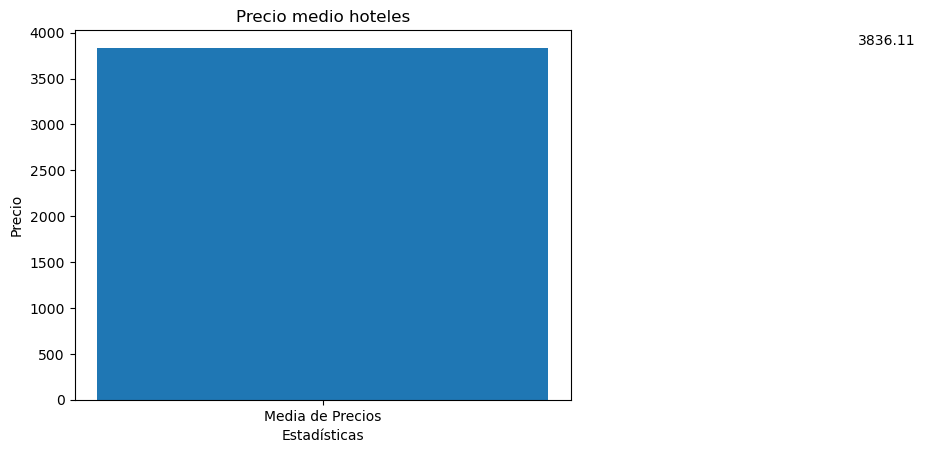

In [81]:
media_precio = df['Precio'].mean()

plt.bar("Media de Precios", media_precio)

plt.title(f'Precio medio hoteles')
plt.xlabel('Estadísticas')
plt.ylabel('Precio')

plt.text("Media de Prcios", media_precio, round(media_precio, 2), ha='center', va='bottom')

# Cantidad de hoteles por agencia

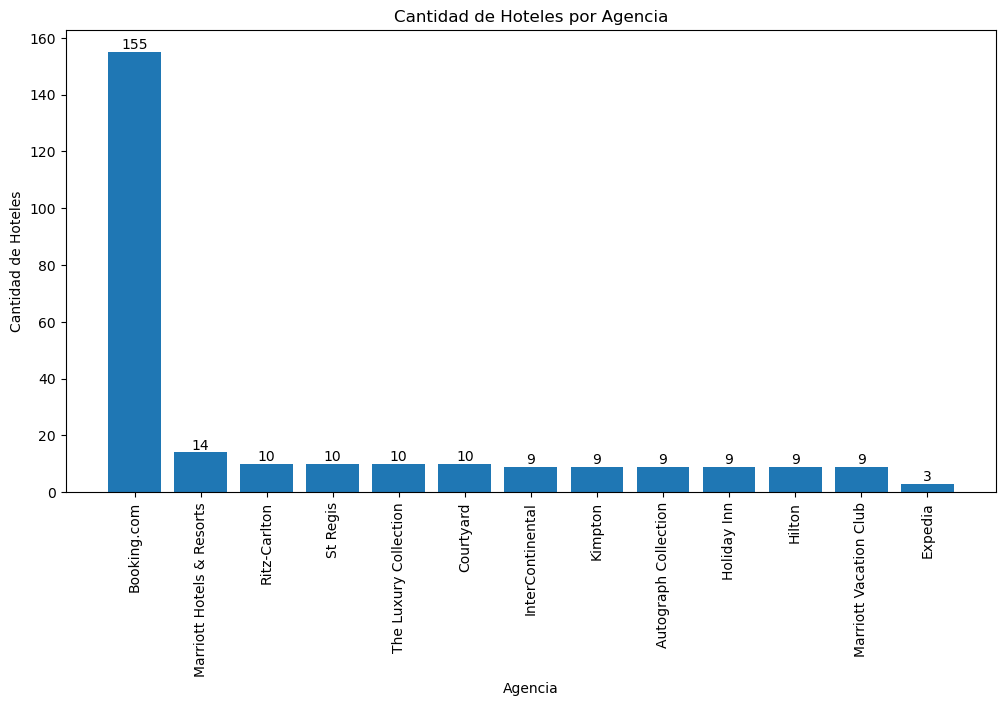

In [84]:
#Saco el nº de hoteles de cada agencia:
numero_agencias = df['Agencia'].value_counts()

# Convierto a un DataFrame
numero_agencias_df = numero_agencias.reset_index()
numero_agencias_df.columns = ['Agencia', 'Cantidad de Hoteles']

# Ordeno el DataFrame por la cantidad de hoteles en orden descendente
numero_agencias_df = numero_agencias_df.sort_values(by='Cantidad de Hoteles', ascending=False)

# Creo gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(numero_agencias_df['Agencia'], numero_agencias_df['Cantidad de Hoteles'])
plt.xlabel('Agencia')
plt.ylabel('Cantidad de Hoteles')
plt.title('Cantidad de Hoteles por Agencia')
plt.xticks(rotation=90)  # Roto las etiquetas en el eje x 

# Agrego los números exactos de hoteles en cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

In [7]:
df.head(1)

Unnamed: 0                           Nombre  \
0           0  The Ritz-Carlton, San Francisco   

                                      Ubicación     CP  Estrellas  Puntuación  \
0  600 Stockton Street, San Francisco, CA 94104  94104          5         9.0   

  Valoración  Num_Opiniones  Precio       Agencia  
0  Excelente            376    6766  Ritz-Carlton

### Análisis de la Relación entre Valoración y Número de Opiniones por Estrellas 

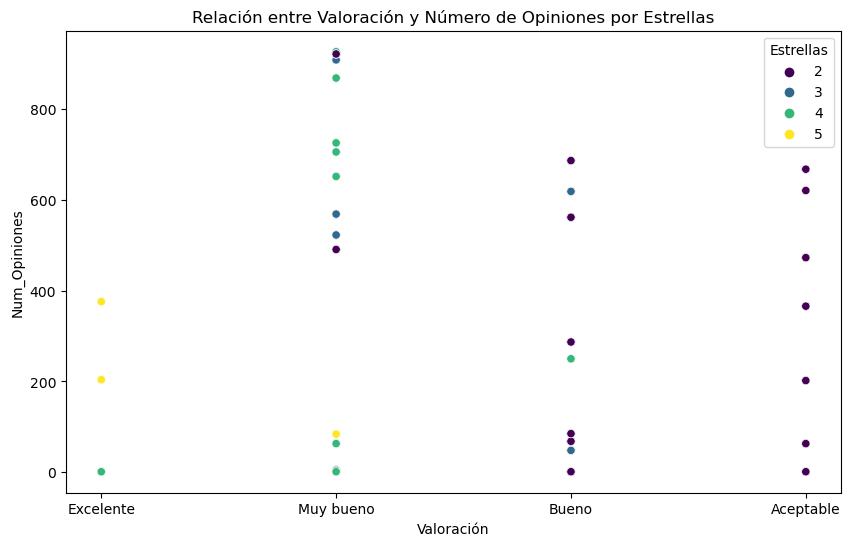

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Valoración", y="Num_Opiniones", hue="Estrellas", palette="viridis")
plt.xlabel("Valoración")
plt.ylabel("Num_Opiniones")
plt.title("Relación entre Valoración y Número de Opiniones por Estrellas")
plt.show()

## Relacion entre precio del hotel y puntuacion

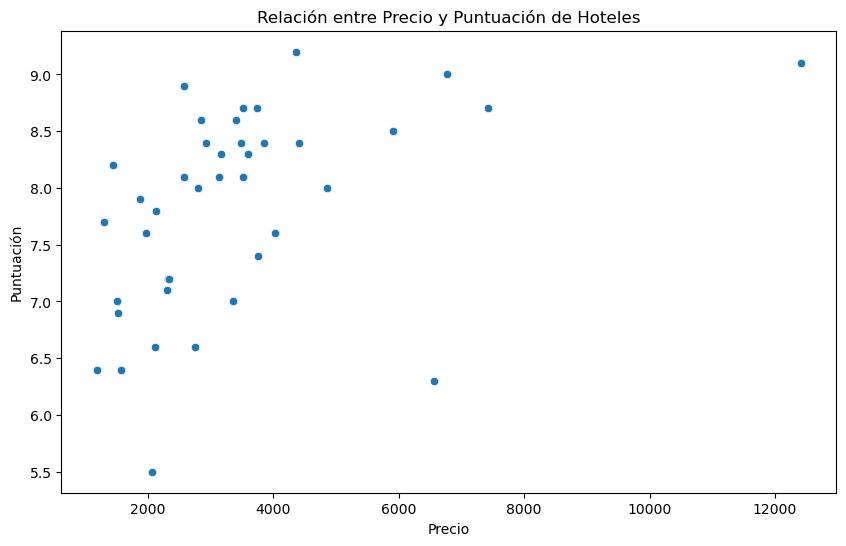

In [22]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Precio", y="Puntuación")
plt.xlabel("Precio")
plt.ylabel("Puntuación")
plt.title("Relación entre Precio y Puntuación de Hoteles")
plt.show()


In [23]:
df.head(1)

Unnamed: 0                           Nombre  \
0           0  The Ritz-Carlton, San Francisco   

                                      Ubicación     CP  Estrellas  Puntuación  \
0  600 Stockton Street, San Francisco, CA 94104  94104          5         9.0   

  Valoración  Num_Opiniones  Precio       Agencia  
0  Excelente            376    6766  Ritz-Carlton

# Distribucion de estrellas

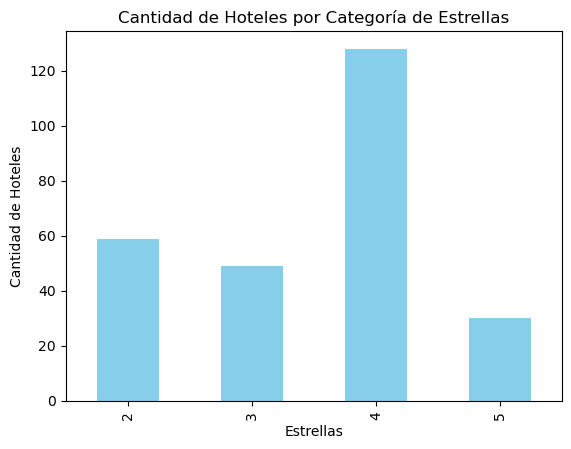

In [12]:

# Contar la cantidad de hoteles por categoría de estrellas
cantidad_hoteles_por_estrellas = df['Estrellas'].value_counts()

# Ordenar el índice para asegurar que el gráfico esté en orden
cantidad_hoteles_por_estrellas = cantidad_hoteles_por_estrellas.sort_index()

# Graficar
cantidad_hoteles_por_estrellas.plot(kind='bar', color='skyblue')
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de Hoteles')
plt.title('Cantidad de Hoteles por Categoría de Estrellas')
plt.show()

# Relacion entre valoracion y numero de opiniones

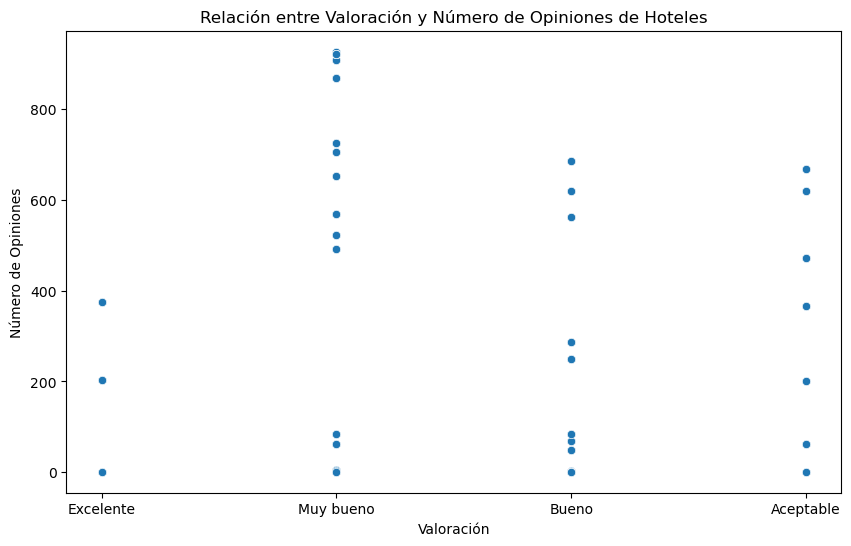

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Valoración", y="Num_Opiniones")
plt.xlabel("Valoración")
plt.ylabel("Número de Opiniones")
plt.title("Relación entre Valoración y Número de Opiniones de Hoteles")
plt.show()

# Distribucion de precion por estrellas

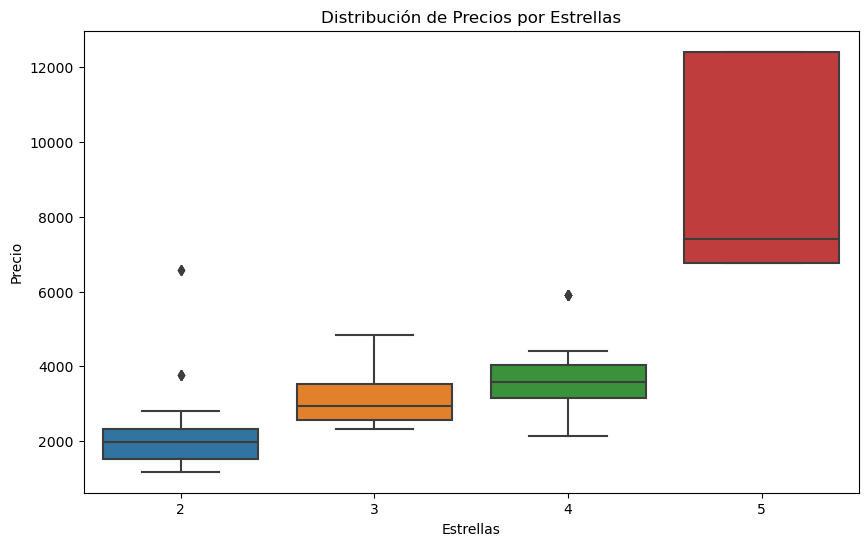

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Estrellas", y="Precio")
plt.xlabel("Estrellas")
plt.ylabel("Precio")
plt.title("Distribución de Precios por Estrellas")
plt.show()

In [28]:
df.head(1)

Unnamed: 0                           Nombre  \
0           0  The Ritz-Carlton, San Francisco   

                                      Ubicación     CP  Estrellas  Puntuación  \
0  600 Stockton Street, San Francisco, CA 94104  94104          5         9.0   

  Valoración  Num_Opiniones  Precio       Agencia  
0  Excelente            376    6766  Ritz-Carlton

# Comparacion de precios entre agencias

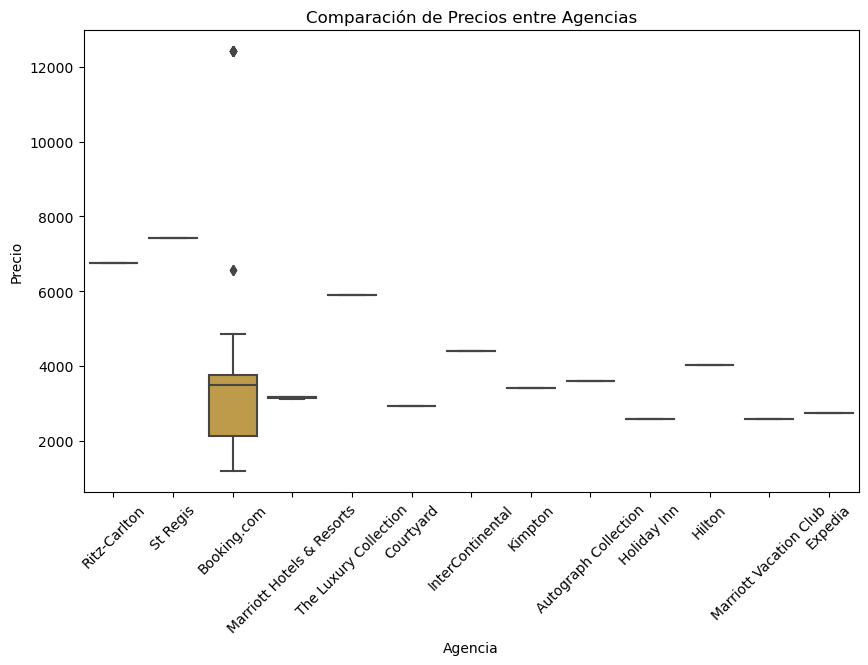

In [29]:


plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Agencia", y="Precio")
plt.xticks(rotation=45)
plt.xlabel("Agencia")
plt.ylabel("Precio")
plt.title("Comparación de Precios entre Agencias")
plt.show()


In [30]:
df.head(1)

Unnamed: 0                           Nombre  \
0           0  The Ritz-Carlton, San Francisco   

                                      Ubicación     CP  Estrellas  Puntuación  \
0  600 Stockton Street, San Francisco, CA 94104  94104          5         9.0   

  Valoración  Num_Opiniones  Precio       Agencia  
0  Excelente            376    6766  Ritz-Carlton

In [31]:
df.head(1)

Unnamed: 0                           Nombre  \
0           0  The Ritz-Carlton, San Francisco   

                                      Ubicación     CP  Estrellas  Puntuación  \
0  600 Stockton Street, San Francisco, CA 94104  94104          5         9.0   

  Valoración  Num_Opiniones  Precio       Agencia  
0  Excelente            376    6766  Ritz-Carlton

### Comparación de Valoración entre Hoteles de Diferentes Estrellas 


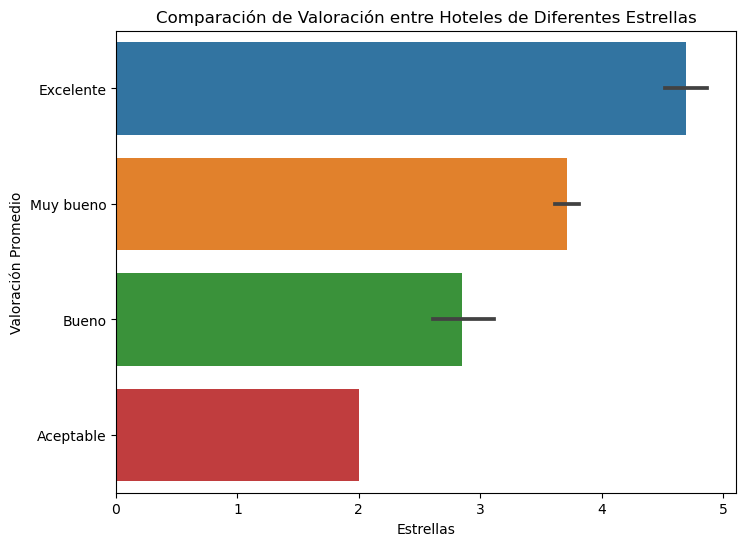

In [32]:

plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="Estrellas", y="Valoración")
plt.xlabel("Estrellas")
plt.ylabel("Valoración Promedio")
plt.title("Comparación de Valoración entre Hoteles de Diferentes Estrellas")
plt.show()


# Precio promedio por categoría de estrellas


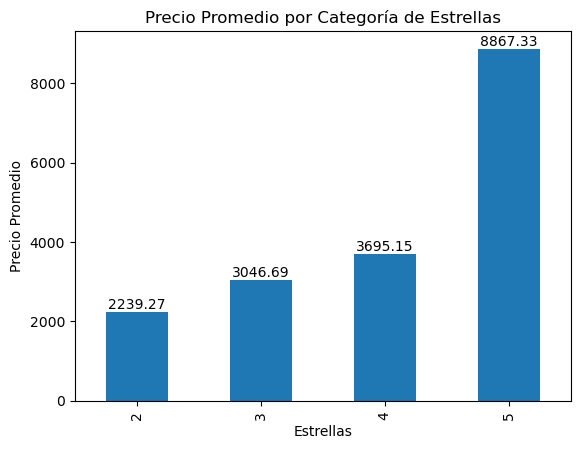

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

promedio_precios = df.groupby('Estrellas')['Precio'].mean()


fig, ax = plt.subplots()

promedio_precios.plot(kind='bar', ax=ax)


for i, valor in enumerate(promedio_precios):
    ax.text(i, valor, f'{valor:.2f}', ha='center', va='bottom')


plt.xlabel('Estrellas')
plt.ylabel('Precio Promedio')
plt.title('Precio Promedio por Categoría de Estrellas')

plt.show()

In [526]:
!pip install geopy

  Obtaining dependency information for geopy from https://files.pythonhosted.org/packages/e1/58/9289c6a03116025cdb61461d99b2493daa4967a80b13755463d71a0affeb/geopy-2.4.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 2.8 MB/s eta 0:00:00MB/s eta 0:00:01


## A PARTIR DE UBICACIÓ SACO LOS DATOS DE LATITUD Y LONGITUD

In [75]:
from geopy.geocoders import Nominatim

# Inicio un geocodificador de Nominatim
geolocator = Nominatim(user_agent="myGeocoder")

# Función para geocodificar una dirección y obtener las coordenadas:
def geocode_address(address):
    location = geolocator.geocode(address)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Aplico la función al DataFrame y creo nuevas columnas para latitud y longitud
df['Latitud'], df['Longitud'] = zip(*df['Ubicación'].apply(geocode_address))

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=125+3rd+Street%2C+San+Francisco%2C+CA+94103&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

In [94]:
df

Unnamed: 0                                    Nombre  \
0             0           The Ritz-Carlton, San Francisco   
1             1               The St. Regis San Francisco   
2             2              Stanford Court San Francisco   
3             3              Hotel Caza Fisherman's Wharf   
4             4        Beacon Grand, A Union Square Hotel   
..          ...                                       ...   
261         261                               Ram's Hotel   
262         262        Signature Inn San Francisco Marina   
263         263                      The Lodge at Tiburon   
264         264  San Francisco Marriott Fisherman's Wharf   
265         265                        Inn At Golden Gate   

                                          Ubicación     CP  Estrellas  \
0      600 Stockton Street, San Francisco, CA 94104  94104          5   
1           125 3rd Street, San Francisco, CA 94103  94103          5   
2    905 California Street, San Francisco, CA 94108  94108          4   
3     1300 Columbus Avenue, San Francisco, CA 94133  94133          4   
4        450 Powell Street, San Francisco, CA 94102  94102          4   
..                                              ...    ...        ...   
261          80 9th Street, San Francisco, CA 94103  94103          2   
262    2440 Lombard Street, San Francisco, CA 94123  94123          2   
263       1651 Tiburon Boulevard, Tiburon, CA 94920  94920          3   
264   1250 Columbus Avenue, San Francisco, CA 94133  94133          4   
265    2707 Lombard Street, San Francisco, CA 94123  94123          2   

     Puntuación Valoración  Num_Opiniones  Precio                    Agencia  \
0           9.0  Excelente            376    6766               Ritz-Carlton   
1           8.7  Muy bueno             84    7418                   St Regis   
2           8.6  Muy bueno              2    2842                Booking.com   
3           8.4  Muy bueno              2    3478                Booking.com   
4           8.7  Muy bueno              1    3742                Booking.com   
..          ...        ...            ...     ...                        ...   
261         7.1      Bueno             85    2304                Booking.com   
262         6.3  Aceptable            668    6564                Booking.com   
263         8.0  Muy bueno            523    4851                Booking.com   
264         8.1  Muy bueno            652    3125  Marriott Hotels & Resorts   
265         7.2      Bueno            687    2335                Booking.com   

       Latitud    Longitud  
0    37.791469 -122.407325  
1    37.786023 -122.401591  
2    37.791484 -122.409294  
3    37.806522 -122.417709  
4    37.788813 -122.408393  
..         ...         ...  
261  37.776263 -122.414993  
262  37.799428 -122.441633  
263  37.875004 -122.457576  
264  37.805658 -122.417205  
265  37.798392 -122.446393  

[266 rows x 12 columns]

# Distribución de hoteles por ubicacion

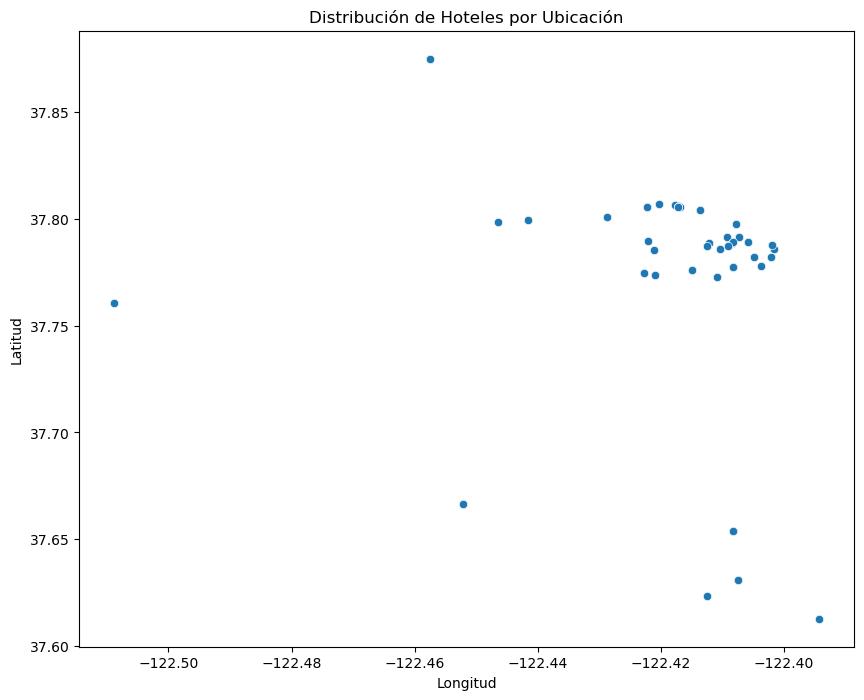

In [95]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="Longitud", y="Latitud", data=df)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Distribución de Hoteles por Ubicación")
plt.show()

# Mapa interactivo con todos los hoteles (con etiquetas)

In [96]:
import folium

In [97]:
m = folium.Map(location=[37.7749, -122.4194], zoom_start=10)

for index, row in df.iterrows():
    folium.Marker([row['Latitud'], row['Longitud']], popup=f"{row['Nombre']}\nPuntuación: {row['Puntuación']}\nValoración: {row['Valoración']}").add_to(m)

In [98]:
m

# Marcador de hoteles según estrellas

In [99]:

#ubicacion san francisco:
m = folium.Map(location=[37.7749, -122.4194], zoom_start=10)

# Itero para agregar marcadores para cada hotel con colores según su número de estrellas
for index, row in df.iterrows():
    estrellas = row['Estrellas']
    if estrellas <= 2:
        color = 'red'
    elif estrellas <= 3:
        color = 'blue'
    elif estrellas <= 4:
        color = 'yellow'
    elif estrellas >= 5:
        color = 'pink'
        
    else:
        color = 'green'
    
    folium.CircleMarker([row['Latitud'], row['Longitud']], radius=5, color=color, fill=True, fill_color=color, fill_opacity=0.7, popup=row['Nombre']).add_to(m)

In [100]:
m

# 4.2 Ciudad: Nueva York

In [13]:
df = pd.read_csv("Data/Filtrado NUEVA YORK_KAYAK.csv")

df

Unnamed: 0                                             Nombre  \
0             0  Hilton Garden Inn Nyc Financial Center/Manhatt...   
1             1                         The Hilton Club - New York   
2             2                                  Moxy NYC Downtown   
3             3                  The Pierre, A Taj Hotel, New York   
4             4                             The St. Regis New York   
..          ...                                                ...   
485         485                                   The Whitby Hotel   
486         486                    The Ritz-Carlton New York NoMad   
487         487           Equinox Hotel Hudson Yards New York City   
488         488       Hilton Garden Inn New York/Manhattan-Chelsea   
489         489                 Element New York Times Square West   

                                           Ubicación  Estrellas  Puntuación  \
0                 6 Water Street, New York, NY 10004          4         8.4   
1    1335 Avenue of The Americas, New York, NY 10019          4         8.6   
2                  26 Ann Street, New York, NY 10038          4         8.1   
3             2 East 61st Street, New York, NY 10065          5         8.3   
4               Two East 55th St, New York, NY 10022          5         8.9   
..                                               ...        ...         ...   
485          18 West 56th Street, New York, NY 10019          5         9.3   
486          25 West 28th Street, New York, NY 10001          5         9.3   
487              33 Hudson Yards, New York, NY 10001          5         9.0   
488    121 West 28th Street, New York, NY 10001-6102          3         8.0   
489         311 West 39th Street, New York, NY 10018          3         7.6   

    Valoración  Num_Opiniones  Precio                 Agencia  
0    Muy bueno          4.252    3897       Hilton Garden Inn  
1    Muy bueno        169.000    4556  Hilton Grand Vacations  
2    Muy bueno        773.000    4159                    Moxy  
3    Muy bueno        649.000   10522             Booking.com  
4    Muy bueno        137.000   12008                St Regis  
..         ...            ...     ...                     ...  
485  Excelente        142.000   13442             Booking.com  
486  Excelente         47.000   13520            Ritz-Carlton  
487  Excelente        374.000   12049                 Expedia  
488  Muy bueno          4.052    5354       Hilton Garden Inn  
489      Bueno          6.960    4199             Booking.com  

[490 rows x 9 columns]

Text(Media de Prcios, 7692.736734693877, '7692.74')

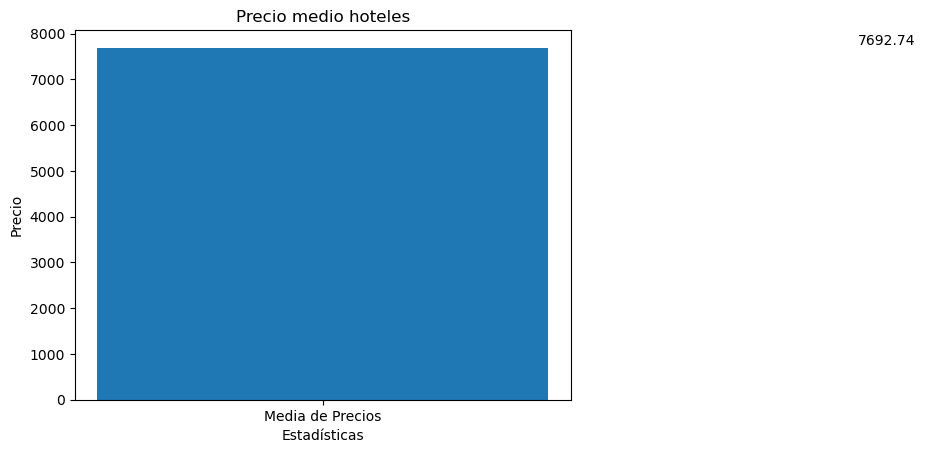

In [19]:
media_precio = df['Precio'].mean()

plt.bar("Media de Precios", media_precio)

plt.title(f'Precio medio hoteles')
plt.xlabel('Estadísticas')
plt.ylabel('Precio')

plt.text("Media de Prcios", media_precio, round(media_precio, 2), ha='center', va='bottom')

# Cantidad de hoteles por agencia

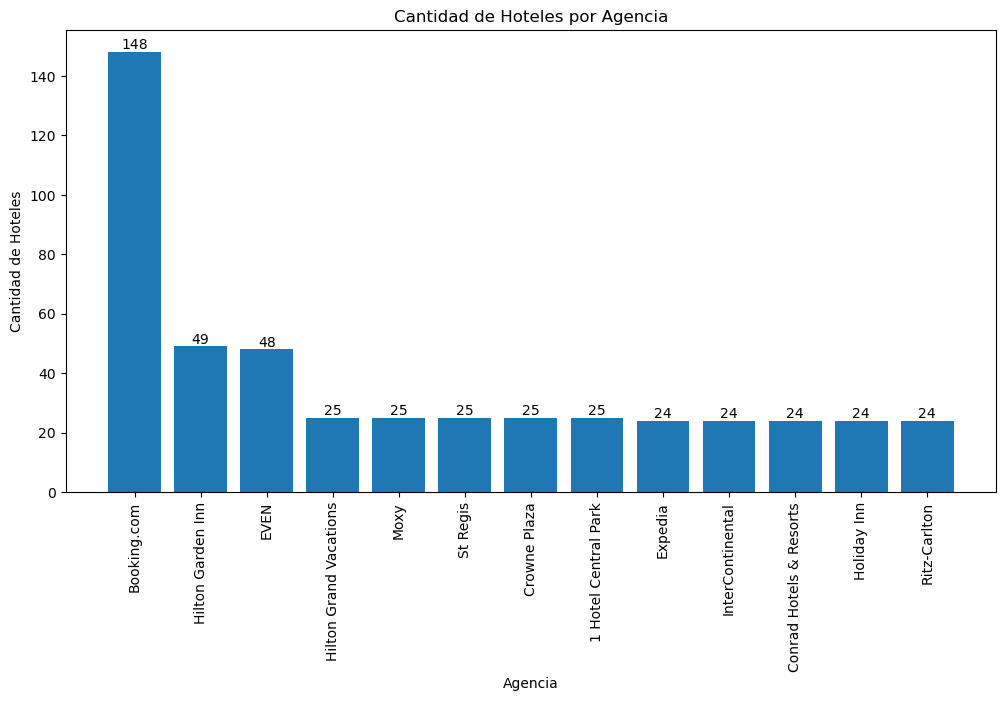

In [463]:
#Saco el nº de hoteles de cada agencia:
numero_agencias = df['Agencia'].value_counts()

# Convierto a un DataFrame
numero_agencias_df = numero_agencias.reset_index()
numero_agencias_df.columns = ['Agencia', 'Cantidad de Hoteles']

# Ordeno el DataFrame por la cantidad de hoteles en orden descendente
numero_agencias_df = numero_agencias_df.sort_values(by='Cantidad de Hoteles', ascending=False)

# Creo gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(numero_agencias_df['Agencia'], numero_agencias_df['Cantidad de Hoteles'])
plt.xlabel('Agencia')
plt.ylabel('Cantidad de Hoteles')
plt.title('Cantidad de Hoteles por Agencia')
plt.xticks(rotation=90)  # Roto las etiquetas en el eje x 

# Agrego los números exactos de hoteles en cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

### Análisis de la Relación entre Valoración y Número de Opiniones por Estrellas

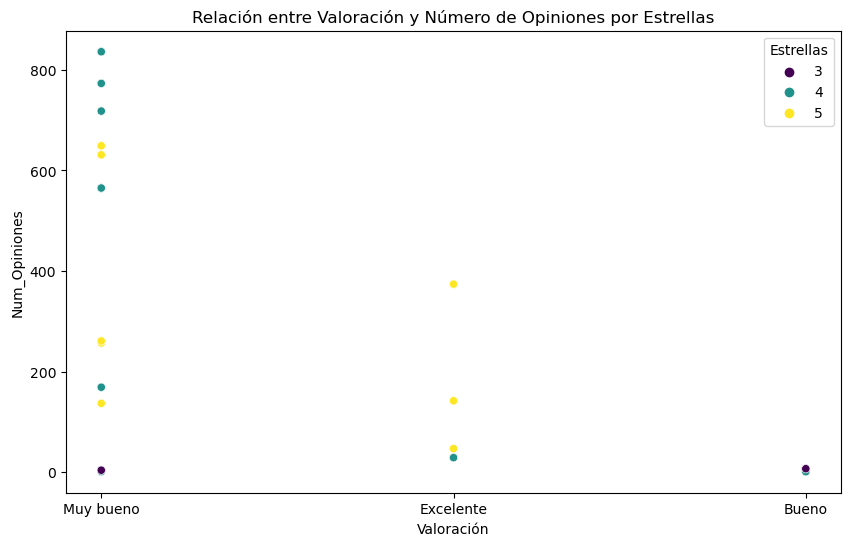

In [464]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Valoración", y="Num_Opiniones", hue="Estrellas", palette="viridis")
plt.xlabel("Valoración")
plt.ylabel("Num_Opiniones")
plt.title("Relación entre Valoración y Número de Opiniones por Estrellas")
plt.show()

# Comparacion de precios entre agencias

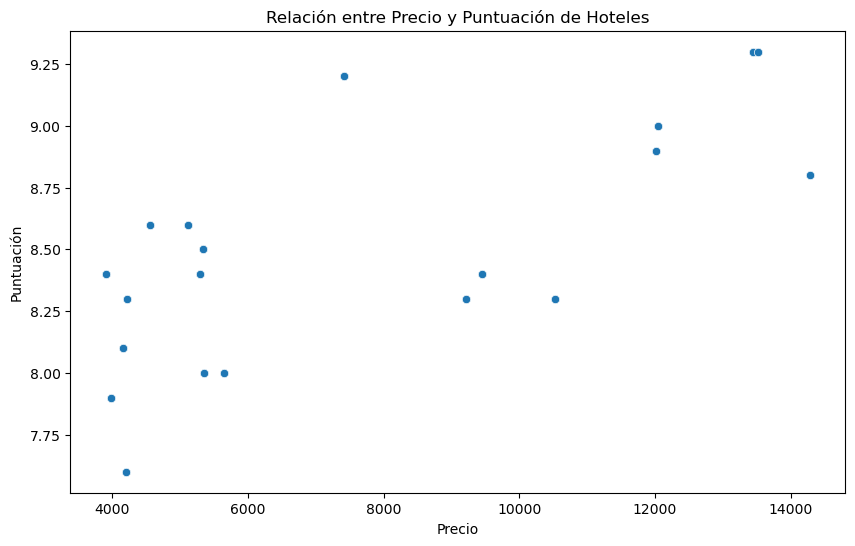

In [387]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Precio", y="Puntuación")
plt.xlabel("Precio")
plt.ylabel("Puntuación")
plt.title("Relación entre Precio y Puntuación de Hoteles")
plt.show()


# Distribucion de estrellas

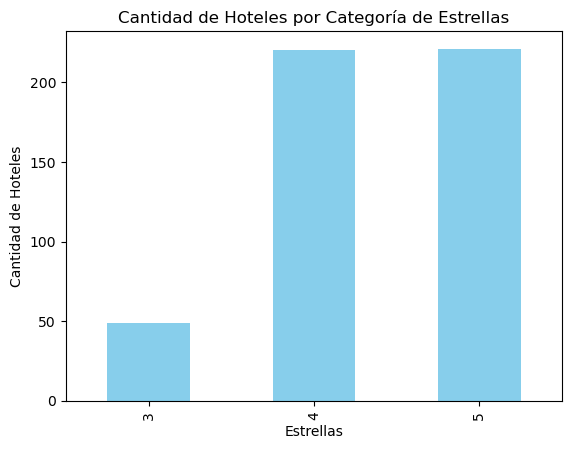

In [14]:
# Contar la cantidad de hoteles por categoría de estrellas
cantidad_hoteles_por_estrellas = df['Estrellas'].value_counts()

# Ordenar el índice para asegurar que el gráfico esté en orden
cantidad_hoteles_por_estrellas = cantidad_hoteles_por_estrellas.sort_index()

# Graficar
cantidad_hoteles_por_estrellas.plot(kind='bar', color='skyblue')
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de Hoteles')
plt.title('Cantidad de Hoteles por Categoría de Estrellas')
plt.show()

# Relacion entre valoracion y numero de opiniones

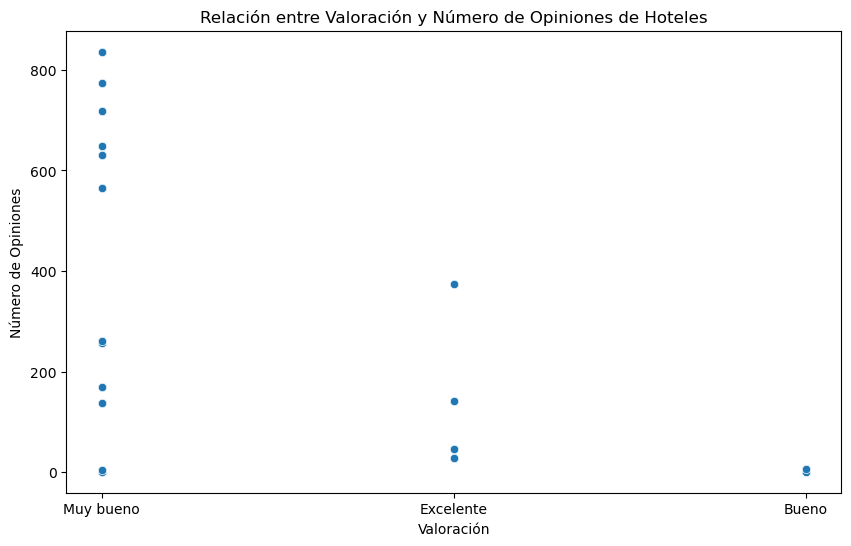

In [390]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Valoración", y="Num_Opiniones")
plt.xlabel("Valoración")
plt.ylabel("Número de Opiniones")
plt.title("Relación entre Valoración y Número de Opiniones de Hoteles")
plt.show()

# Distribucion de precios por estrellas

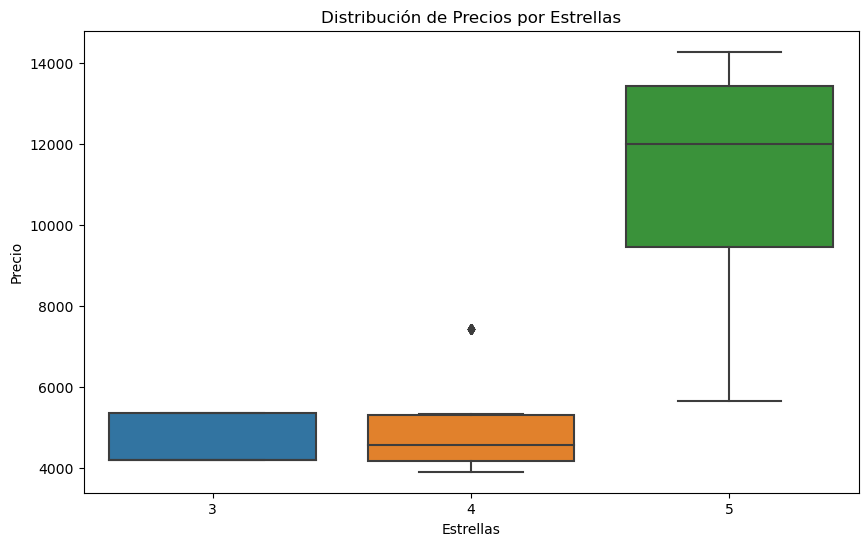

In [391]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Estrellas", y="Precio")
plt.xlabel("Estrellas")
plt.ylabel("Precio")
plt.title("Distribución de Precios por Estrellas")
plt.show()

# Comparacion de precios entre agencias

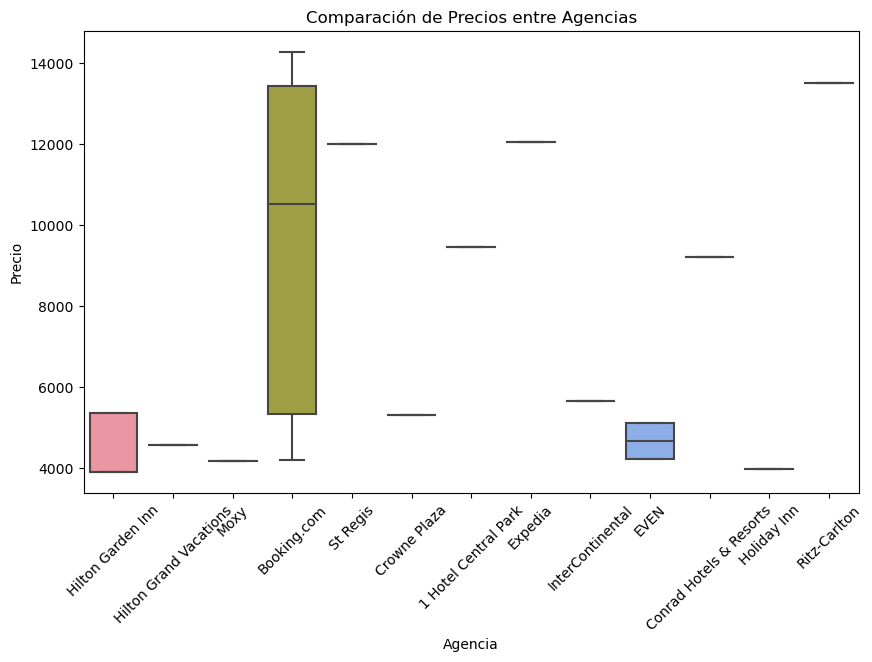

In [392]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Agencia", y="Precio")
plt.xticks(rotation=45)
plt.xlabel("Agencia")
plt.ylabel("Precio")
plt.title("Comparación de Precios entre Agencias")
plt.show()

### Comparación de Valoración entre Hoteles de Diferentes Estrellas

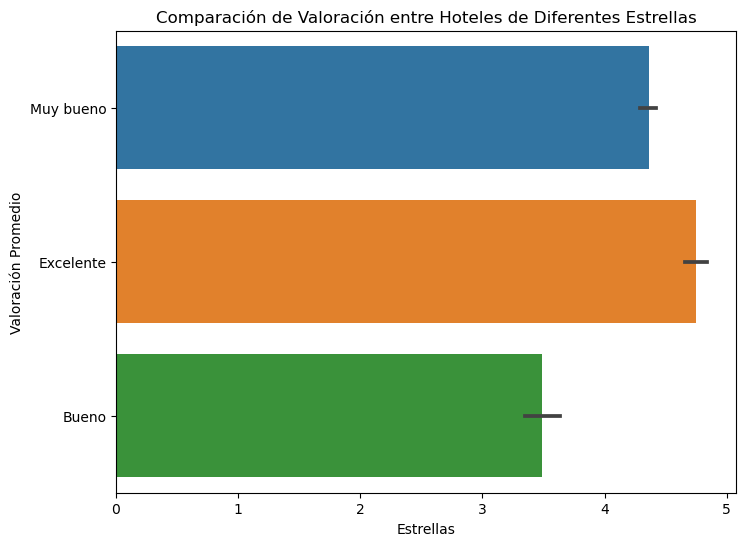

In [393]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="Estrellas", y="Valoración")
plt.xlabel("Estrellas")
plt.ylabel("Valoración Promedio")
plt.title("Comparación de Valoración entre Hoteles de Diferentes Estrellas")
plt.show()


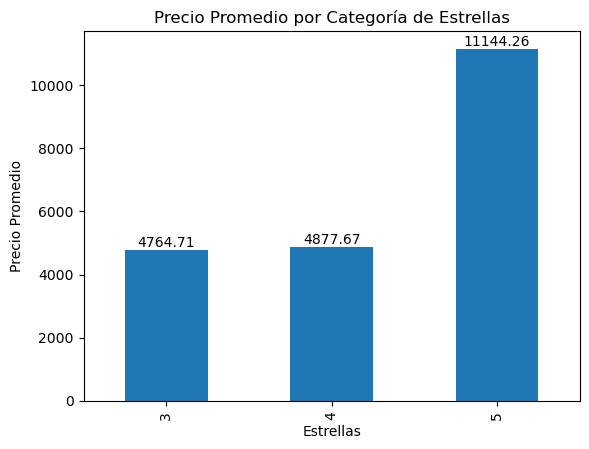

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

promedio_precios = df.groupby('Estrellas')['Precio'].mean()


fig, ax = plt.subplots()

promedio_precios.plot(kind='bar', ax=ax)


for i, valor in enumerate(promedio_precios):
    ax.text(i, valor, f'{valor:.2f}', ha='center', va='bottom')


plt.xlabel('Estrellas')
plt.ylabel('Precio Promedio')
plt.title('Precio Promedio por Categoría de Estrellas')

plt.show()

In [ ]:
from geopy.geocoders import Nominatim

# Inicio un geocodificador de Nominatim
geolocator = Nominatim(user_agent="myGeocoder")

# Función para geocodificar una dirección y obtener las coordenadas:
def geocode_address(address):
    location = geolocator.geocode(address)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Aplico la función al DataFrame y creo nuevas columnas para latitud y longitud
df['Latitud'], df['Longitud'] = zip(*df['Ubicación'].apply(geocode_address))

# Distribución de hoteles por ubicacion

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="Longitud", y="Latitud", data=df)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Distribución de Hoteles por Ubicación")
plt.show()

In [ ]:
m = folium.Map(location=[00.000, -000.000], zoom_start=10)

df=df.dropna(subset=["Latitud", "Longitud"])


for index, row in df.iterrows():
    folium.Marker([row['Latitud'], row['Longitud']], popup=f"{row['Nombre']}\nPuntuación: {row['Puntuación']}\nValoración: {row['Valoración']}").add_to(m)

# Marcador de hoteles según estrellas

In [ ]:
m = folium.Map(location=[37.7749, -122.4194], zoom_start=10)

df=df.dropna(subset=["Latitud", "Longitud"])


# Itero para agregar marcadores para cada hotel con colores según su número de estrellas
for index, row in df.iterrows():
    estrellas = row['Estrellas']
    if estrellas <= 2:
        color = 'red'
    elif estrellas <= 3:
        color = 'blue'
    elif estrellas <= 4:
        color = 'yellow'
    elif estrellas >= 5:
        color = 'pink'
        
    else:
        color = 'green'
    
    folium.CircleMarker([row['Latitud'], row['Longitud']], radius=5, color=color, fill=True, fill_color=color, fill_opacity=0.7, popup=row['Nombre']).add_to(m)

# 4.3 Ciudad: Londres

In [15]:
df = pd.read_csv("Data/FILTRADO Londres_KAYAK.csv")

df

Unnamed: 0                                             Nombre  \
0            0                   Hotel Xenia Autograph Collection   
1            1                    Sheraton Grand London Park Lane   
2            2                             Grosvenor House Suites   
3            3                   Nobu Hotel London Portman Square   
4            4                     The Piccadilly London West End   
5            5              F6 Greek Street by City Living London   
6            6  The May Fair, A Radisson Collection Hotel, May...   
7            7                Montcalm East, Autograph Collection   
8            8                    Sheraton Grand London Park Lane   
9            9                             Ruby Lucy Hotel London   
10          10                          Citadines Barbican London   
11          11                          Novotel London Paddington   
12          12  Holiday Inn Express London-Royal Docks, Docklands   
13          13                             The Marble Arch London   
14          14                                  The Leonard Hotel   
15          15                          Citadines Barbican London   
16          16                                  The Leonard Hotel   
17          17  Andaz London Liverpool Street - a concept by H...   
18          18                               The Selwyn, Richmond   
19          19                          Novotel London Paddington   
20          20  Andaz London Liverpool Street - a concept by H...   
21          21                        Novotel London Tower Bridge   
22          22                                  The Leonard Hotel   
23          23          The BoTree - Preferred Hotels and Resorts   
24          24                          Citadines Barbican London   
25          25         Eldon Chambers Pod 7 by City Living London   
26          26                        Novotel London Tower Bridge   
27          27          The BoTree - Preferred Hotels and Resorts   
28          28                 JW Marriott Grosvenor House London   
29          29                             Ruby Lucy Hotel London   
30          30                               The Selwyn, Richmond   
31          31                           The Westbourne Hyde Park   
32          32         Eldon Chambers Pod 7 by City Living London   
33          33          The BoTree - Preferred Hotels and Resorts   
34          34                                       Nomad London   
35          35         Eldon Chambers Pod 3 by City Living London   
36          36                               The Selwyn, Richmond   
37          37                            Conrad London St. James   
38          38  Holiday Inn Express London-Royal Docks, Docklands   
39          39          The BoTree - Preferred Hotels and Resorts   
40          40                    Crowne Plaza London Heathrow T4   
41          41                          Citadines Barbican London   
42          42                           The Westbourne Hyde Park   

                                           Ubicación  Estrellas  Puntuación  \
0                 160 Cromwell Road, London, SW5 0TL          4         8.5   
1                        Piccadilly, London, W1J 7BX          5         8.2   
2                      86 Park Lane, London, W1K 7TN          5         9.1   
3                 22 Portman Square, London, W1H 7BG          5         8.6   
4          65-73 Shaftesbury Avenue, London, W1D 6EX          5         8.0   
5                                               Soho          0         8.6   
6          Stratton Street, Mayfair, London, W1J 8LT          5         8.1   
7                151-157 City Road, London, EC1V 1JS          5         8.6   
8                        Piccadilly, London, W1J 7BX          5         8.2   
9                   100 Lower Marsh, London, SE1 7AB          4         8.8   
10               7-21 Goswell Road, London, EC1M 7AH          4         8.2   
11  3 Kingdom Stree

Text(Media de Prcios, 4258.720930232558, '4258.72')

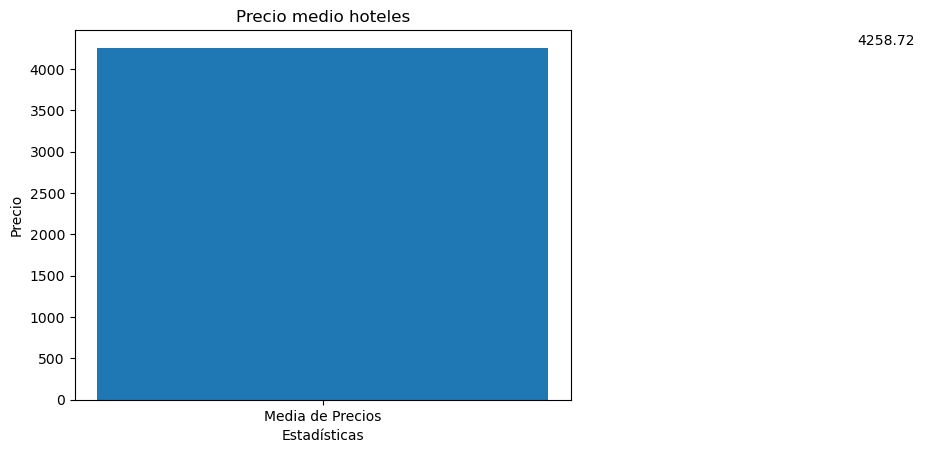

In [21]:
media_precio = df['Precio'].mean()

plt.bar("Media de Precios", media_precio)

plt.title(f'Precio medio hoteles')
plt.xlabel('Estadísticas')
plt.ylabel('Precio')

plt.text("Media de Prcios", media_precio, round(media_precio, 2), ha='center', va='bottom')

# Cantidad de hoteles por agencia

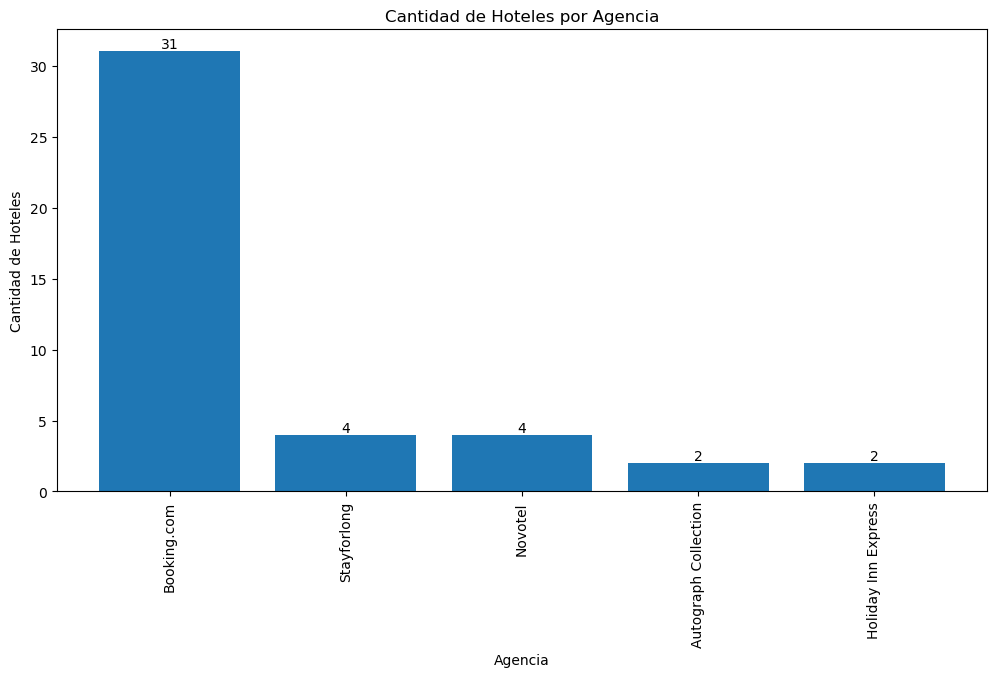

In [400]:
#Saco el nº de hoteles de cada agencia:
numero_agencias = df['Agencia'].value_counts()

# Convierto a un DataFrame
numero_agencias_df = numero_agencias.reset_index()
numero_agencias_df.columns = ['Agencia', 'Cantidad de Hoteles']

# Ordeno el DataFrame por la cantidad de hoteles en orden descendente
numero_agencias_df = numero_agencias_df.sort_values(by='Cantidad de Hoteles', ascending=False)

# Creo gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(numero_agencias_df['Agencia'], numero_agencias_df['Cantidad de Hoteles'])
plt.xlabel('Agencia')
plt.ylabel('Cantidad de Hoteles')
plt.title('Cantidad de Hoteles por Agencia')
plt.xticks(rotation=90)  # Roto las etiquetas en el eje x 

# Agrego los números exactos de hoteles en cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

### Análisis de la Relación entre Valoración y Número de Opiniones por Estrellas

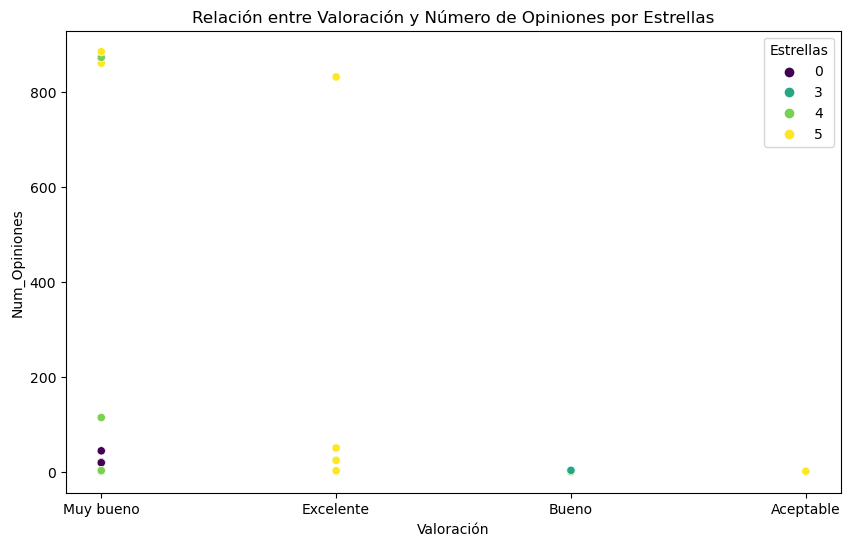

In [401]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Valoración", y="Num_Opiniones", hue="Estrellas", palette="viridis")
plt.xlabel("Valoración")
plt.ylabel("Num_Opiniones")
plt.title("Relación entre Valoración y Número de Opiniones por Estrellas")
plt.show()

## Relacion entre precio del hotel y puntuacion

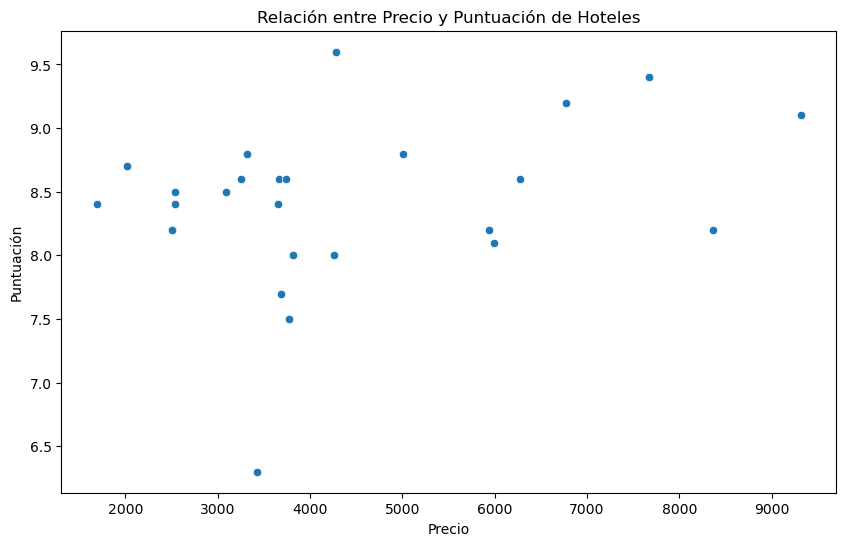

In [402]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Precio", y="Puntuación")
plt.xlabel("Precio")
plt.ylabel("Puntuación")
plt.title("Relación entre Precio y Puntuación de Hoteles")
plt.show()


# Distribucion de estrellas

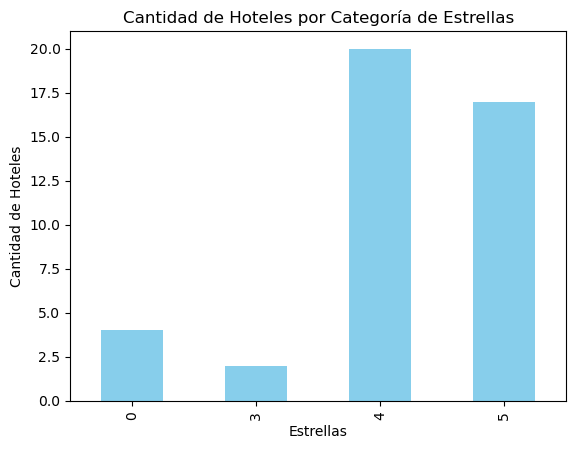

In [16]:
# Contar la cantidad de hoteles por categoría de estrellas
cantidad_hoteles_por_estrellas = df['Estrellas'].value_counts()

# Ordenar el índice para asegurar que el gráfico esté en orden
cantidad_hoteles_por_estrellas = cantidad_hoteles_por_estrellas.sort_index()

# Graficar
cantidad_hoteles_por_estrellas.plot(kind='bar', color='skyblue')
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de Hoteles')
plt.title('Cantidad de Hoteles por Categoría de Estrellas')
plt.show()

# Relacion entre valoracion y numero de opiniones

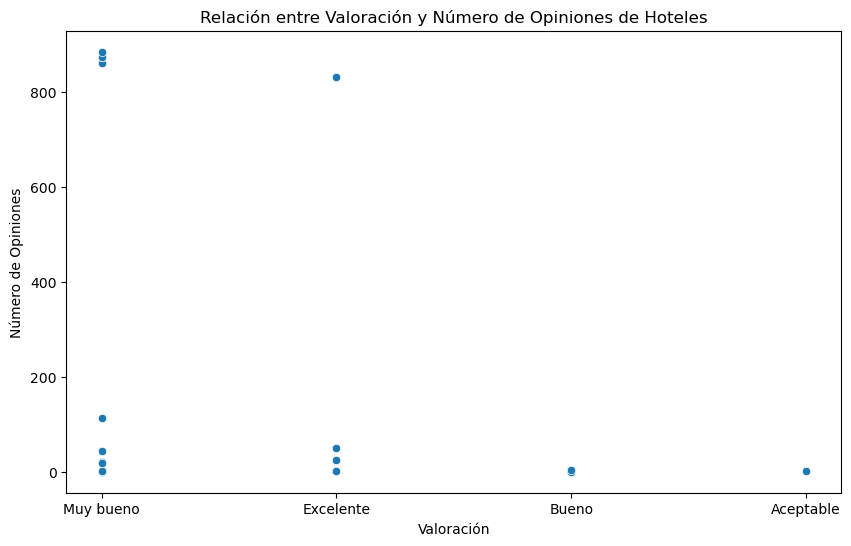

In [404]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Valoración", y="Num_Opiniones")
plt.xlabel("Valoración")
plt.ylabel("Número de Opiniones")
plt.title("Relación entre Valoración y Número de Opiniones de Hoteles")
plt.show()

# Distribucion de precios por estrellas

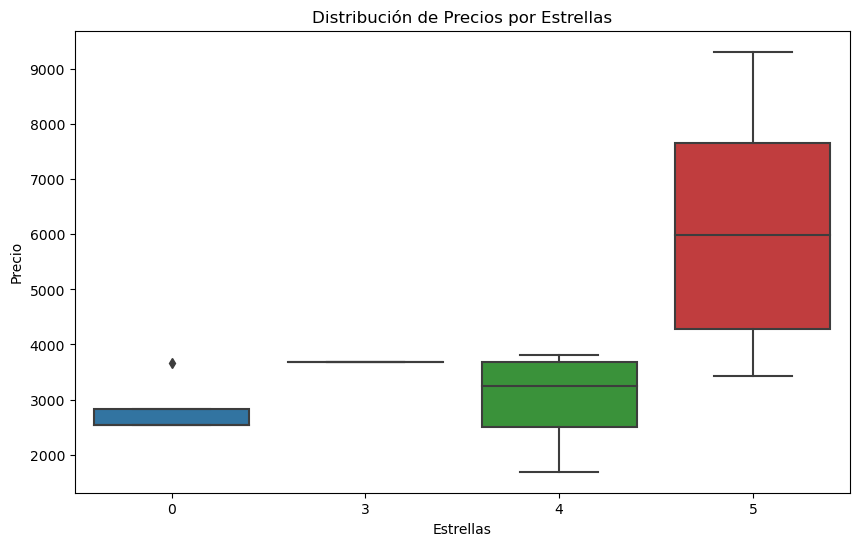

In [405]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Estrellas", y="Precio")
plt.xlabel("Estrellas")
plt.ylabel("Precio")
plt.title("Distribución de Precios por Estrellas")
plt.show()

# Comparacion de precios entre agencias

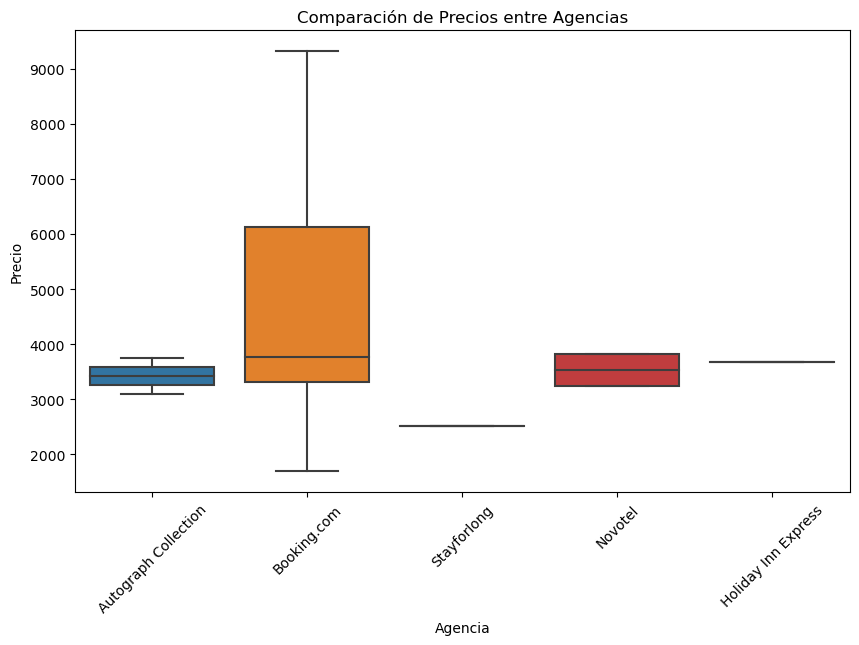

In [406]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Agencia", y="Precio")
plt.xticks(rotation=45)
plt.xlabel("Agencia")
plt.ylabel("Precio")
plt.title("Comparación de Precios entre Agencias")
plt.show()

### Comparación de Valoración entre Hoteles de Diferentes Estrellas

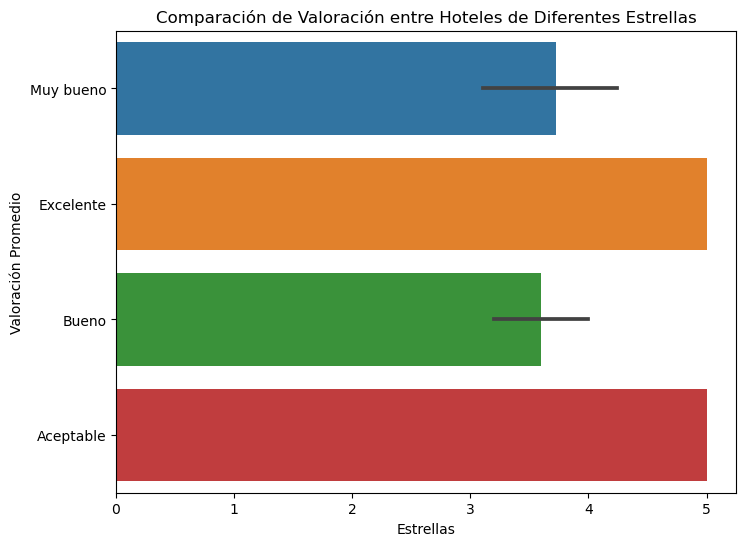

In [407]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="Estrellas", y="Valoración")
plt.xlabel("Estrellas")
plt.ylabel("Valoración Promedio")
plt.title("Comparación de Valoración entre Hoteles de Diferentes Estrellas")
plt.show()


# Precio promedio por categoría de estrellas

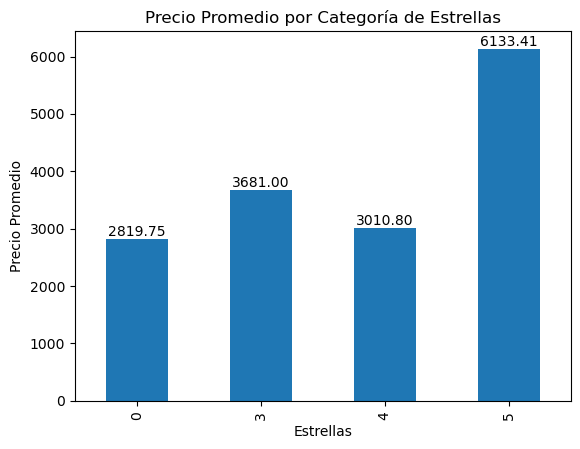

In [44]:

promedio_precios = df.groupby('Estrellas')['Precio'].mean()


fig, ax = plt.subplots()

promedio_precios.plot(kind='bar', ax=ax)


for i, valor in enumerate(promedio_precios):
    ax.text(i, valor, f'{valor:.2f}', ha='center', va='bottom')


plt.xlabel('Estrellas')
plt.ylabel('Precio Promedio')
plt.title('Precio Promedio por Categoría de Estrellas')

plt.show()

In [477]:
df

Unnamed: 0                                             Nombre  \
0            0                   Hotel Xenia Autograph Collection   
1            1                    Sheraton Grand London Park Lane   
2            2                             Grosvenor House Suites   
3            3                   Nobu Hotel London Portman Square   
4            4                     The Piccadilly London West End   
5            5              F6 Greek Street by City Living London   
6            6  The May Fair, A Radisson Collection Hotel, May...   
7            7                Montcalm East, Autograph Collection   
8            8                    Sheraton Grand London Park Lane   
9            9                             Ruby Lucy Hotel London   
10          10                          Citadines Barbican London   
11          11                          Novotel London Paddington   
12          12  Holiday Inn Express London-Royal Docks, Docklands   
13          13                             The Marble Arch London   
14          14                                  The Leonard Hotel   
15          15                          Citadines Barbican London   
16          16                                  The Leonard Hotel   
17          17  Andaz London Liverpool Street - a concept by H...   
18          18                               The Selwyn, Richmond   
19          19                          Novotel London Paddington   
20          20  Andaz London Liverpool Street - a concept by H...   
21          21                        Novotel London Tower Bridge   
22          22                                  The Leonard Hotel   
23          23          The BoTree - Preferred Hotels and Resorts   
24          24                          Citadines Barbican London   
25          25         Eldon Chambers Pod 7 by City Living London   
26          26                        Novotel London Tower Bridge   
27          27          The BoTree - Preferred Hotels and Resorts   
28          28                 JW Marriott Grosvenor House London   
29          29                             Ruby Lucy Hotel London   
30          30                               The Selwyn, Richmond   
31          31                           The Westbourne Hyde Park   
32          32         Eldon Chambers Pod 7 by City Living London   
33          33          The BoTree - Preferred Hotels and Resorts   
34          34                                       Nomad London   
35          35         Eldon Chambers Pod 3 by City Living London   
36          36                               The Selwyn, Richmond   
37          37                            Conrad London St. James   
38          38  Holiday Inn Express London-Royal Docks, Docklands   
39          39          The BoTree - Preferred Hotels and Resorts   
40          40                    Crowne Plaza London Heathrow T4   
41          41                          Citadines Barbican London   
42          42                           The Westbourne Hyde Park   

                                           Ubicación  Estrellas  Puntuación  \
0                 160 Cromwell Road, London, SW5 0TL          4         8.5   
1                        Piccadilly, London, W1J 7BX          5         8.2   
2                      86 Park Lane, London, W1K 7TN          5         9.1   
3                 22 Portman Square, London, W1H 7BG          5         8.6   
4          65-73 Shaftesbury Avenue, London, W1D 6EX          5         8.0   
5                                               Soho          0         8.6   
6          Stratton Street, Mayfair, London, W1J 8LT          5         8.1   
7                151-157 City Road, London, EC1V 1JS          5         8.6   
8                        Piccadilly, London, W1J 7BX          5         8.2   
9                   100 Lower Marsh, London, SE1 7AB          4         8.8   
10               7-21 Goswell Road, London, EC1M 7AH          4         8.2   
11  3 Kingdom Stree

In [473]:
from geopy.geocoders import Nominatim

# Inicio un geocodificador de Nominatim
geolocator = Nominatim(user_agent="myGeocoder")

# Función para geocodificar una dirección y obtener las coordenadas:
def geocode_address(address):
    location = geolocator.geocode(address)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Aplico la función al DataFrame y creo nuevas columnas para latitud y longitud
df['Latitud'], df['Longitud'] = zip(*df['Ubicación'].apply(geocode_address))

In [419]:
df.head(1)

Unnamed: 0                            Nombre  \
0           0  Hotel Xenia Autograph Collection   

                            Ubicación  Estrellas  Puntuación Valoración  \
0  160 Cromwell Road, London, SW5 0TL          4         8.5  Muy bueno   

   Num_Opiniones  Precio               Agencia   Latitud  Longitud  
0          115.0    3090  Autograph Collection  51.49495 -0.189919

# Distribución de hoteles por ubicacion

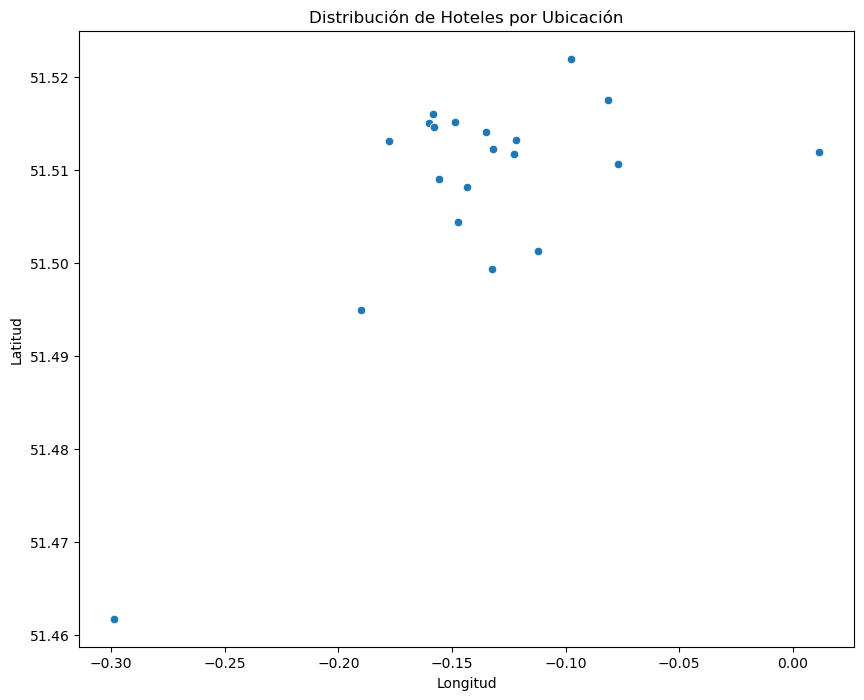

In [410]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="Longitud", y="Latitud", data=df)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Distribución de Hoteles por Ubicación")
plt.show()

# Mapa interactivo con etiquetas

In [479]:
import folium

m = folium.Map(location=[51.5074, -0.1278], zoom_start=10)

df=df.dropna(subset=["Latitud", "Longitud"])

for index, row in df.iterrows():
    folium.Marker([row['Latitud'], row['Longitud']], popup=f"{row['Nombre']}\nPuntuación: {row['Puntuación']}\nValoración: {row['Valoración']}").add_to(m)

In [480]:
m

# Marcador de hoteles según estrellas

In [481]:
m = folium.Map(location=[51.5074, -0.1278], zoom_start=10)

df=df.dropna(subset=["Latitud", "Longitud"])


# Itero para agregar marcadores para cada hotel con colores según su número de estrellas
for index, row in df.iterrows():
    estrellas = row['Estrellas']
    if estrellas <= 2:
        color = 'red'
    elif estrellas <= 3:
        color = 'blue'
    elif estrellas <= 4:
        color = 'yellow'
    elif estrellas >= 5:
        color = 'pink'
        
    else:
        color = 'green'
    
    folium.CircleMarker([row['Latitud'], row['Longitud']], radius=5, color=color, fill=True, fill_color=color, fill_opacity=0.7, popup=row['Nombre']).add_to(m)

In [482]:
m

# 4.4 Ciudad: Paris

In [17]:
df = pd.read_csv("Data/FILTRADO_PARIS_KAYAK.csv")

df

Unnamed: 0                                             Nombre  \
0             0                      Hotel Le Narcisse Blanc & Spa   
1             1  Hôtel de Berri Champs-Élysées, a Luxury Collec...   
2             2                              Hyatt Paris Madeleine   
3             3                                       Hidden Hotel   
4             4                              Mode Paris Aparthotel   
..          ...                                                ...   
487         487                  Best Western Aramis Saint-Germain   
488         488                                         Le Meurice   
489         489            Best Western Plus Hotel Escapade Senlis   
490         490                     Contact Hotel Alizé Montmartre   
491         491                                Moxy Paris Bastille   

                                         Ubicación  Estrellas  Puntuación  \
0    19 Boulevard De La Tour Maubourg, 75007 Paris          5         9.2   
1                  18-22 Rue de Berri, 75008 Paris          5         8.5   
2            24 Boulevard Malesherbes, 75008 Paris          5         8.6   
3        28, Rue de l'Arc de Triomphe, 75017 Paris          4         8.9   
4                      4-6 Rue Leroux, 75116 Paris          4         9.0   
..                                             ...        ...         ...   
487                 124 Rue De Rennes, 75006 Paris          3         8.1   
488                 228 Rue De Rivoli, 75001 Paris          5         9.3   
489     1 Avenue Alain Boucher, 60300 Senlis, Oise          4         8.4   
490                   71 Rue de Douai, 75009 Paris          3         8.2   
491               34, 36 Rue St Sabin, 75011 Paris          3         8.1   

    Valoración  Num_Opiniones  Precio                Agencia  
0    Excelente            489   10248            Booking.com  
1    Muy bueno             77    7922  The Luxury Collection  
2    Muy bueno            309    8664               Trip.com  
3    Muy bueno            874    4471            Booking.com  
4    Excelente            247    3617  Mode Paris Aparthotel  
..         ...            ...     ...                    ...  
487  Muy bueno              1    2852            Booking.com  
488  Excelente            349   24850             Le Meurice  
489  Muy bueno              1    1374            Booking.com  
490  Muy bueno              1    3143            Booking.com  
491  Muy bueno              1    2939            Booking.com  

[492 rows x 9 columns]

# Cantidad de hoteles por agencia

Text(Media de Prcios, 8333.855691056911, '8333.86')

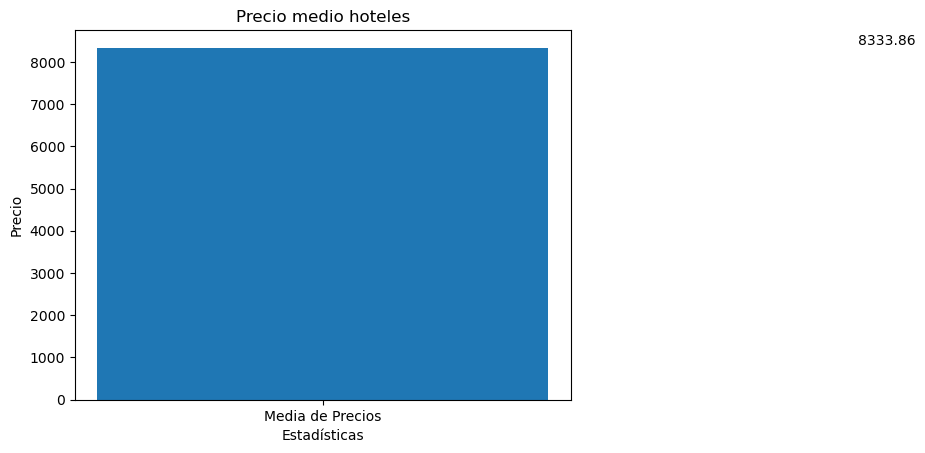

In [23]:
media_precio = df['Precio'].mean()

plt.bar("Media de Precios", media_precio)

plt.title(f'Precio medio hoteles')
plt.xlabel('Estadísticas')
plt.ylabel('Precio')

plt.text("Media de Prcios", media_precio, round(media_precio, 2), ha='center', va='bottom')

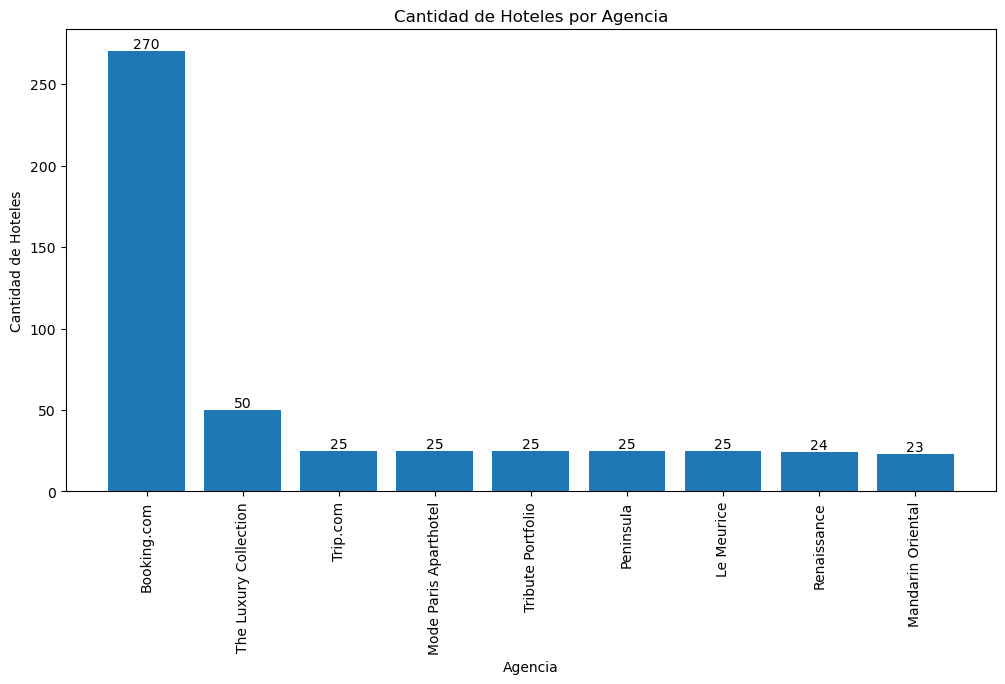

In [484]:
#Saco el nº de hoteles de cada agencia:
numero_agencias = df['Agencia'].value_counts()

# Convierto a un DataFrame
numero_agencias_df = numero_agencias.reset_index()
numero_agencias_df.columns = ['Agencia', 'Cantidad de Hoteles']

# Ordeno el DataFrame por la cantidad de hoteles en orden descendente
numero_agencias_df = numero_agencias_df.sort_values(by='Cantidad de Hoteles', ascending=False)

# Creo gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(numero_agencias_df['Agencia'], numero_agencias_df['Cantidad de Hoteles'])
plt.xlabel('Agencia')
plt.ylabel('Cantidad de Hoteles')
plt.title('Cantidad de Hoteles por Agencia')
plt.xticks(rotation=90)  # Roto las etiquetas en el eje x 

# Agrego los números exactos de hoteles en cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

### Análisis de la Relación entre Valoración y Número de Opiniones por Estrellas

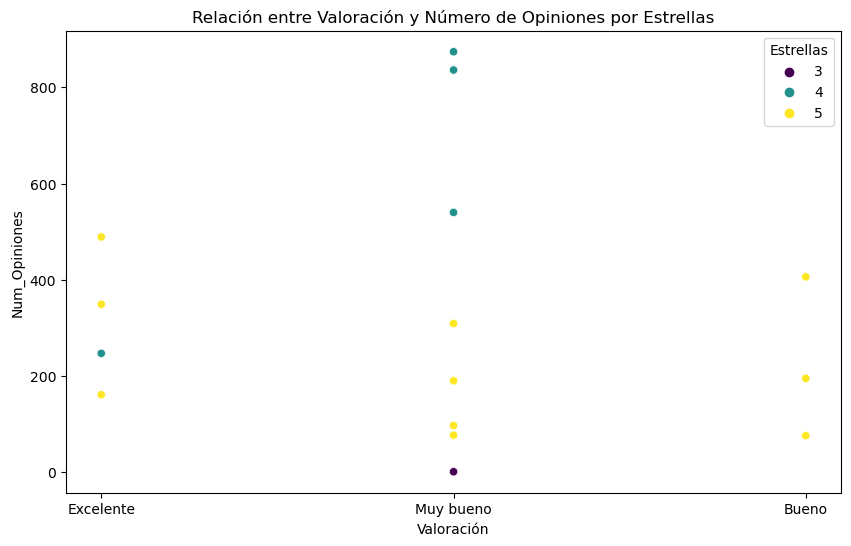

In [485]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Valoración", y="Num_Opiniones", hue="Estrellas", palette="viridis")
plt.xlabel("Valoración")
plt.ylabel("Num_Opiniones")
plt.title("Relación entre Valoración y Número de Opiniones por Estrellas")
plt.show()

## Relacion entre precio del hotel y puntuacion

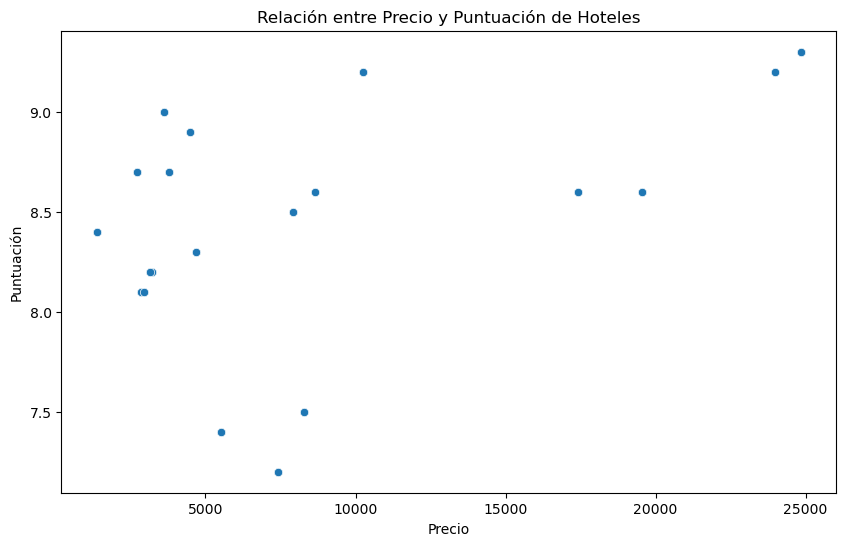

In [486]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Precio", y="Puntuación")
plt.xlabel("Precio")
plt.ylabel("Puntuación")
plt.title("Relación entre Precio y Puntuación de Hoteles")
plt.show()


# Distribucion de estrellas

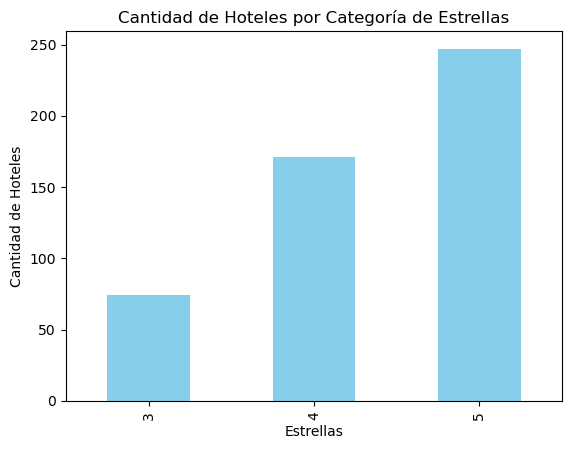

In [18]:
# Contar la cantidad de hoteles por categoría de estrellas
cantidad_hoteles_por_estrellas = df['Estrellas'].value_counts()

# Ordenar el índice para asegurar que el gráfico esté en orden
cantidad_hoteles_por_estrellas = cantidad_hoteles_por_estrellas.sort_index()

# Graficar
cantidad_hoteles_por_estrellas.plot(kind='bar', color='skyblue')
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de Hoteles')
plt.title('Cantidad de Hoteles por Categoría de Estrellas')
plt.show()

# Relacion entre valoracion y numero de opiniones

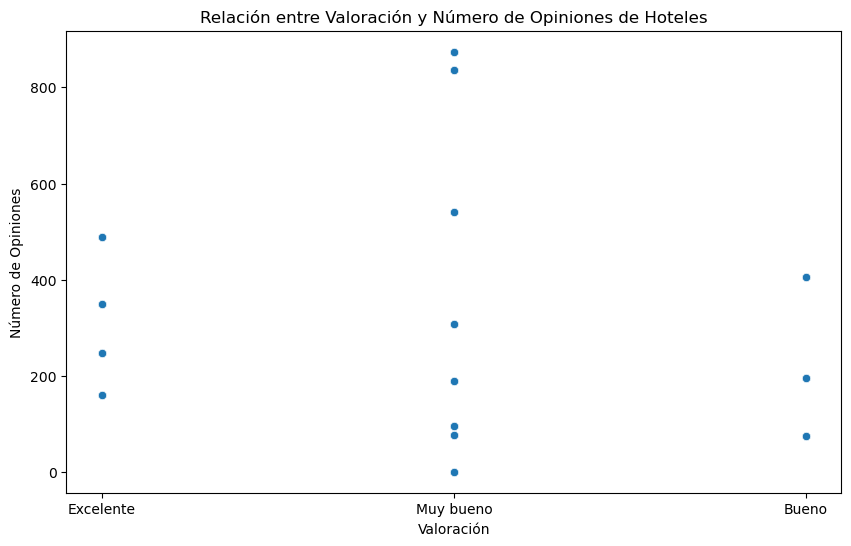

In [488]:
v

# Distribucion de precios por estrellas

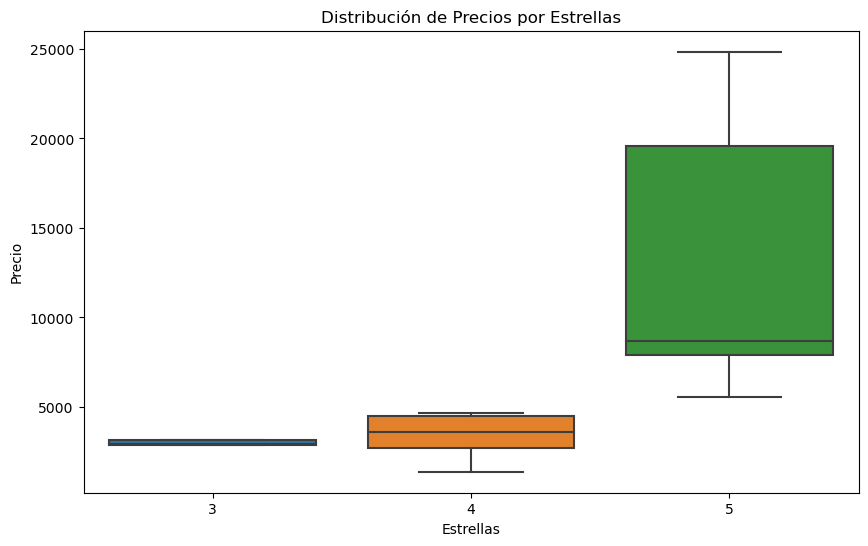

In [489]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Estrellas", y="Precio")
plt.xlabel("Estrellas")
plt.ylabel("Precio")
plt.title("Distribución de Precios por Estrellas")
plt.show()

# Comparacion de precios entre agencias

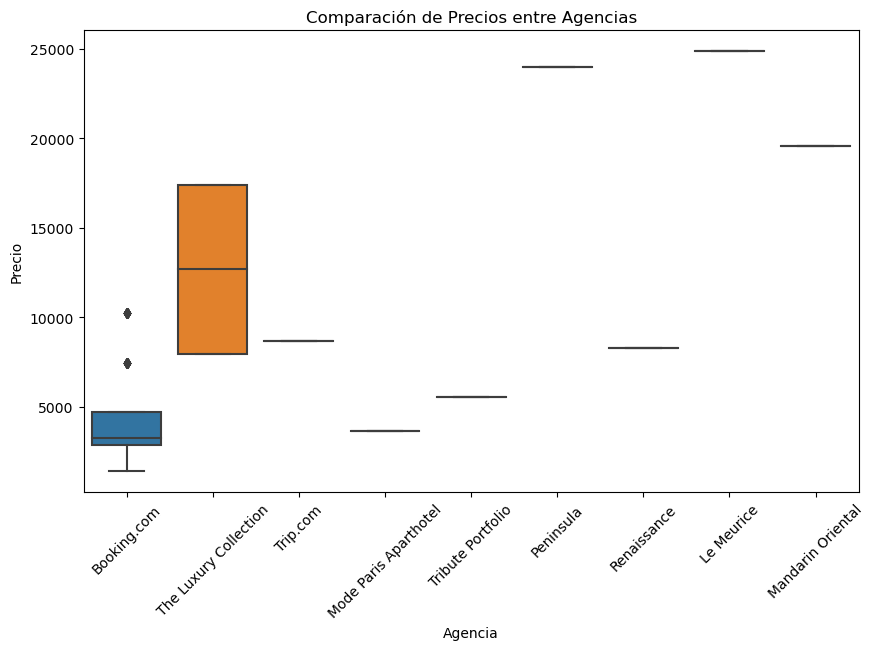

In [490]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Agencia", y="Precio")
plt.xticks(rotation=45)
plt.xlabel("Agencia")
plt.ylabel("Precio")
plt.title("Comparación de Precios entre Agencias")
plt.show()

### Comparación de Valoración entre Hoteles de Diferentes Estrellas

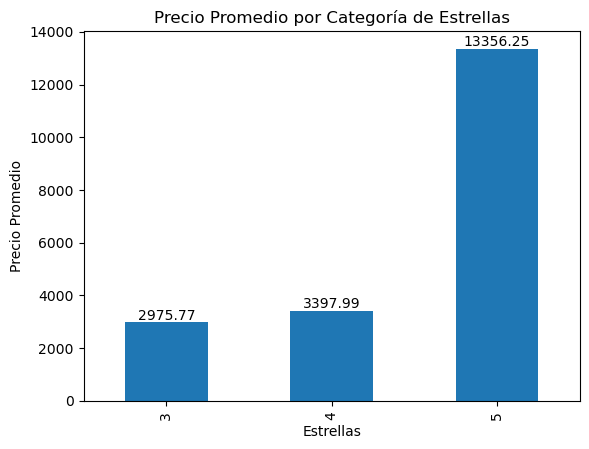

In [46]:
promedio_precios = df.groupby('Estrellas')['Precio'].mean()


fig, ax = plt.subplots()

promedio_precios.plot(kind='bar', ax=ax)


for i, valor in enumerate(promedio_precios):
    ax.text(i, valor, f'{valor:.2f}', ha='center', va='bottom')


plt.xlabel('Estrellas')
plt.ylabel('Precio Promedio')
plt.title('Precio Promedio por Categoría de Estrellas')

plt.show()

# Precio promedio por categoría de estrellas

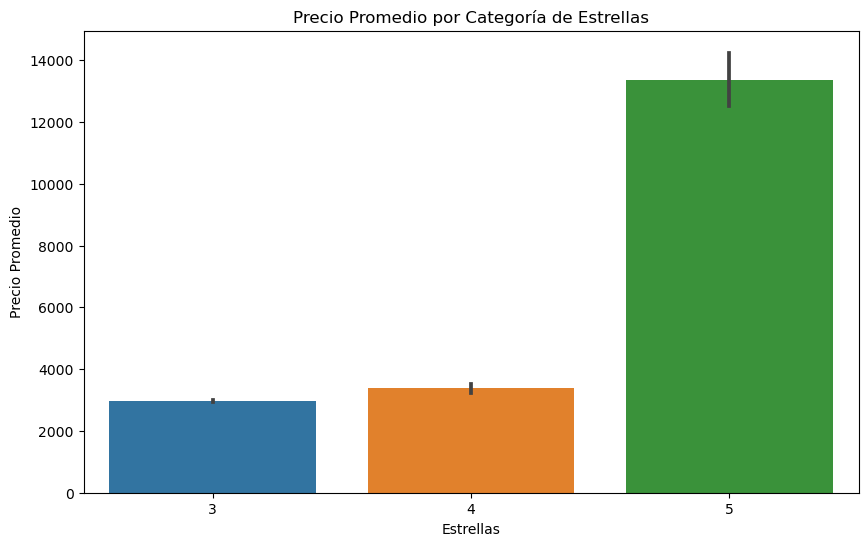

In [492]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Estrellas", y="Precio", estimator=np.mean)
plt.xlabel("Estrellas")
plt.ylabel("Precio Promedio")
plt.title("Precio Promedio por Categoría de Estrellas")
plt.show()

In [494]:
from geopy.geocoders import Nominatim

# Inicio un geocodificador de Nominatim
geolocator = Nominatim(user_agent="myGeocoder")

# Función para geocodificar una dirección y obtener las coordenadas:
def geocode_address(address):
    location = geolocator.geocode(address)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Aplico la función al DataFrame y creo nuevas columnas para latitud y longitud
df['Latitud'], df['Longitud'] = zip(*df['Ubicación'].apply(geocode_address))

# Distribución de hoteles por ubicacion

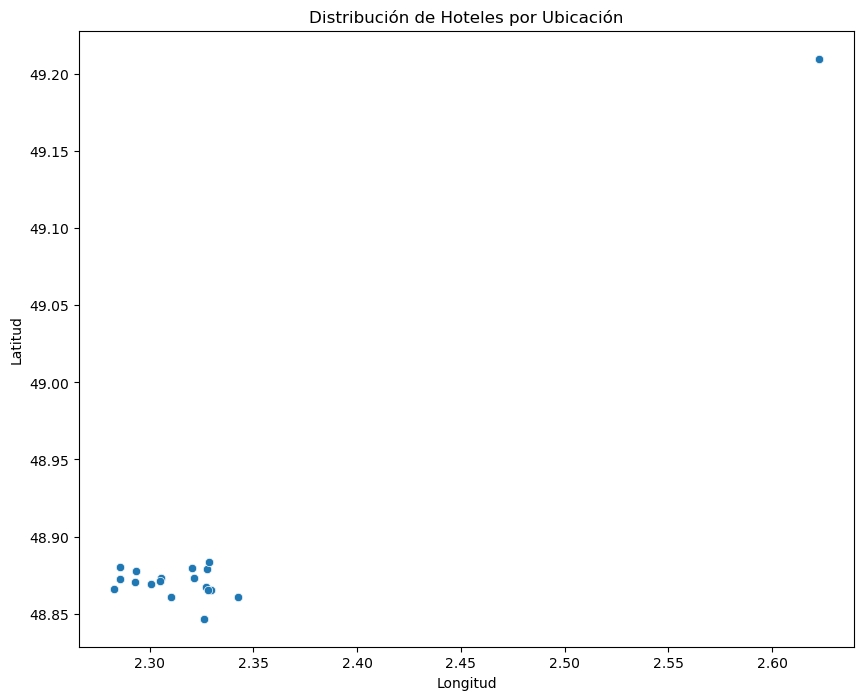

In [495]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="Longitud", y="Latitud", data=df)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Distribución de Hoteles por Ubicación")
plt.show()

# Mapa interactivo con etiquetas

In [496]:
m = folium.Map(location=[48.8566, 2.3522], zoom_start=10)

df = df.dropna(subset=["Latitud", "Longitud"])

for index, row in df.iterrows():
    folium.Marker([row['Latitud'], row['Longitud']], popup=f"{row['Nombre']}\nPuntuación: {row['Puntuación']}\nValoración: {row['Valoración']}").add_to(m)

In [497]:
m

# Marcador de hoteles según estrellas

In [498]:

m = folium.Map(location=[48.8566, 2.3522], zoom_start=10)

df=df.dropna(subset=["Latitud", "Longitud"])


# Itero para agregar marcadores para cada hotel con colores según su número de estrellas
for index, row in df.iterrows():
    estrellas = row['Estrellas']
    if estrellas <= 2:
        color = 'red'
    elif estrellas <= 3:
        color = 'blue'
    elif estrellas <= 4:
        color = 'yellow'
    elif estrellas >= 5:
        color = 'pink'
        
    else:
        color = 'green'
    
    folium.CircleMarker([row['Latitud'], row['Longitud']], radius=5, color=color, fill=True, fill_color=color, fill_opacity=0.7, popup=row['Nombre']).add_to(m)

In [499]:
m

# ALOJAMIENTO TRIPADVISOR

# EXTRACCIÓN DE DATOS

In [53]:
# Importar
import numpy as np
import pandas as pd

import requests
from  bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By

from time import sleep

In [ ]:
url = "https://www.tripadvisor.es/"

browser = webdriver.Chrome()

browser.get(url=url)

browser.maximize_window()

In [ ]:
#Primeras cookies
browser.find_element(By.ID, "onetrust-accept-btn-handler").click()

In [ ]:
#Segundas cookies
try:
    browser.find_element(By.ID, "accept-recommended-btn-handler").click()
except:
    next

In [ ]:
#Buscador
buscador = browser.find_element(By.NAME, "q")

In [ ]:
# Variables
ciudad_a_buscar = "Paris"

In [ ]:
#keys
buscador.send_keys(ciudad_a_buscar)
sleep(1)

In [ ]:
# Seleccionar la categoria londres hoteles
browser.find_element(By.PARTIAL_LINK_TEXT, "paris hoteles").click()

In [ ]:
# Variables
anho = '2024'

mes = 'abril'

dia_inicio = '1'

dia_fin = '15'

# Mes y Año
try:
    browser.find_element(By.CSS_SELECTOR, "div[role = 'grid']")
except:
    browser.find_element(By.CSS_SELECTOR, "div[data-automation = 'checkin']").click()
    next

mes_mayuscula = mes[0].capitalize()+mes[1:]

while True:
    mes_anho = browser.find_element(By.CSS_SELECTOR, "div[role = 'grid']").text.split('\n')[0]

    print(mes_anho)

    if mes_anho == f'{mes_mayuscula} de {anho}':
        break
    avanzar_mes = browser.find_element(By.CSS_SELECTOR, "button[data-testid = 'nav_next']")

    avanzar_mes.click()

    sleep(1)

for dia in browser.find_elements(By.CSS_SELECTOR, "div[role = 'gridcell']"):
    if dia.text == dia_inicio:
        dia.click()
    elif dia.text == dia_fin:
        dia.click()
        break

In [ ]:
# Pestaña de huespedes
try:
    browser.find_element(By.CSS_SELECTOR,"button[data-automation = 'guestsUpdateBtn']").click()
except:
    pass

In [ ]:
from selenium.common.exceptions import NoSuchElementException

In [ ]:
url_hoteles = []

pagina = 1

while True:
    soup = BeautifulSoup(browser.page_source, 'html.parser')
    
    hoteles_pagina = soup.find_all('span', class_ = "listItem")
    
    url_hoteles_pagina = ['https://www.tripadvisor.es/' + hotel.find('a')['href'] for hotel in hoteles_pagina]
    
    url_hoteles.extend(url_hoteles_pagina)
    
    try:
        browser.find_element(By.CSS_SELECTOR, "a[aria-label='Página siguiente']").click()
        pagina +=1
        sleep(2)
    except NoSuchElementException:
        break

In [ ]:
for url in url_hoteles:
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(browser.page_source, "html.parser")
    except:
        next

In [ ]:
def info_hotel(soup):
    info ={}
    try:
        info['Nombre'] = soup.find("h1",attrs = {"id":"HEADING"}).text
        info['Ubicacion'] = soup.find("span", class_ = "fHvkI").text[:17]
        info['Estrellas'] = soup.find("svg", class_ = "JXZuC d H0")['aria-label'][:3]
        info['Puntuación'] = soup.find("span", class_ = "uwJeR P").text
        info ['Valoración'] = soup.find("div", class_ = "kkzVG").text
        info ['Num_Opiniones'] = soup.find("span", class_ = "qqniT").text[:4]
        info['Precio'] = soup.find("div", class_ = "WXMFC b").text.replace('\xa0€','')
        info['Agencia'] = soup.find("div", class_ = "WeNyO").text
    except :
        pass
    return info

In [ ]:
info_hoteles=[]
for url in url_hoteles[:500]:
    try:
        browser.get(url)
        sleep(2)
        soup = BeautifulSoup(browser.page_source, "html.parser")
        
        info = info_hotel(soup)
        info_hoteles.append(info)
    except:
        pass

In [ ]:
pd.DataFrame(info_hoteles)

In [ ]:
df.to_csv('TRIPADVISOR.csv')

# LIMPIEZA DE DATOS


# NUEVA YORK

In [61]:
import numpy as np
import pandas as pd

In [62]:
df = pd.read_csv("Data/NEW_YORK_TRIPADVISOR.csv")

In [63]:
#tamaño de mi df antes de la limpieza:
df.shape

(266, 8)

In [64]:
df = df.dropna()

In [65]:
# Paso el valor a float
df["Estrellas"]=df["Estrellas"].str.replace(",", ".").astype(float)

In [66]:
##reemplazar "," por "." en 
def reemplazar_puntuacion(valor):
    try:
        return valor.replace(",", ".")
    except:
        return Nan

In [67]:
df["Puntuación"] = df["Puntuación"].apply(reemplazar_puntuacion)

In [68]:
df = df.reset_index(drop=True)

In [69]:
#paso el valor de object a float:
df["Puntuación"] = pd.to_numeric(df["Puntuación"])

In [70]:
df

Unnamed: 0                                          Nombre  \
0             2   The Plaza New York - A Fairmont Managed Hotel   
1             3                                    Pod 51 Hotel   
2             4           Hotel Riu Plaza New York Times Square   
3             5                        Sanctuary Hotel New York   
4             7                       New York Marriott Marquis   
..          ...                                             ...   
261         412                                       The Moore   
262         423                       Chelsea Inn - 17th Street   
263         431  The Solita Soho Hotel, Ascend Hotel Collection   
264         433                                  NobleDEN Hotel   
265         434                       33 Seaport Hotel New York   

             Ubicacion  Estrellas  Puntuación Valoración Num_Opiniones  Precio  
0    768 Fifth Avenue,        5.0         4.5  Excelente          3892   929.0  
1    230 East 51st Str        3.0         4.0  Muy bueno          6137   233.0  
2    305 W 46th St, Nu        4.0         4.5  Excelente          6248   422.0  
3    132 west 47th str        4.0         4.5  Excelente          4886   573.0  
4    1535 Broadway, Nu        4.0         4.0  Muy bueno          13.5   529.0  
..                 ...        ...         ...        ...           ...     ...  
261  300 W 22nd St, Nu        3.0         4.5  Excelente          103    344.0  
262  46 W 17th St, Nue        2.0         3.5  Muy bueno          282    209.0  
263  159 Grand St, Nue        3.0         4.0  Muy bueno          600    358.0  
264  196 Grand Street,        3.0         4.5  Excelente          1186   443.0  
265  33 Peck Slip, Nue        3.0         4.0  Muy bueno          19 o   507.0  

[266 rows x 8 columns]

In [71]:
df['Precio']= df['Precio']*15

In [72]:
df

Unnamed: 0                                          Nombre  \
0             2   The Plaza New York - A Fairmont Managed Hotel   
1             3                                    Pod 51 Hotel   
2             4           Hotel Riu Plaza New York Times Square   
3             5                        Sanctuary Hotel New York   
4             7                       New York Marriott Marquis   
..          ...                                             ...   
261         412                                       The Moore   
262         423                       Chelsea Inn - 17th Street   
263         431  The Solita Soho Hotel, Ascend Hotel Collection   
264         433                                  NobleDEN Hotel   
265         434                       33 Seaport Hotel New York   

             Ubicacion  Estrellas  Puntuación Valoración Num_Opiniones  \
0    768 Fifth Avenue,        5.0         4.5  Excelente          3892   
1    230 East 51st Str        3.0         4.0  Muy bueno          6137   
2    305 W 46th St, Nu        4.0         4.5  Excelente          6248   
3    132 west 47th str        4.0         4.5  Excelente          4886   
4    1535 Broadway, Nu        4.0         4.0  Muy bueno          13.5   
..                 ...        ...         ...        ...           ...   
261  300 W 22nd St, Nu        3.0         4.5  Excelente          103    
262  46 W 17th St, Nue        2.0         3.5  Muy bueno          282    
263  159 Grand St, Nue        3.0         4.0  Muy bueno          600    
264  196 Grand Street,        3.0         4.5  Excelente          1186   
265  33 Peck Slip, Nue        3.0         4.0  Muy bueno          19 o   

      Precio  
0    13935.0  
1     3495.0  
2     6330.0  
3     8595.0  
4     7935.0  
..       ...  
261   5160.0  
262   3135.0  
263   5370.0  
264   6645.0  
265   7605.0  

[266 rows x 8 columns]

In [70]:
df = df.reset_index(drop=True)

In [71]:
df.drop("Unnamed: 0", axis=1)

Nombre          Ubicacion  \
0     The Plaza New York - A Fairmont Managed Hotel  768 Fifth Avenue,   
1                                      Pod 51 Hotel  230 East 51st Str   
2             Hotel Riu Plaza New York Times Square  305 W 46th St, Nu   
3                          Sanctuary Hotel New York  132 west 47th str   
4                         New York Marriott Marquis  1535 Broadway, Nu   
..                                              ...                ...   
261                                       The Moore  300 W 22nd St, Nu   
262                       Chelsea Inn - 17th Street  46 W 17th St, Nue   
263  The Solita Soho Hotel, Ascend Hotel Collection  159 Grand St, Nue   
264                                  NobleDEN Hotel  196 Grand Street,   
265                       33 Seaport Hotel New York  33 Peck Slip, Nue   

    Estrellas Puntuación Valoración Num_Opiniones   Precio  
0         5,0        4,5  Excelente          3892  13935.0  
1         3,0        4,0  Muy bueno          6137   3495.0  
2         4,0        4,5  Excelente          6248   6330.0  
3         4,0        4,5  Excelente          4886   8595.0  
4         4,0        4,0  Muy bueno          13.5   7935.0  
..        ...        ...        ...           ...      ...  
261       3,0        4,5  Excelente          103    5160.0  
262       2,0        3,5  Muy bueno          282    3135.0  
263       3,0        4,0  Muy bueno          600    5370.0  
264       3,0        4,5  Excelente          1186   6645.0  
265       3,0        4,0  Muy bueno          19 o   7605.0  

[266 rows x 7 columns]

In [72]:
df.to_csv('FILTRADO_NEW YORK_TRIPADVISOR.csv')

# LONDRES

In [32]:
df = pd.read_csv("Data/LONDRES_TRIPADVISOR.csv")

In [33]:
#tamaño de mi df antes de la limpieza:
df.shape

(480, 8)

In [34]:
df = df.dropna()

In [35]:
 #Paso el valor a float
df["Estrellas"]=df["Estrellas"].str.replace(",", ".").astype(float)

In [36]:
##reemplazar "," por "." en 
def reemplazar_puntuacion(valor):
    try:
        return valor.replace(",", ".")
    except:
        return Nan

In [37]:
df["Puntuación"] = df["Puntuación"].apply(reemplazar_puntuacion)

In [38]:
#paso el valor de object a float:
df["Puntuación"] = pd.to_numeric(df["Puntuación"])

In [39]:
df = df.reset_index(drop=True)

In [40]:
df['Precio']= df['Precio']*15

In [41]:
df.drop("Unnamed: 0", axis=1)

Nombre          Ubicacion  \
0              Holiday Inn London - West, an IHG Hotel  4 Portal Way, Lon   
1                           The Resident Covent Garden  51 Bedford Street   
2                              Presidential Apartments  6-12 Barkston Gar   
3                             Thistle Piccadilly Hotel  Coventry Street,    
4                          Park Grand Paddington Court  27 Devonshire Ter   
..                                                 ...                ...   
287                      Park Plaza County Hall London  1 Addington Stree   
288                   Pullman London St. Pancras Hotel  100 - 110 Euston    
289  Holiday Inn Express London - Victoria, an IHG ...  106-110 Belgrave    
290                               The Z Hotel Victoria  5 Lower Belgrave    
291                                       The Beaumont  8 Balderton Stree   

     Estrellas  Puntuación Valoración Num_Opiniones   Precio  
0          3.0         4.5  Excelente          1363   3705.0  
1          4.0         5.0  Excelente          1583   5085.0  
2          4.0         4.0  Muy bueno          733    4560.0  
3          4.0         4.5  Excelente          1773   4455.0  
4          4.0         4.5  Excelente          4029   2910.0  
..         ...         ...        ...           ...      ...  
287        4.0         4.5  Excelente          1365   4290.0  
288        4.0         4.5  Excelente          5980   4500.0  
289        3.0         3.5  Muy bueno          874    3255.0  
290        3.0         4.0  Muy bueno          2077   2070.0  
291        5.0         5.0  Excelente          775   11340.0  

[292 rows x 7 columns]

In [42]:
df.to_csv('FILTRADO_LONDRES_TRIPADVISOR.csv')

# PARIS

In [108]:
df = pd.read_csv("Data/PARIS_TRIPADVISOR.csv")

In [109]:
#tamaño de mi df antes de la limpieza:
df.shape

(487, 6)

In [110]:
df = df.dropna()

In [111]:
 #Paso el valor a float
df["Estrellas"]=df["Estrellas"].str.replace(",", ".").astype(float)

In [112]:
##reemplazar "," por "." en 
def reemplazar_puntuacion(valor):
    try:
        return valor.replace(",", ".")
    except:
        return Nan

In [113]:
df["Puntuación"] = df["Puntuación"].apply(reemplazar_puntuacion)

In [114]:
#paso el valor de object a float:
df["Puntuación"] = pd.to_numeric(df["Puntuación"])

In [115]:
df = df.reset_index(drop=True)

In [116]:
df.drop("Unnamed: 0", axis=1)

Nombre          Ubicacion  \
0                                Grand Hotel Malher  5 rue Malher 4th    
1                             Hotel Malte - Astotel  63 rue de Richeli   
2                  Apartments Du Louvre - Le Marais  4 rue Etienne Mar   
3                              Le Relais Des Halles  26 Rue Pierre Les   
4    Maison Astor Paris, Curio Collection by Hilton  11 Rue d’Astorg,    
..                                              ...                ...   
469                       Le Marceau Bastille Hotel  13 rue Jules Cesa   
470                                     Hôtel Basss  57 rue des Abbess   
471                                     Le Belleval  16 rue de la Pepi   
472                                  Hotel Louis II  2 rue Saint Sulpi   
473                        Hotel Royal Saint Michel  3 boulevard Saint   

     Estrellas  Puntuación Valoración  
0          3.0         4.0  Muy bueno  
1          4.0         5.0  Excelente  
2          5.0         5.0  Excelente  
3          4.0         5.0  Excelente  
4          4.0         4.5  Excelente  
..         ...         ...        ...  
469        4.0         4.5  Excelente  
470        3.0         4.0  Muy bueno  
471        4.0         4.5  Excelente  
472        4.0         5.0  Excelente  
473        4.0         4.0  Muy bueno  

[474 rows x 5 columns]

In [118]:
df.to_csv('FILTRADO_PARIS_TRIPADVISOR.csv')

# GRAFICAS

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import folium

In [107]:
df = pd.read_csv("Data/SAN_FRANCISCO_TRIPADVISOR.csv")

In [86]:
df

Unnamed: 0                                             Nombre  \
0             0  The Barnes San Francisco, Tapestry Collection ...   
1             1                   Chancellor Hotel on Union Square   
2             2                   Staypineapple - An Elegant Hotel   
3             3                  Hotel Riu Plaza Fisherman’s Wharf   
4             4                        Hyatt Regency San Francisco   
..          ...                                                ...   
418         418                                      Bel Air Hotel   
419         419                                    Inn On Broadway   
420         420                                  Washington Suites   
421         421             Global Luxury Suites At South Beach Sf   
422         422                        National at Bayside Village   

             Ubicacion Estrellas Puntuación Valoración Num_Opiniones  Precio  
0    225 Powell Street       4,0        3,5  Muy bueno          54 o   216.0  
1    433 Powell Street       3,0        4,5  Excelente          5971   292.0  
2    580 Geary St, San       3,0        4,5  Excelente          1965   555.0  
3    2500 Mason Street       4,0        4,0  Muy bueno          980    221.0  
4    5 Embarcadero Cen       4,0        4,0  Muy bueno          6801   438.0  
..                 ...       ...        ...        ...           ...     ...  
418  344 Jones Street,       NaN        NaN        NaN           NaN     NaN  
419  2201 Van Ness Ave       2,0        NaN        NaN           NaN     NaN  
420  1265 Washington S       NaN        NaN        NaN           NaN     NaN  
421  788 Harrison St,        NaN        NaN        NaN           NaN     NaN  
422  3 Bayside Village       NaN        NaN        NaN           NaN     NaN  

[423 rows x 8 columns]

In [108]:
df.shape

(423, 8)

In [109]:
df = df.dropna()

In [110]:
df.shape

(137, 8)

In [111]:
df['Precio']= df['Precio']*15

Text(Media de Prcios, 3588.065693430657, '3588.07')

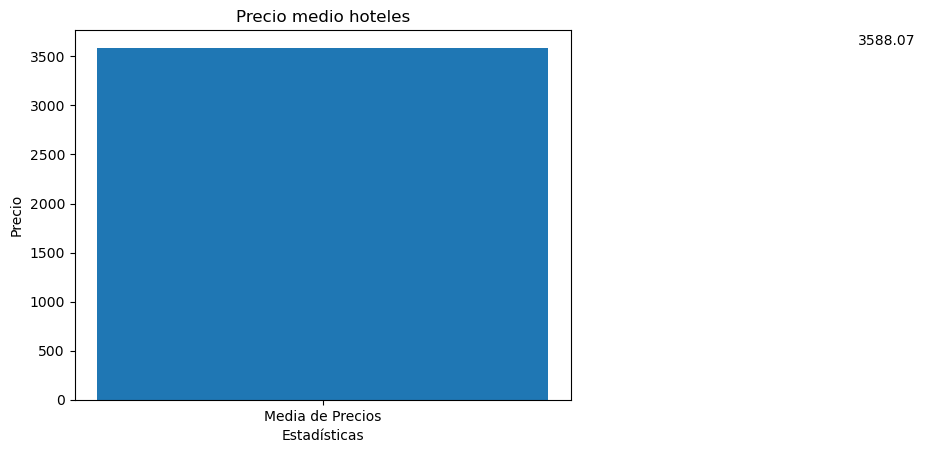

In [112]:
media_precio = df['Precio'].mean()

plt.bar("Media de Precios", media_precio) 

plt.title(f'Precio medio hoteles')
plt.xlabel('Estadísticas')
plt.ylabel('Precio')

plt.text("Media de Prcios", media_precio, round(media_precio, 2), ha='center', va='bottom')

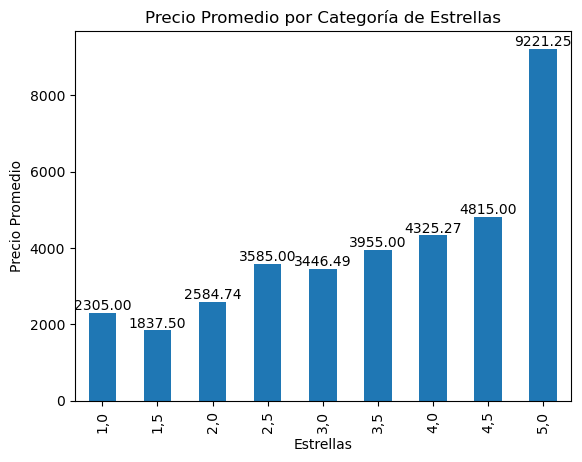

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

promedio_precios = df.groupby('Estrellas')['Precio'].mean()


fig, ax = plt.subplots()

promedio_precios.plot(kind='bar', ax=ax)


for i, valor in enumerate(promedio_precios):
    ax.text(i, valor, f'{valor:.2f}', ha='center', va='bottom')


plt.xlabel('Estrellas')
plt.ylabel('Precio Promedio')
plt.title('Precio Promedio por Categoría de Estrellas')

plt.show()

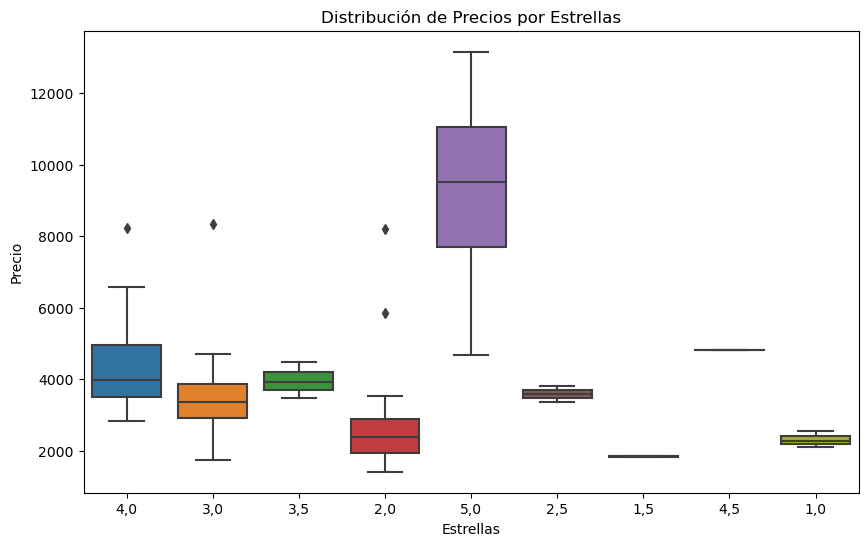

In [115]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Estrellas", y="Precio")
plt.xlabel("Estrellas")
plt.ylabel("Precio")
plt.title("Distribución de Precios por Estrellas")
plt.show()

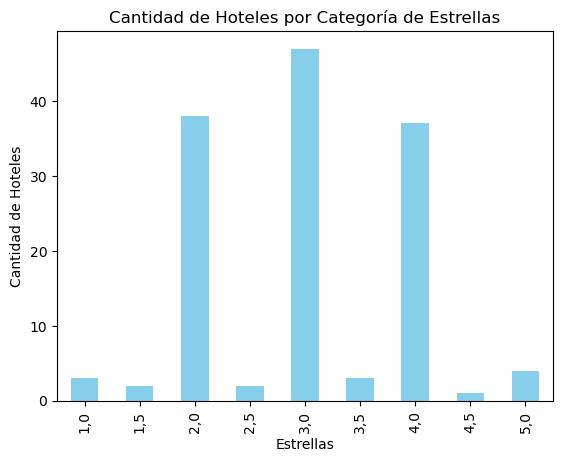

In [95]:
# Contar la cantidad de hoteles por categoría de estrellas
cantidad_hoteles_por_estrellas = df['Estrellas'].value_counts()

# Ordenar el índice para asegurar que el gráfico esté en orden
cantidad_hoteles_por_estrellas = cantidad_hoteles_por_estrellas.sort_index()

# Graficar
cantidad_hoteles_por_estrellas.plot(kind='bar', color='skyblue')
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de Hoteles')
plt.title('Cantidad de Hoteles por Categoría de Estrellas')
plt.show()

In [92]:
#Saco el nº de hoteles de cada agencia:
numero_agencias = df['Agencia'].value_counts()

# Convierto a un DataFrame
numero_agencias_df = numero_agencias.reset_index()
numero_agencias_df.columns = ['Agencia', 'Cantidad de Hoteles']

# Ordeno el DataFrame por la cantidad de hoteles en orden descendente
numero_agencias_df = numero_agencias_df.sort_values(by='Cantidad de Hoteles', ascending=False)

# Creo gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(numero_agencias_df['Agencia'], numero_agencias_df['Cantidad de Hoteles'])
plt.xlabel('Agencia')
plt.ylabel('Cantidad de Hoteles')
plt.title('Cantidad de Hoteles por Agencia')
plt.xticks(rotation=90)  # Roto las etiquetas en el eje x 

# Agrego los números exactos de hoteles en cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

KeyError: 'Agencia'

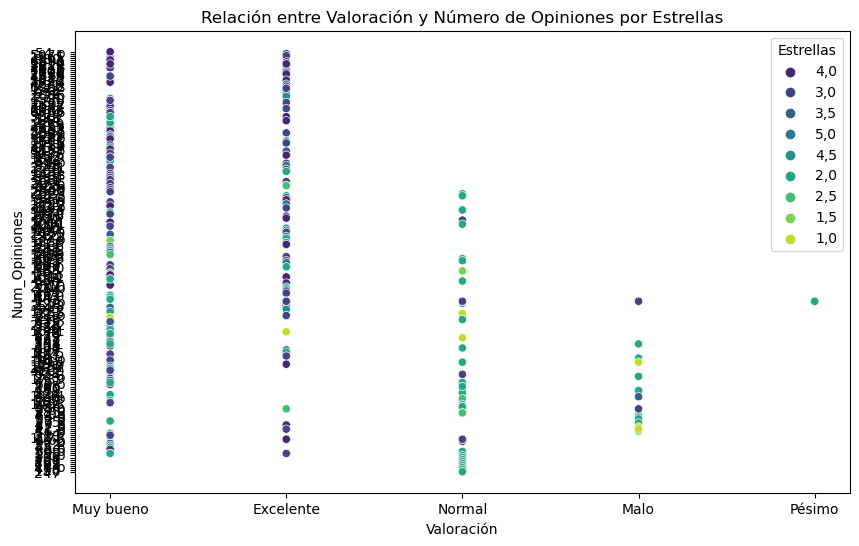

In [93]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Valoración", y="Num_Opiniones", hue="Estrellas", palette="viridis")
plt.xlabel("Valoración")
plt.ylabel("Num_Opiniones")
plt.title("Relación entre Valoración y Número de Opiniones por Estrellas")
plt.show()

#NUEVA YORK

In [96]:
df = pd.read_csv("Data/FILTRADO_NEW YORK_TRIPADVISOR.csv")

In [79]:
df

Unnamed: 0.1  Unnamed: 0                                          Nombre  \
0               0           2   The Plaza New York - A Fairmont Managed Hotel   
1               1           3                                    Pod 51 Hotel   
2               2           4           Hotel Riu Plaza New York Times Square   
3               3           5                        Sanctuary Hotel New York   
4               4           7                       New York Marriott Marquis   
..            ...         ...                                             ...   
261           261         412                                       The Moore   
262           262         423                       Chelsea Inn - 17th Street   
263           263         431  The Solita Soho Hotel, Ascend Hotel Collection   
264           264         433                                  NobleDEN Hotel   
265           265         434                       33 Seaport Hotel New York   

             Ubicacion Estrellas Puntuación Valoración Num_Opiniones   Precio  
0    768 Fifth Avenue,       5,0        4,5  Excelente          3892  13935.0  
1    230 East 51st Str       3,0        4,0  Muy bueno          6137   3495.0  
2    305 W 46th St, Nu       4,0        4,5  Excelente          6248   6330.0  
3    132 west 47th str       4,0        4,5  Excelente          4886   8595.0  
4    1535 Broadway, Nu       4,0        4,0  Muy bueno          13.5   7935.0  
..                 ...       ...        ...        ...           ...      ...  
261  300 W 22nd St, Nu       3,0        4,5  Excelente          103    5160.0  
262  46 W 17th St, Nue       2,0        3,5  Muy bueno          282    3135.0  
263  159 Grand St, Nue       3,0        4,0  Muy bueno          600    5370.0  
264  196 Grand Street,       3,0        4,5  Excelente          1186   6645.0  
265  33 Peck Slip, Nue       3,0        4,0  Muy bueno          19 o   7605.0  

[266 rows x 9 columns]

In [97]:
df.shape

(266, 9)

In [100]:
df=df.dropna()

In [101]:
df.shape

(266, 9)

Text(Media de Prcios, 5608.971936090225, '5608.97')

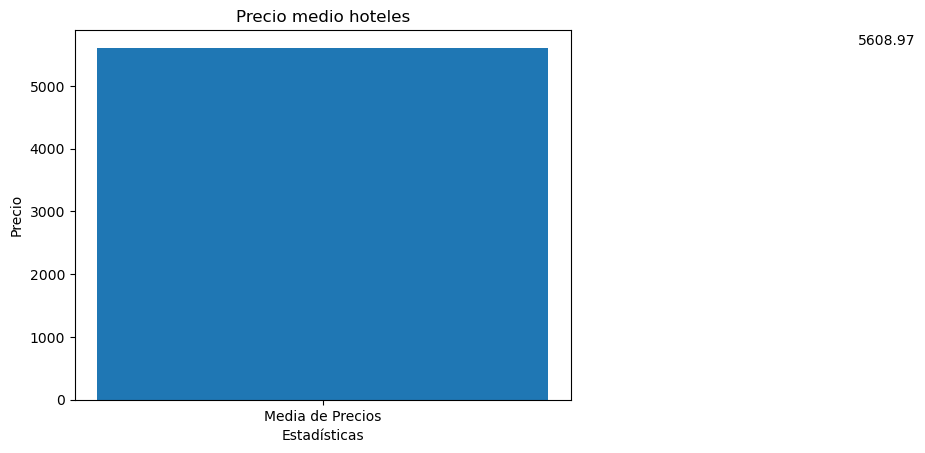

In [60]:
media_precio = df['Precio'].mean()

plt.bar("Media de Precios", media_precio)

plt.title(f'Precio medio hoteles')
plt.xlabel('Estadísticas')
plt.ylabel('Precio')

plt.text("Media de Prcios", media_precio, round(media_precio, 2), ha='center', va='bottom')

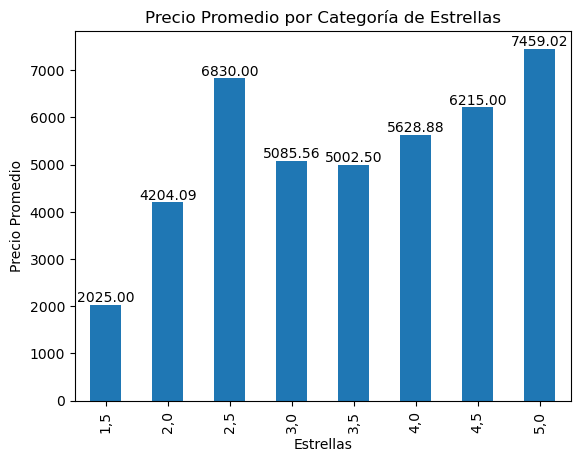

In [81]:
promedio_precios = df.groupby('Estrellas')['Precio'].mean()


fig, ax = plt.subplots()

promedio_precios.plot(kind='bar', ax=ax)


for i, valor in enumerate(promedio_precios):
    ax.text(i, valor, f'{valor:.2f}', ha='center', va='bottom')


plt.xlabel('Estrellas')
plt.ylabel('Precio Promedio')
plt.title('Precio Promedio por Categoría de Estrellas')

plt.show()

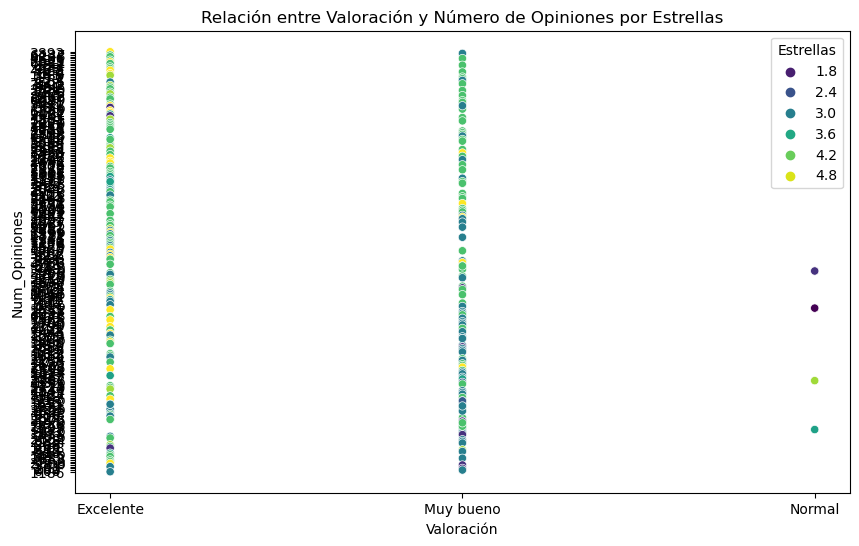

In [149]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Valoración", y="Num_Opiniones", hue="Estrellas", palette="viridis")
plt.xlabel("Valoración")
plt.ylabel("Num_Opiniones")
plt.title("Relación entre Valoración y Número de Opiniones por Estrellas")
plt.show()

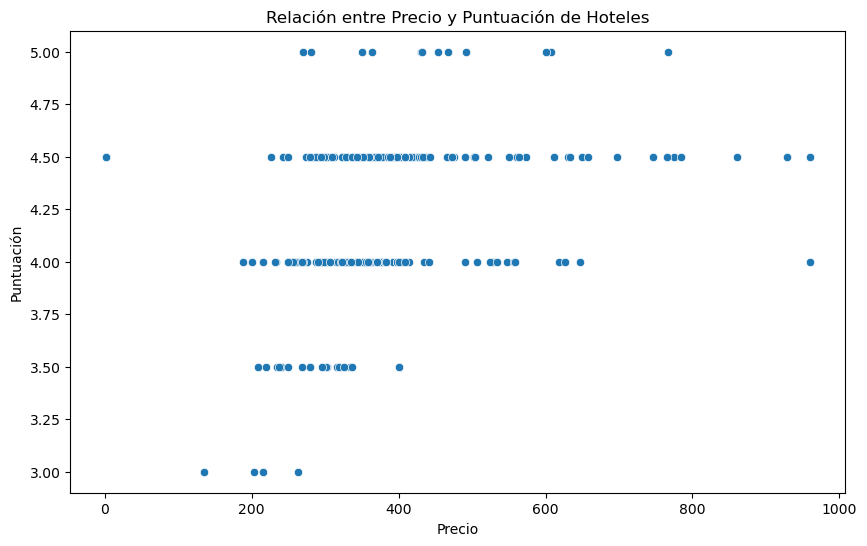

In [150]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Precio", y="Puntuación")
plt.xlabel("Precio")
plt.ylabel("Puntuación")
plt.title("Relación entre Precio y Puntuación de Hoteles")
plt.show()


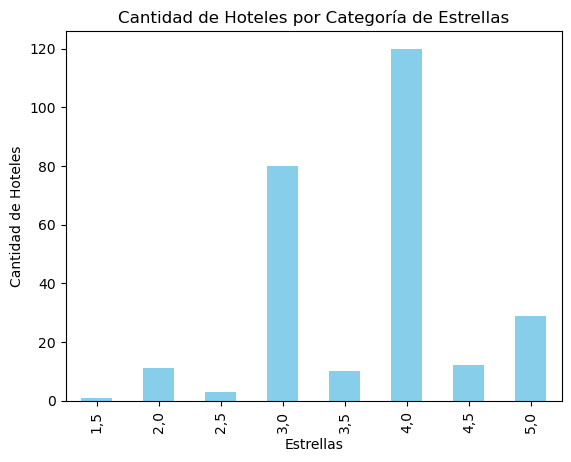

In [28]:
# Contar la cantidad de hoteles por categoría de estrellas
cantidad_hoteles_por_estrellas = df['Estrellas'].value_counts()

# Ordenar el índice para asegurar que el gráfico esté en orden
cantidad_hoteles_por_estrellas = cantidad_hoteles_por_estrellas.sort_index()

# Graficar
cantidad_hoteles_por_estrellas.plot(kind='bar', color='skyblue')
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de Hoteles')
plt.title('Cantidad de Hoteles por Categoría de Estrellas')
plt.show()

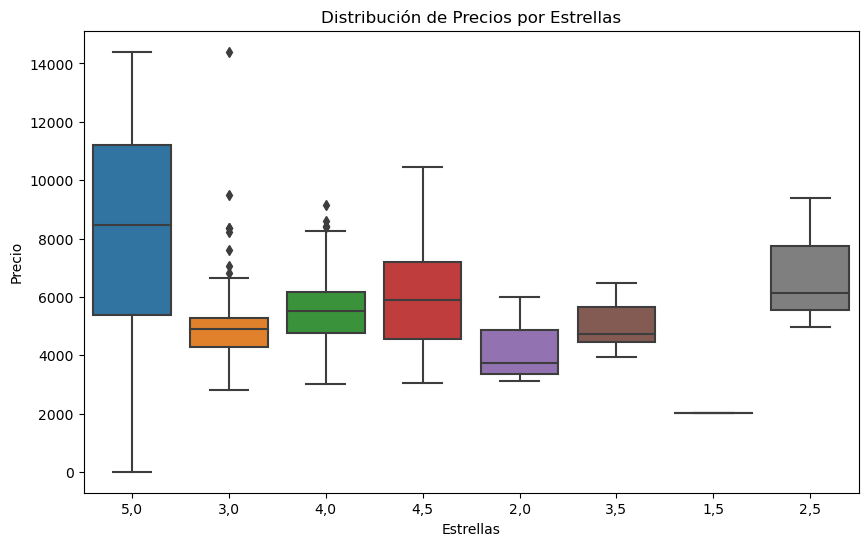

In [82]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Estrellas", y="Precio")
plt.xlabel("Estrellas")
plt.ylabel("Precio")
plt.title("Distribución de Precios por Estrellas")
plt.show()

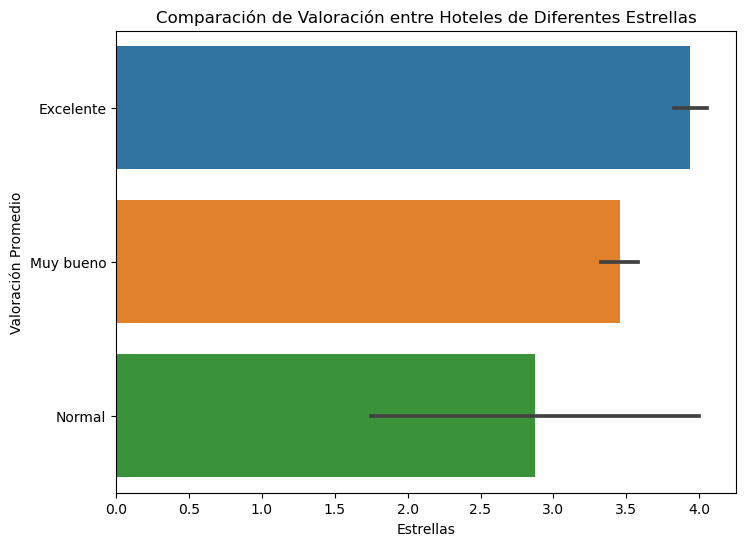

In [155]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="Estrellas", y="Valoración")
plt.xlabel("Estrellas")
plt.ylabel("Valoración Promedio")
plt.title("Comparación de Valoración entre Hoteles de Diferentes Estrellas")
plt.show()


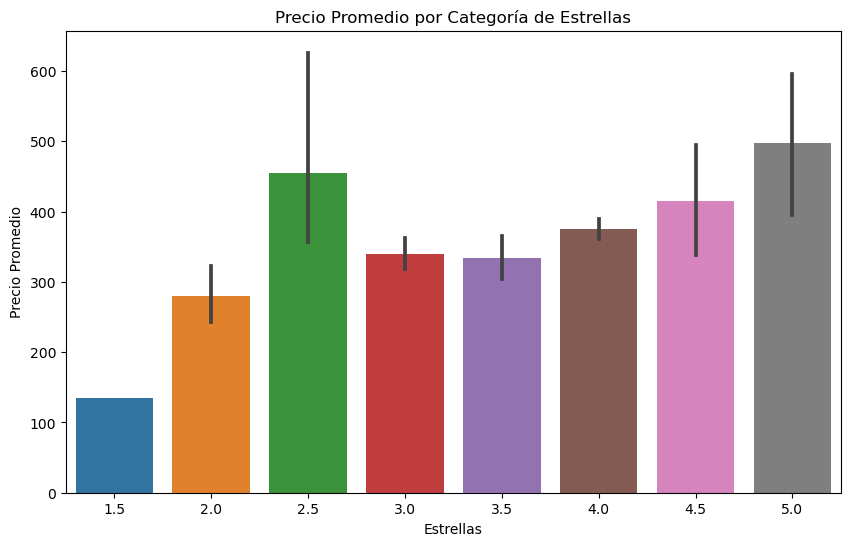

In [156]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Estrellas", y="Precio", estimator=np.mean)
plt.xlabel("Estrellas")
plt.ylabel("Precio Promedio")
plt.title("Precio Promedio por Categoría de Estrellas")
plt.show()

# LONDRES

In [52]:
df = pd.read_csv("Data/FILTRADO_LONDRES_TRIPADVISOR.csv")

In [53]:
df

Unnamed: 0.1  Unnamed: 0  \
0               0           2   
1               1           3   
2               2           4   
3               3           6   
4               4           7   
..            ...         ...   
287           287         469   
288           288         472   
289           289         475   
290           290         477   
291           291         478   

                                                Nombre          Ubicacion  \
0              Holiday Inn London - West, an IHG Hotel  4 Portal Way, Lon   
1                           The Resident Covent Garden  51 Bedford Street   
2                              Presidential Apartments  6-12 Barkston Gar   
3                             Thistle Piccadilly Hotel  Coventry Street,    
4                          Park Grand Paddington Court  27 Devonshire Ter   
..                                                 ...                ...   
287                      Park Plaza County Hall London  1 Addington Stree   
288                   Pullman London St. Pancras Hotel  100 - 110 Euston    
289  Holiday Inn Express London - Victoria, an IHG ...  106-110 Belgrave    
290                               The Z Hotel Victoria  5 Lower Belgrave    
291                                       The Beaumont  8 Balderton Stree   

     Estrellas  Puntuación Valoración Num_Opiniones   Precio  
0          3.0         4.5  Excelente          1363   3705.0  
1          4.0         5.0  Excelente          1583   5085.0  
2          4.0         4.0  Muy bueno          733    4560.0  
3          4.0         4.5  Excelente          1773   4455.0  
4          4.0         4.5  Excelente          4029   2910.0  
..         ...         ...        ...           ...      ...  
287        4.0         4.5  Excelente          1365   4290.0  
288        4.0         4.5  Excelente          5980   4500.0  
289        3.0         3.5  Muy bueno          874    3255.0  
290        3.0         4.0  Muy bueno          2077   2070.0  
291        5.0         5.0  Excelente          775   11340.0  

[292 rows x 9 columns]

Text(Media de Prcios, 4435.096130136986, '4435.1')

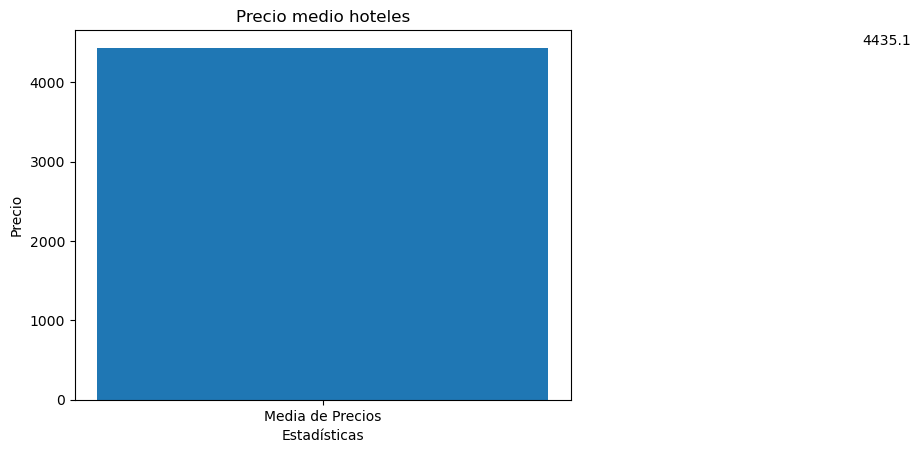

In [49]:
media_precio = df['Precio'].mean()

plt.bar("Media de Precios", media_precio)

plt.title(f'Precio medio hoteles')
plt.xlabel('Estadísticas')
plt.ylabel('Precio')

plt.text("Media de Prcios", media_precio, round(media_precio, 2), ha='center', va='bottom')

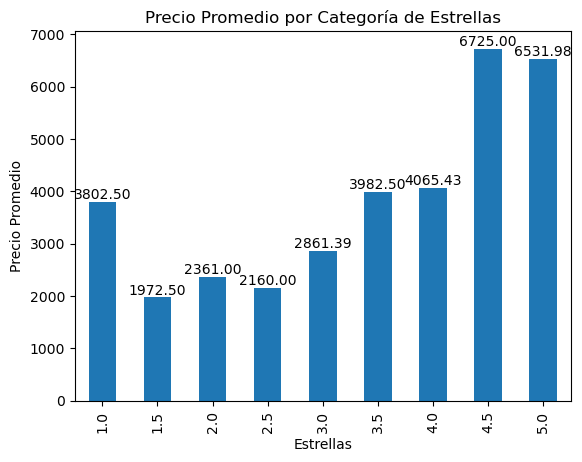

In [50]:
promedio_precios = df.groupby('Estrellas')['Precio'].mean()


fig, ax = plt.subplots()

promedio_precios.plot(kind='bar', ax=ax)


for i, valor in enumerate(promedio_precios):
    ax.text(i, valor, f'{valor:.2f}', ha='center', va='bottom')


plt.xlabel('Estrellas')
plt.ylabel('Precio Promedio')
plt.title('Precio Promedio por Categoría de Estrellas')

plt.show()

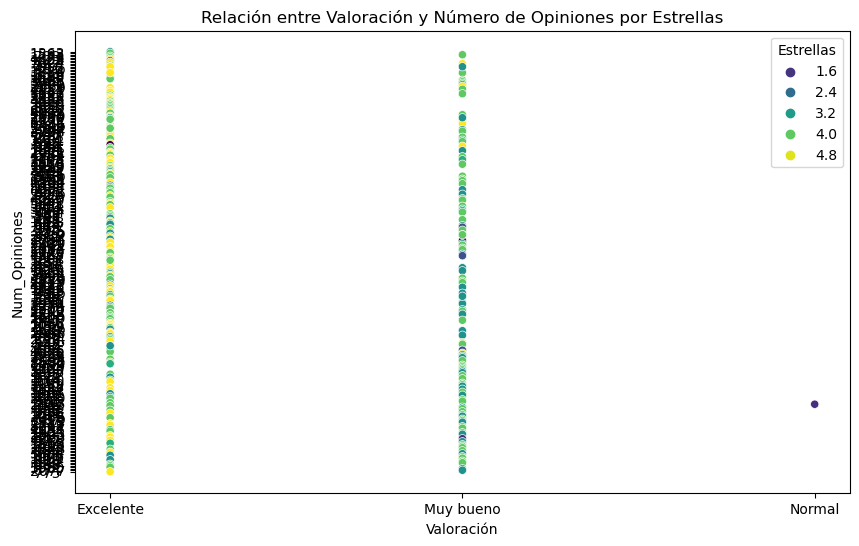

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Valoración", y="Num_Opiniones", hue="Estrellas", palette="viridis")
plt.xlabel("Valoración")
plt.ylabel("Num_Opiniones")
plt.title("Relación entre Valoración y Número de Opiniones por Estrellas")
plt.show()

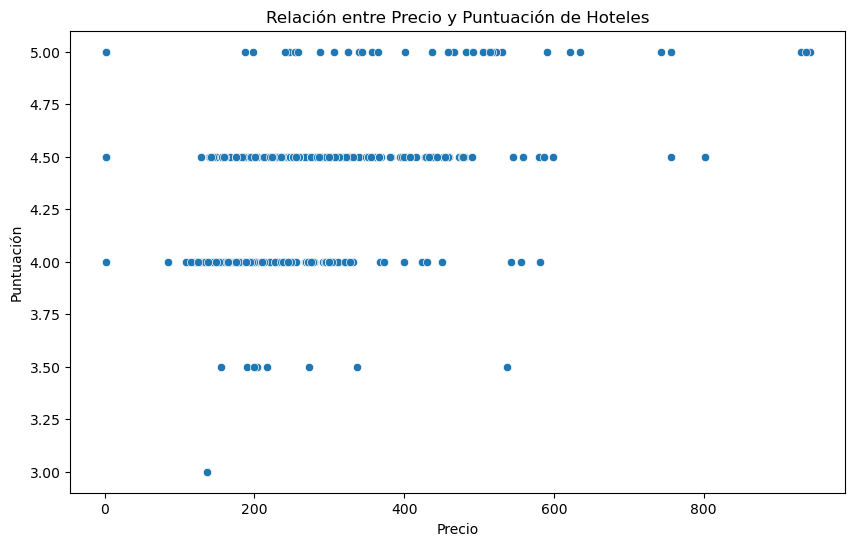

In [162]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Precio", y="Puntuación")
plt.xlabel("Precio")
plt.ylabel("Puntuación")
plt.title("Relación entre Precio y Puntuación de Hoteles")
plt.show()


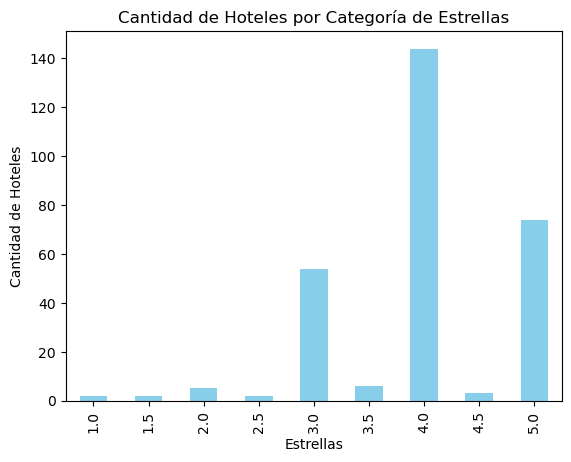

In [46]:
# Contar la cantidad de hoteles por categoría de estrellas
cantidad_hoteles_por_estrellas = df['Estrellas'].value_counts()

# Ordenar el índice para asegurar que el gráfico esté en orden
cantidad_hoteles_por_estrellas = cantidad_hoteles_por_estrellas.sort_index()

# Graficar
cantidad_hoteles_por_estrellas.plot(kind='bar', color='skyblue')
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de Hoteles')
plt.title('Cantidad de Hoteles por Categoría de Estrellas')
plt.show()

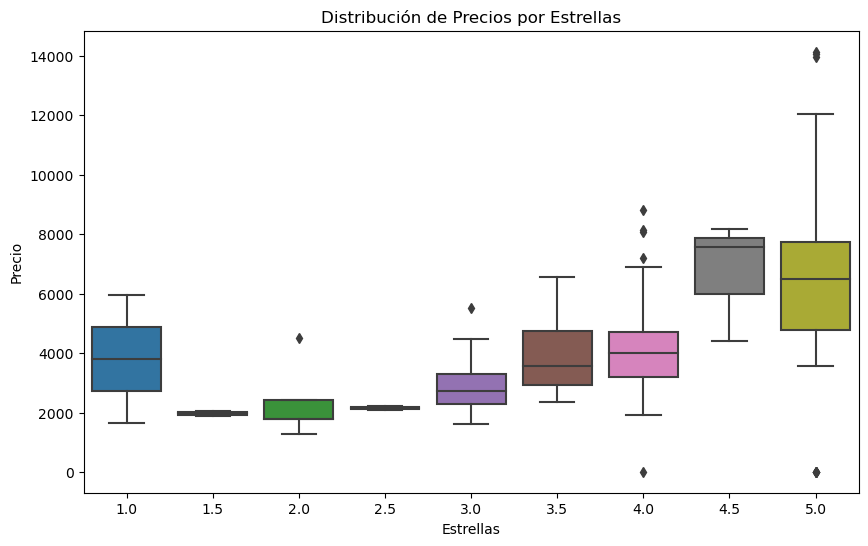

In [51]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Estrellas", y="Precio")
plt.xlabel("Estrellas")
plt.ylabel("Precio")
plt.title("Distribución de Precios por Estrellas")
plt.show()

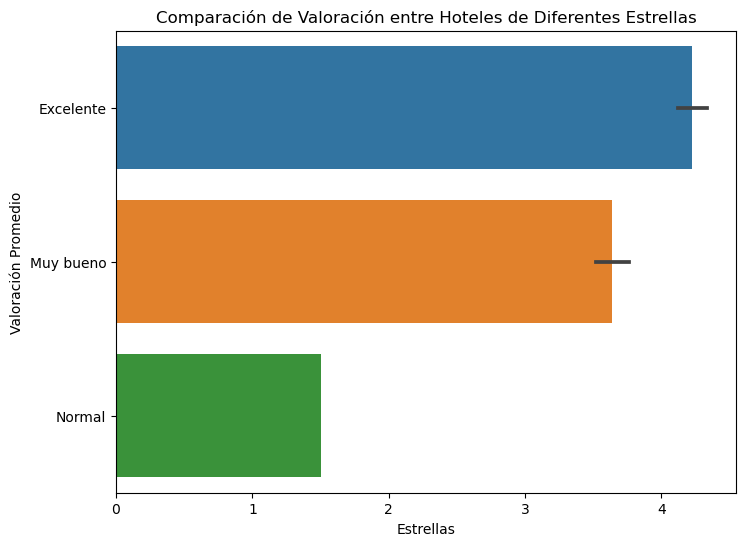

In [165]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="Estrellas", y="Valoración")
plt.xlabel("Estrellas")
plt.ylabel("Valoración Promedio")
plt.title("Comparación de Valoración entre Hoteles de Diferentes Estrellas")
plt.show()


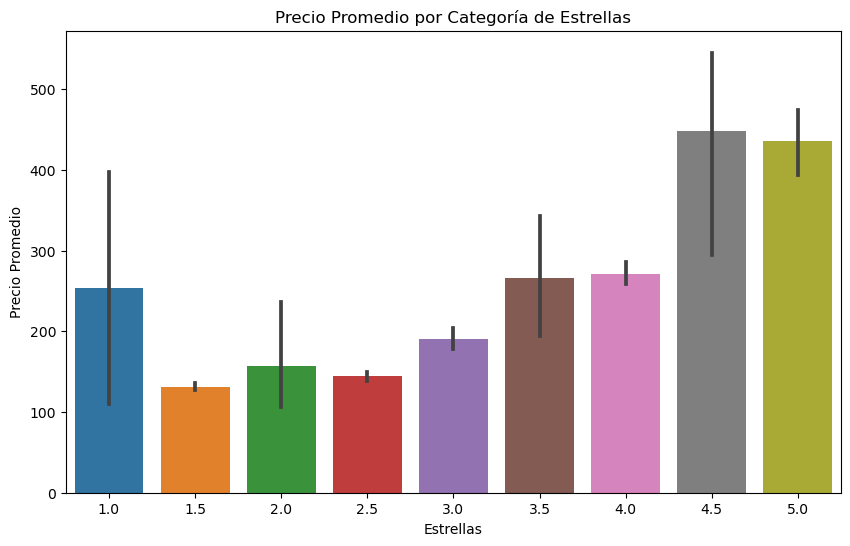

In [166]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Estrellas", y="Precio", estimator=np.mean)
plt.xlabel("Estrellas")
plt.ylabel("Precio Promedio")
plt.title("Precio Promedio por Categoría de Estrellas")
plt.show()

# PARIS

In [60]:
df = pd.read_csv("Data/FILTRADO_PARIS_TRIPADVISOR.csv")

In [61]:
df

Unnamed: 0.1  Unnamed: 0                                          Nombre  \
0               0           0                              Grand Hotel Malher   
1               1           1                           Hotel Malte - Astotel   
2               2           2                Apartments Du Louvre - Le Marais   
3               3           3                            Le Relais Des Halles   
4               4           4  Maison Astor Paris, Curio Collection by Hilton   
..            ...         ...                                             ...   
469           469         482                       Le Marceau Bastille Hotel   
470           470         483                                     Hôtel Basss   
471           471         484                                     Le Belleval   
472           472         485                                  Hotel Louis II   
473           473         486                        Hotel Royal Saint Michel   

             Ubicacion  Estrellas  Puntuación Valoración  
0    5 rue Malher 4th         3.0         4.0  Muy bueno  
1    63 rue de Richeli        4.0         5.0  Excelente  
2    4 rue Etienne Mar        5.0         5.0  Excelente  
3    26 Rue Pierre Les        4.0         5.0  Excelente  
4    11 Rue d’Astorg,         4.0         4.5  Excelente  
..                 ...        ...         ...        ...  
469  13 rue Jules Cesa        4.0         4.5  Excelente  
470  57 rue des Abbess        3.0         4.0  Muy bueno  
471  16 rue de la Pepi        4.0         4.5  Excelente  
472  2 rue Saint Sulpi        4.0         5.0  Excelente  
473  3 boulevard Saint        4.0         4.0  Muy bueno  

[474 rows x 7 columns]

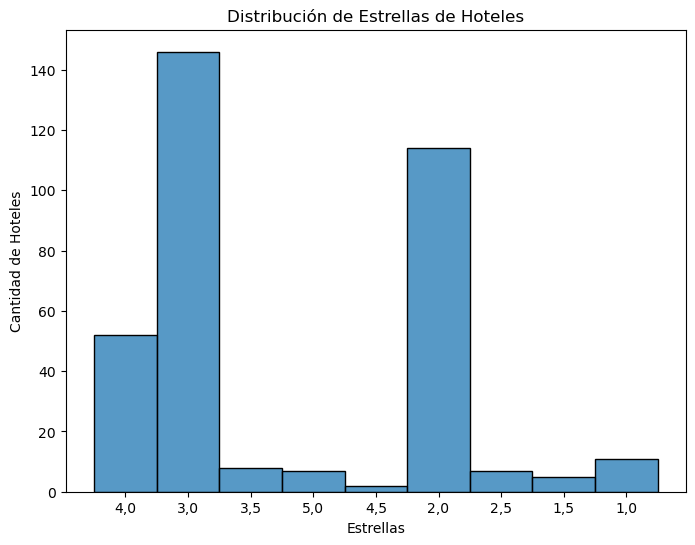

In [174]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="Estrellas", bins=5)
plt.xlabel("Estrellas")
plt.ylabel("Cantidad de Hoteles")
plt.title("Distribución de Estrellas de Hoteles")
plt.show()

/home/hacker/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/hacker/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/hacker/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/hacker/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/hacker/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


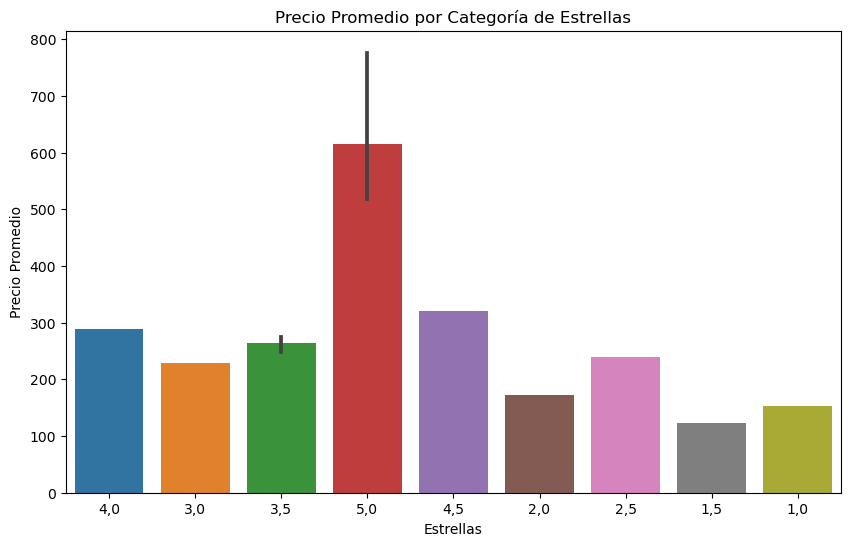

In [176]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Estrellas", y="Precio", estimator=np.mean)
plt.xlabel("Estrellas")
plt.ylabel("Precio Promedio")
plt.title("Precio Promedio por Categoría de Estrellas")
plt.show()